In [1]:
%%capture
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../../'))
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
import joblib
from IPython.core.display import display, HTML
from scipy.spatial import distance
from sklearn.ensemble import RandomForestClassifier as RandomForest, RandomForestRegressor, AdaBoostClassifier, AdaBoostRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from Audio_Sentiment_Analysis.utils.Configuration import Configuration
from tabulate import tabulate

AUDIO_DIR = f"{os.path.abspath('./../../../')}/IEMOCAP_Dataset"
EXTRACTED_FEATURES_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/preprocessed_extracted_features_iemocap.csv"
ALL_EXTRACTED_FEATURES_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/all_preprocessed_extracted_features_iemocap.csv"
SCALED_FEATURES_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/scaled_features_iemocap.csv"
CONFIG_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/config.json"
RAW_AUDIO_FILES = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/raw_audio_files.csv"
AUDIO_SPECTOGRAMS_DIR = './../data/spectograms/'
AUDIO_CLASSIFIER_MODEL = '../../audio_classifier_model.pkl'

config = Configuration.load_json(CONFIG_FILE)
colors = ["blue", "orange", "green", "red"]

OneHotEncodingConfig = {'0': [1, 0], '1': [0, 1]}
plt.rcParams['figure.dpi'] = 300
tabulate.LATEX_ESCAPE_RULES = {}

In [2]:
def get_metrics(y_labels, y_pred, folds_size, ticks, show_cm=True, cv=5):
    accs = []
    i = 0
    for f_i in range(cv):
        acc = round(metrics.accuracy_score(y_labels[i:i+folds_size[f_i]], y_pred[i:i+folds_size[f_i]]) * 100, 2)
        i += folds_size[f_i]
        print(f"Accuracy of fold {f_i+1}: {acc}%")
        accs.append(acc)
    
    mean_acc = f"{round(metrics.accuracy_score(y_labels, y_pred) * 100, 2)}+-{round(np.std(accs), 2)}"
    mean_f1 = f"{round(metrics.f1_score(y_labels, y_pred, average='macro') * 100, 2)}"
    mean_pre = f"{round(metrics.precision_score(y_labels, y_pred, average='macro') * 100, 2)}"
    mean_rec = f"{round(metrics.recall_score(y_labels, y_pred, average='macro') * 100, 2)}"
    mean_mcc = f"{round(metrics.matthews_corrcoef(y_labels, y_pred), 2)}"

    table = [
        ["Accuracy", mean_acc],
        ["F1 score macro", mean_f1],
        ["Precision", mean_pre],
        ["Recall", mean_rec],
        ["Matthews corrcoef", mean_mcc],
    ]
    print()
    print(tabulate(table, headers=["Metric", "Value"]))

    if show_cm:
        cm = metrics.confusion_matrix(y_labels, y_pred, normalize='all')
        plt.figure(figsize=(4, 4))
        sns.heatmap(cm, annot=True, fmt=".2f",
                    xticklabels=ticks, yticklabels=ticks)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Emotion Label")
        plt.ylabel("Real Emotion Label")
        plt.yticks(rotation=0)
        plt.show()

    return [x[1] for x in table]

def categorical_cross_validation(get_new_model, used_labels, results, cv=5):
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=1)
    
    X = df.iloc[:,9:]
    y = df.iloc[:,5:6]
    all_y_pred = []
    all_y_labels = []
    folds_size = []

    fold_no = 1
    for train, test in kfold.split(X, y):
        model = get_new_model()
        
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]
        folds_size.append(len(y_test))
        
        model.fit(X_train, y_train.values.ravel())

        y_pred = model.predict(X_test)
        all_y_pred.extend(y_pred)
        all_y_labels.extend(y_test.values.ravel())

        fold_no = fold_no + 1

    metrics = get_metrics(all_y_labels, all_y_pred, folds_size, used_labels.split(", "))
    results.append([used_labels, len(df), metrics[0], metrics[1], metrics[2], metrics[3], metrics[4]])

    return results

results = []

In [36]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
print(df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}))
df['Duration'].quantile([0.33333333, 0.66666666])

                   Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
happy   1             1636
neutral 3             1708
sad     2             1084


0.333333    2.288771
0.666667    4.375875
Name: Duration, dtype: float64

Duration

Short Duration Number of Files: 1844
                   Emotion
                     count
Emotion Emotion_Id        
angry   0              414
happy   1              512
neutral 3              681
sad     2              237
Accuracy of fold 1: 53.93%
Accuracy of fold 2: 56.37%
Accuracy of fold 3: 57.18%
Accuracy of fold 4: 56.1%
Accuracy of fold 5: 54.89%

Metric             Value
-----------------  -----------
Accuracy           55.69+-1.15
F1 score macro     54.64
Precision          56.59
Recall             53.54
Matthews corrcoef  0.38


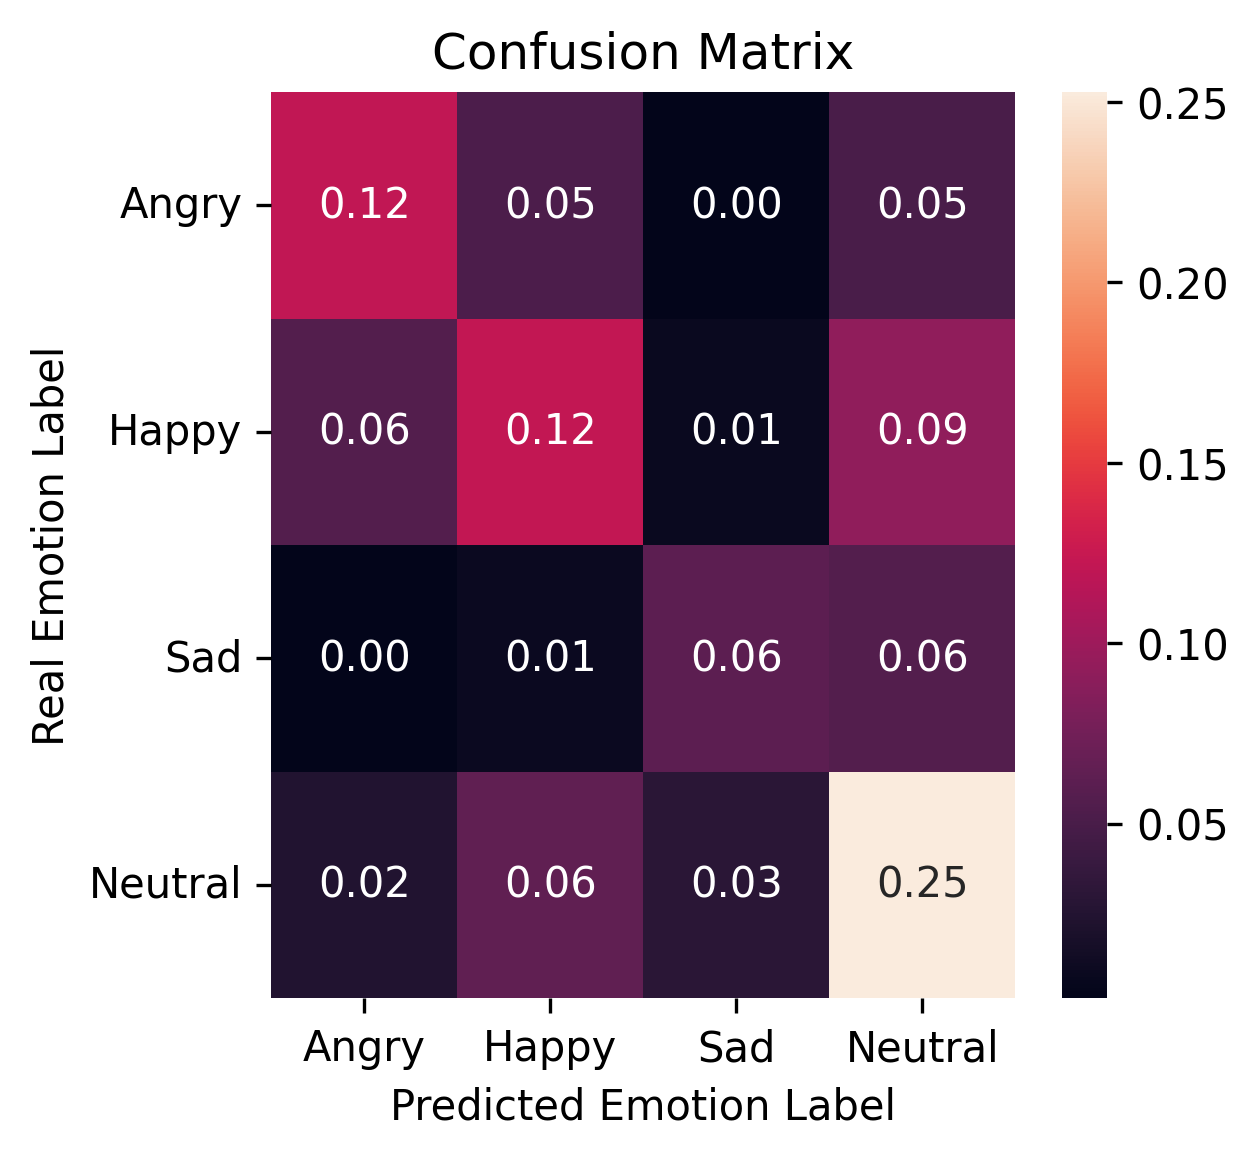

Medium Duration Number of Files: 1843
                   Emotion
                     count
Emotion Emotion_Id        
angry   0              352
happy   1              549
neutral 3              569
sad     2              373
Accuracy of fold 1: 53.12%
Accuracy of fold 2: 55.56%
Accuracy of fold 3: 57.18%
Accuracy of fold 4: 57.34%
Accuracy of fold 5: 60.05%

Metric             Value
-----------------  -----------
Accuracy           56.65+-2.28
F1 score macro     57.16
Precision          57.25
Recall             57.26
Matthews corrcoef  0.41


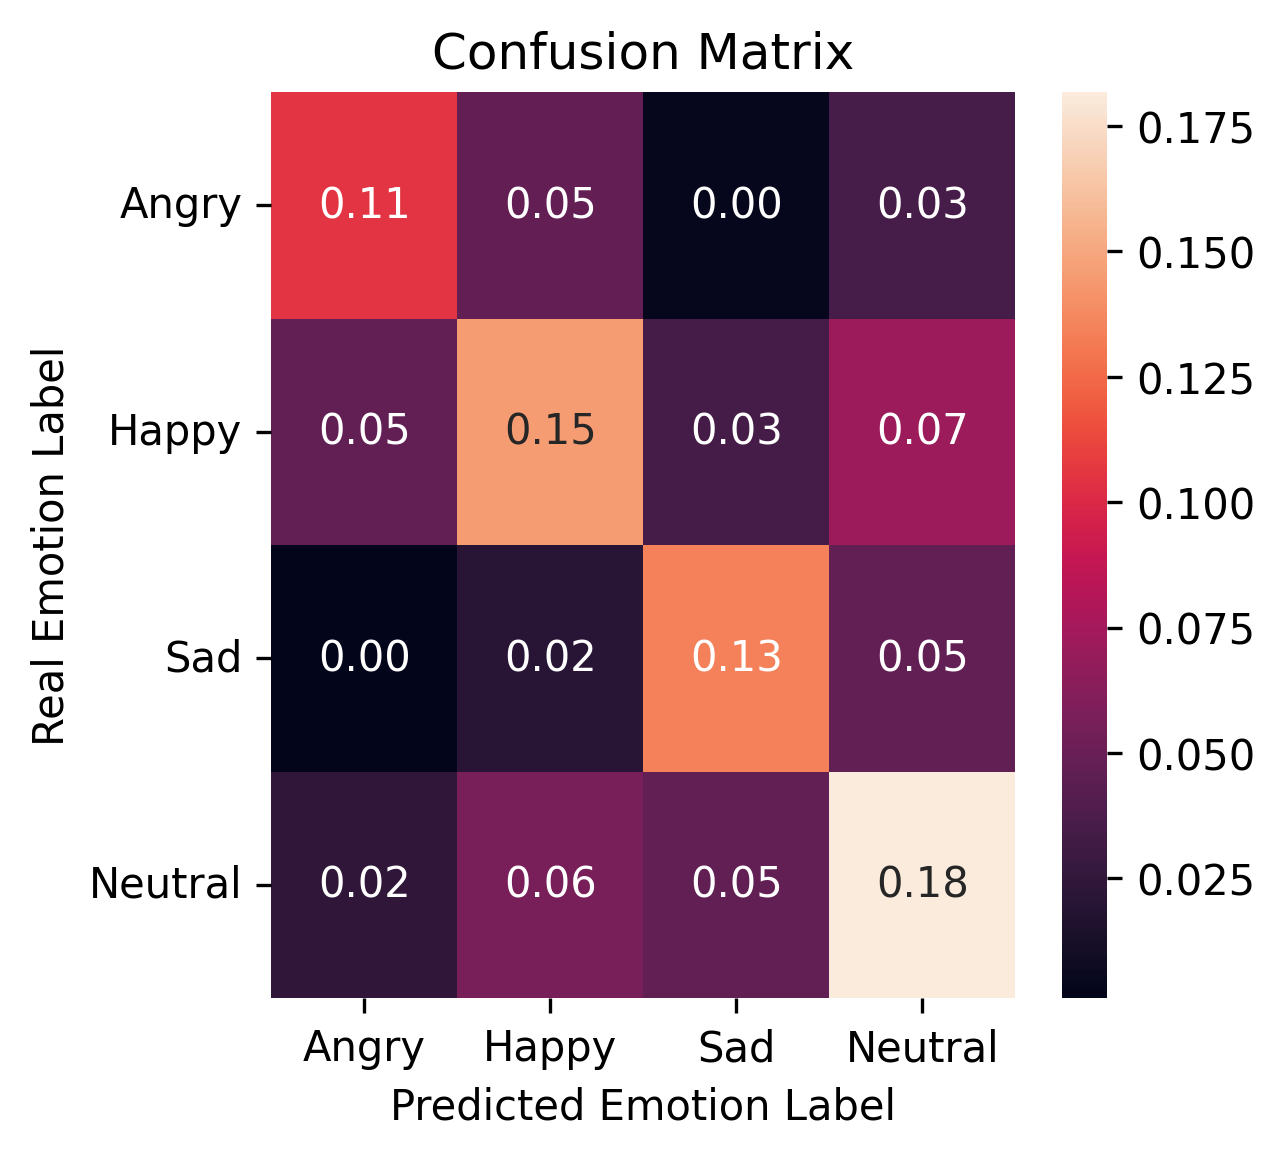

Long Duration Number of Files: 1844
                   Emotion
                     count
Emotion Emotion_Id        
angry   0              337
happy   1              575
neutral 3              458
sad     2              474
Accuracy of fold 1: 63.96%
Accuracy of fold 2: 62.6%
Accuracy of fold 3: 65.04%
Accuracy of fold 4: 64.23%
Accuracy of fold 5: 63.04%

Metric             Value
-----------------  -----------
Accuracy           63.77+-0.87
F1 score macro     64.16
Precision          64.32
Recall             64.17
Matthews corrcoef  0.51


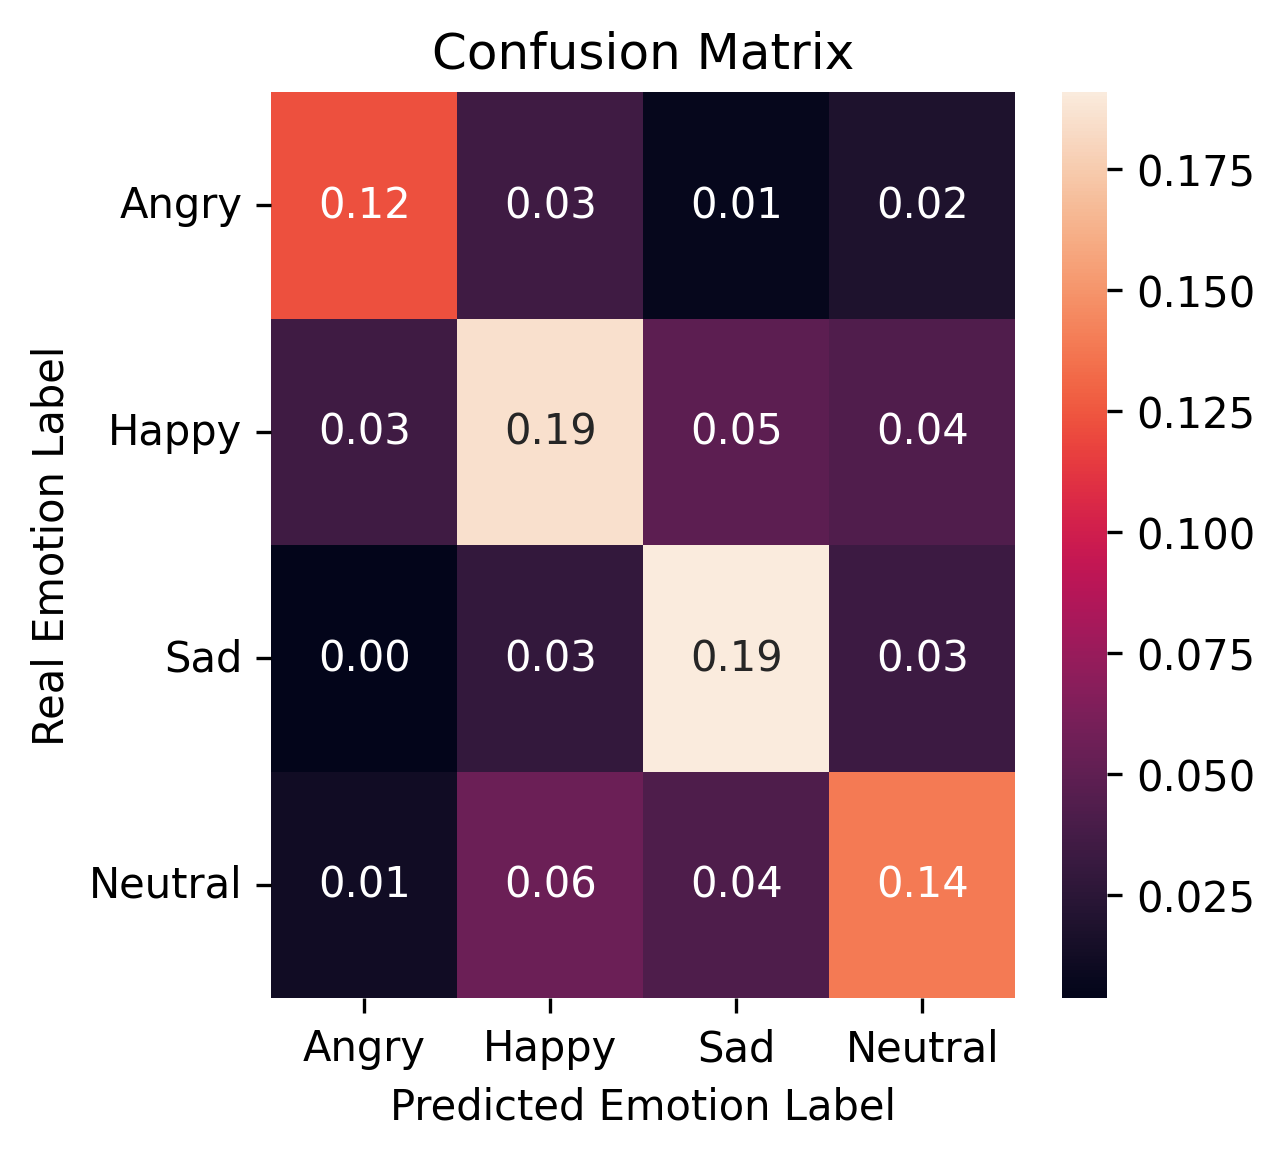

In [4]:
from xgboost import XGBClassifier

def get_new_model():
    return XGBClassifier(random_state=1, colsample_bytree=0.8, colsample_bylevel=0.8, subsample=0.9,
                      n_estimators=512, max_depth=8, learning_rate=0.1, n_jobs=-1)

results = []
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df = df[df["Duration"] <= 2.288771]
print(f"Short Duration Number of Files: {len(df)}")
print(df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}))
results = categorical_cross_validation(get_new_model, "Angry, Happy, Sad, Neutral", results)

df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df = df[df["Duration"] > 2.288771]
df = df[df["Duration"] <= 4.375875]
print(f"Medium Duration Number of Files: {len(df)}")
print(df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}))
results = categorical_cross_validation(get_new_model, "Angry, Happy, Sad, Neutral", results)


df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df = df[df["Duration"] > 4.375875]
print(f"Long Duration Number of Files: {len(df)}")
print(df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}))
results = categorical_cross_validation(get_new_model, "Angry, Happy, Sad, Neutral", results)


In [5]:
tabulate(results,
            headers=["Classification Labels", "Total Data", "Accuracy", "Macro F1",
                    "Precision", "Recall", "MCC."], tablefmt='html'
        )

print(tabulate(results,
            headers=["Classification Labels", "Total Data", "Accuracy", "Macro F1",
                    "Precision", "Recall", "MCC."], tablefmt='latex_booktabs'
        ))


\begin{tabular}{lrlrrrr}
\toprule
 Classification Labels      &   Total Data & Accuracy    &   Macro F1 &   Precision &   Recall &   MCC. \\
\midrule
 Angry, Happy, Sad, Neutral &         1844 & 55.69+-1.15 &      54.64 &       56.59 &    53.54 &   0.38 \\
 Angry, Happy, Sad, Neutral &         1843 & 56.65+-2.28 &      57.16 &       57.25 &    57.26 &   0.41 \\
 Angry, Happy, Sad, Neutral &         1844 & 63.77+-0.87 &      64.16 &       64.32 &    64.17 &   0.51 \\
\bottomrule
\end{tabular}


Gender

In [6]:
def categorical_cross_validation_gender(df_one, df_two, get_new_model, used_labels, results, cv=5):
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=1)

    X_train_df = df_one.iloc[:,9:]
    y_train_df = df_one.iloc[:,5:6]

    X_test_df = df_two.iloc[:,9:]
    y_test_df = df_two.iloc[:,5:6]

    test_indices = []
    for _, test in kfold.split(X_test_df, y_test_df):
        test_indices.append(test)

    all_y_pred = []
    all_y_labels = []
    folds_size = []

    fold_no = 0
    for train, _ in kfold.split(X_train_df, y_train_df):
        test = test_indices[fold_no]
        folds_size.append(len(test))

        model = get_new_model()
        
        X_train, y_train = X_train_df.iloc[train], y_train_df.iloc[train]
        X_test, y_test = X_test_df.iloc[test], y_test_df.iloc[test]

        model.fit(X_train, y_train.values.ravel())

        y_pred = model.predict(X_test)
        all_y_pred.extend(y_pred)
        all_y_labels.extend(y_test.values.ravel())

        fold_no = fold_no + 1

    metrics = get_metrics(all_y_labels, all_y_pred, folds_size, used_labels.split(", "))
    results.append([used_labels, len(df_one), metrics[0], metrics[1], metrics[2], metrics[3], metrics[4]])

    return results

Female Speaker Number of Files: 2649
                   Emotion
                     count
Emotion Emotion_Id        
angry   0              589
happy   1              770
neutral 3              733
sad     2              557
Accuracy of fold 1: 49.57%
Accuracy of fold 2: 50.78%
Accuracy of fold 3: 51.22%
Accuracy of fold 4: 50.17%
Accuracy of fold 5: 49.65%

Metric             Value
-----------------  -----------
Accuracy           50.28+-0.64
F1 score macro     50.57
Precision          50.36
Recall             51.1
Matthews corrcoef  0.32


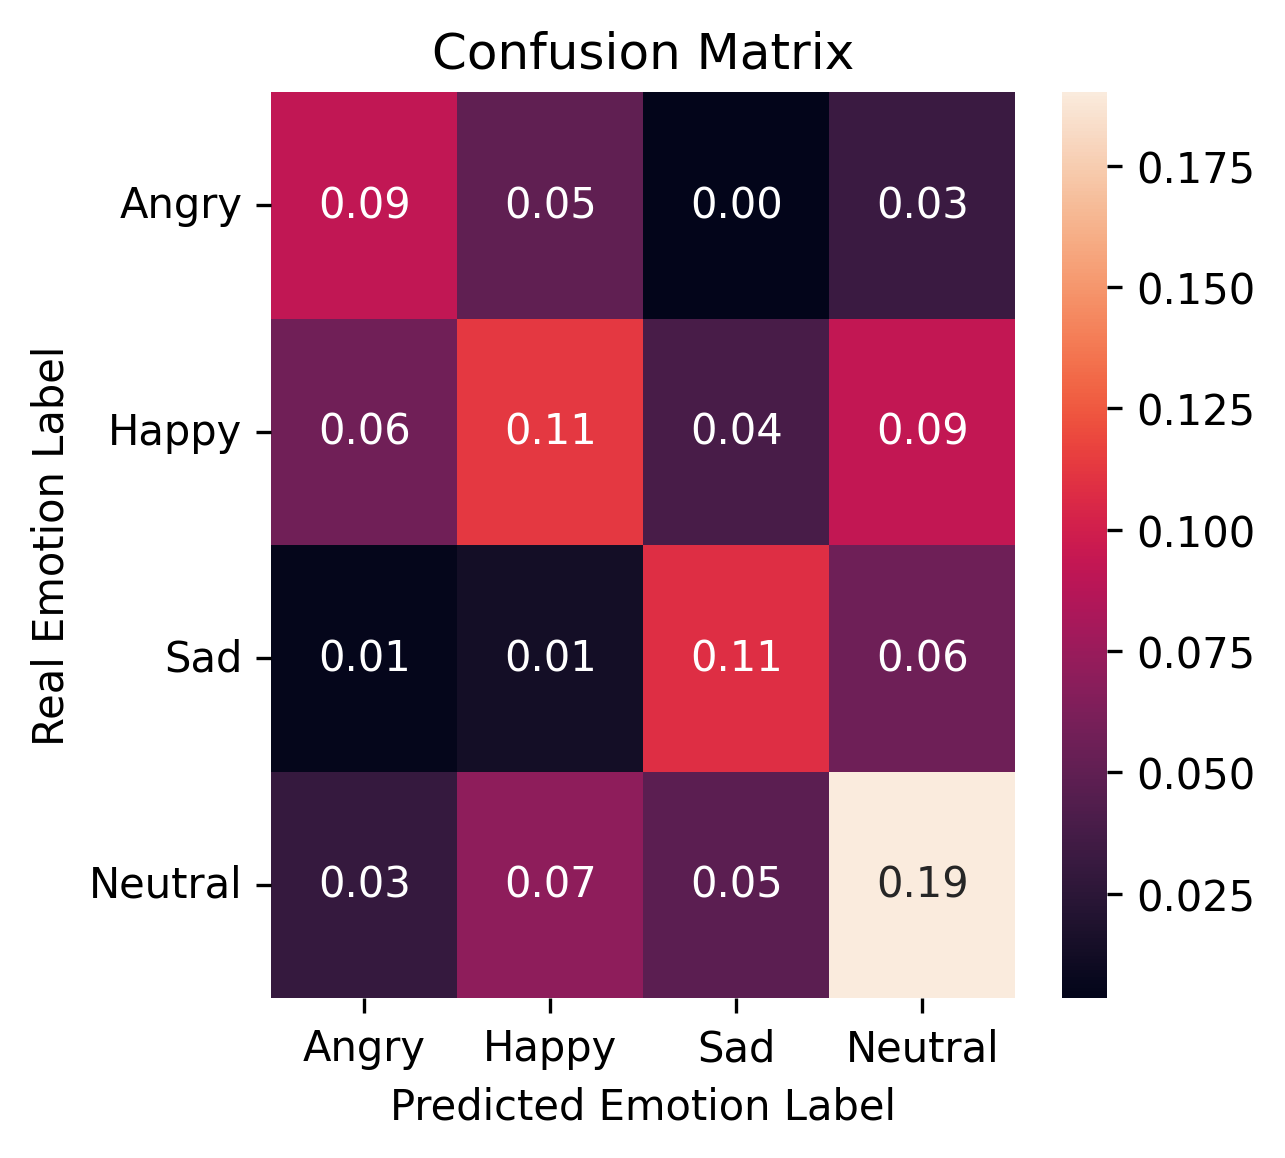

Male Speaker Number of Files: 2882
                   Emotion
                     count
Emotion Emotion_Id        
angry   0              514
happy   1              866
neutral 3              975
sad     2              527
Accuracy of fold 1: 50.38%
Accuracy of fold 2: 49.81%
Accuracy of fold 3: 48.11%
Accuracy of fold 4: 51.32%
Accuracy of fold 5: 47.45%

Metric             Value
-----------------  -----------
Accuracy           49.41+-1.43
F1 score macro     50.26
Precision          53.37
Recall             49.24
Matthews corrcoef  0.32


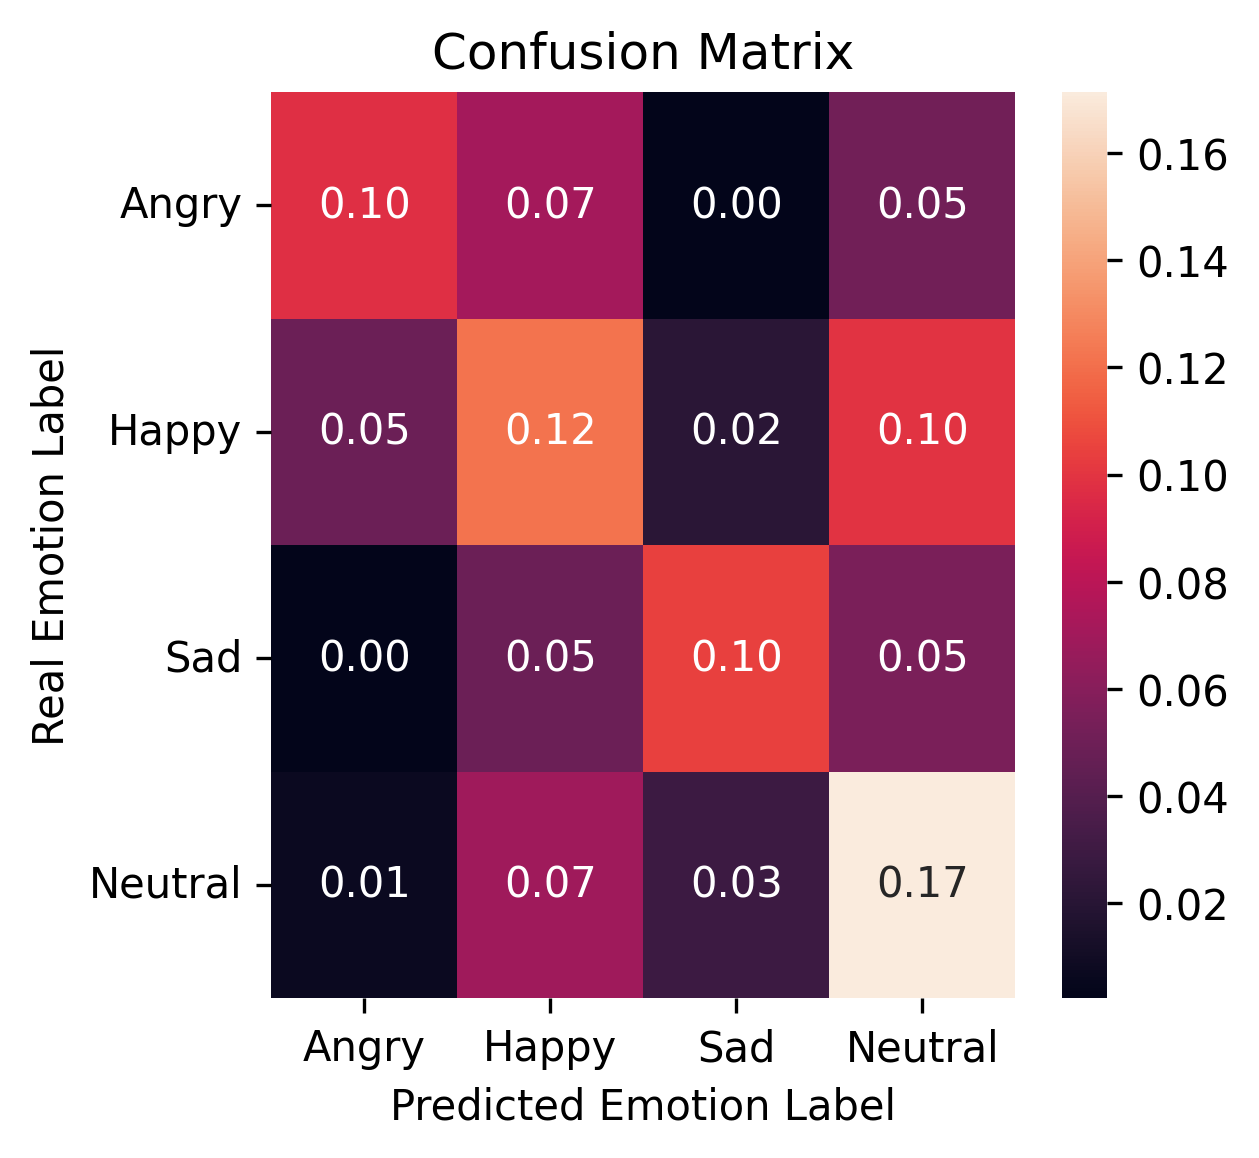

In [7]:
def get_new_model():
    return XGBClassifier(random_state=1, colsample_bytree=0.8, colsample_bylevel=0.8, subsample=0.9,
                      n_estimators=512, max_depth=8, learning_rate=0.1, n_jobs=-1)
                      
results = []
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df_female = df[df["Gender"] == "Female"]
df_male = df[df["Gender"] == "Male"]

print(f"Female Speaker Number of Files: {len(df_female)}")
print(df_female.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}))
results = categorical_cross_validation_gender(df_female, df_male, get_new_model, "Angry, Happy, Sad, Neutral", results)

print(f"Male Speaker Number of Files: {len(df_male)}")
print(df_male.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}))
results = categorical_cross_validation_gender(df_male, df_female, get_new_model, "Angry, Happy, Sad, Neutral", results)

Accuracy of fold 1: 59.06%
Accuracy of fold 2: 58.11%
Accuracy of fold 3: 60.57%
Accuracy of fold 4: 59.62%
Accuracy of fold 5: 62.38%

Metric             Value
-----------------  -----------
Accuracy           59.95+-1.45
F1 score macro     60.47
Precision          60.4
Recall             60.77
Matthews corrcoef  0.46


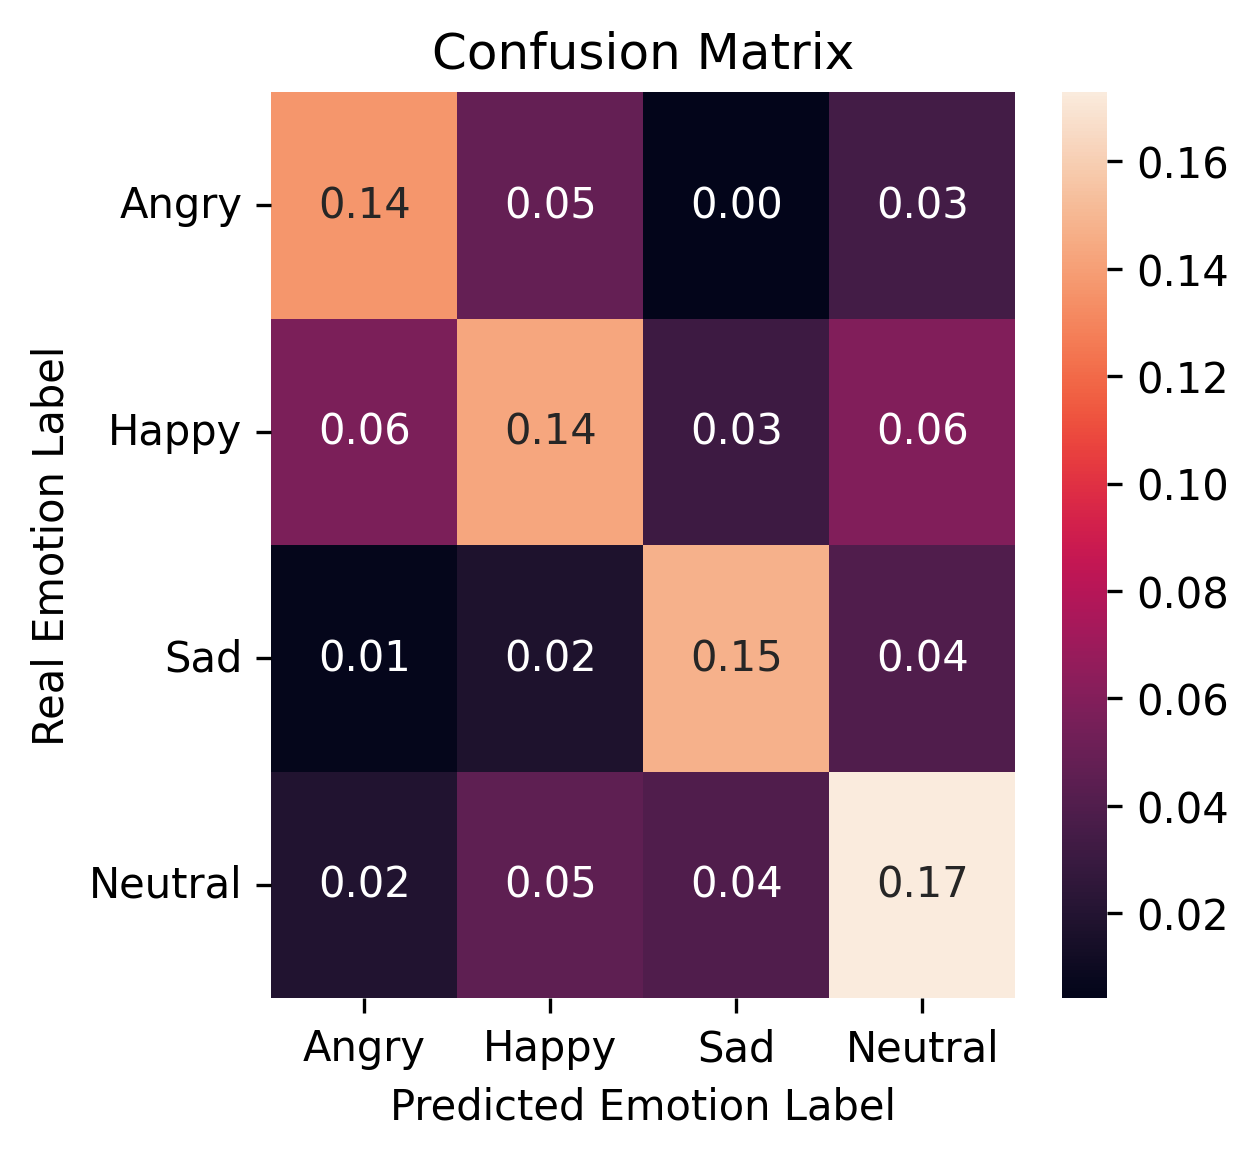

Accuracy of fold 1: 58.75%
Accuracy of fold 2: 62.05%
Accuracy of fold 3: 60.24%
Accuracy of fold 4: 58.51%
Accuracy of fold 5: 60.42%

Metric             Value
-----------------  -----------
Accuracy           59.99+-1.28
F1 score macro     60.67
Precision          61.38
Recall             60.2
Matthews corrcoef  0.45


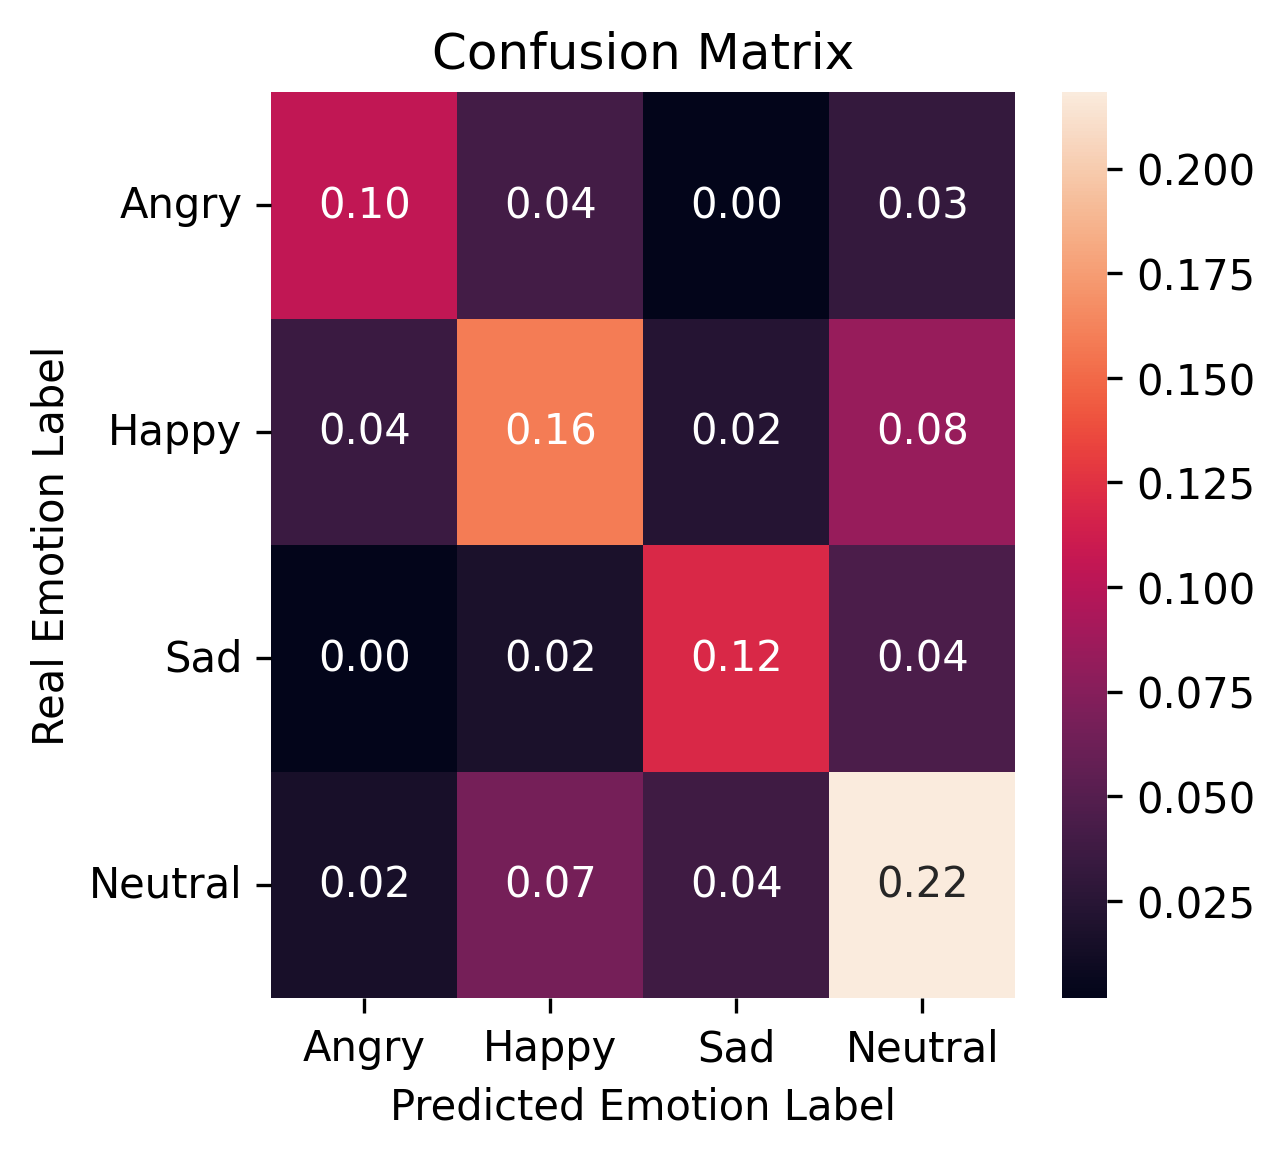

In [11]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df = df[df["Gender"] == "Female"]
results = categorical_cross_validation(get_new_model, "Angry, Happy, Sad, Neutral", results)
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df = df[df["Gender"] == "Male"]
results = categorical_cross_validation(get_new_model, "Angry, Happy, Sad, Neutral", results)
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1

In [12]:
tabulate(results,
            headers=["Classification Labels", "Total Data", "Accuracy", "Macro F1",
                    "Precision", "Recall", "MCC."], tablefmt='html'
        )

print(tabulate(results,
            headers=["Classification Labels", "Total Data", "Accuracy", "Macro F1",
                    "Precision", "Recall", "MCC."], tablefmt='latex_booktabs'
        ))

\begin{tabular}{lrlrrrr}
\toprule
 Classification Labels      &   Total Data & Accuracy    &   Macro F1 &   Precision &   Recall &   MCC. \\
\midrule
 Angry, Happy, Sad, Neutral &         2649 & 50.28+-0.64 &      50.57 &       50.36 &    51.1  &   0.32 \\
 Angry, Happy, Sad, Neutral &         2882 & 49.41+-1.43 &      50.26 &       53.37 &    49.24 &   0.32 \\
 Angry, Happy, Sad, Neutral &         2649 & 59.95+-1.45 &      60.47 &       60.4  &    60.77 &   0.46 \\
 Angry, Happy, Sad, Neutral &         2882 & 59.99+-1.28 &      60.67 &       61.38 &    60.2  &   0.45 \\
\bottomrule
\end{tabular}


In [ ]:
def categorical_cross_validation2(get_new_model, centroids, used_labels, results, cv=5):
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)
    
    X = df.iloc[:,9:]
    y = df.iloc[:,5:6]
    all_y_pred = []
    all_y_labels = []
    folds_size = []

    fold_no = 1
    for train, test in kfold.split(X, y):
        model = get_new_model()
        
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_dim_train = [centroids[int(x)] for x in y.iloc[train].values.ravel()]
        y_test = y.iloc[test].values.ravel()

        folds_size.append(len(y_test))

        model.fit(X_train, y_dim_train)

        y_pred = model.predict(X_test)

        # Closest Centroid is considered the predicted Emotion
        # Using manhatan distance
        y_pred = [np.argmin([distance.cityblock(x, c) for c in centroids]) for x in y_pred]

        all_y_pred.extend(y_pred)
        all_y_labels.extend(y_test)

        fold_no = fold_no + 1

    metrics = get_metrics(all_y_labels, all_y_pred, folds_size, used_labels.split(", "), show_cm=False)
    results.append([used_labels, len(df), metrics[0], metrics[1], metrics[2], metrics[3], metrics[4]])

    return results


In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

def categorical_cross_validation_dimensional(get_new_model, cv=5):
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)
    X = df.iloc[:,9:]
    y = df.iloc[:,5:6]

    results = []

    for i in range(6, 9):
        all_y_pred = []
        all_y_labels = []
        folds_size = []

        fold_no = 1
        for train, test in kfold.split(X, y):
            model = get_new_model()
            
            X_train, X_test = X.iloc[train], X.iloc[test]
            y_train, y_test = df.iloc[train, i:i+1].values.ravel(), df.iloc[test, i:i+1].values.ravel()

            folds_size.append(len(y_test))
            print(f"Training fold {fold_no}")
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            all_y_pred.extend(y_pred)
            all_y_labels.extend(y_test)

            fold_no = fold_no + 1

        metrics = [
            mean_absolute_error(all_y_labels, all_y_pred),
            sqrt(mean_squared_error(all_y_labels, all_y_pred)),
            r2_score(all_y_labels, all_y_pred)
        ]
        print(metrics)
        results.append([df.iloc[:,i:i+1].columns[0], metrics[0], metrics[1], metrics[2]])

    return results


In [32]:
def categorical_cross_validation3(get_new_model, centroids, used_labels, results, cv=5):
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)
    
    X = df.iloc[:,9:]
    y = df.iloc[:,5:6]
    all_y_pred = []
    all_y_labels = []
    folds_size = []

    fold_no = 1
    for train, test in kfold.split(X, y):
        model = get_new_model()
        
        X_train, X_test = X.iloc[train], X.iloc[test]
        # Closest Centroid is considered the Emotion for training
        # Using manhatan distance
        y_train = [np.argmin([distance.cityblock(x, c) for c in centroids]) for x in df.iloc[train, 5:8].values]
        y_test = y.iloc[test].values.ravel()

        folds_size.append(len(y_test))

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        
        all_y_pred.extend(y_pred)
        all_y_labels.extend(y_test)

        fold_no = fold_no + 1

    metrics = get_metrics(all_y_labels, all_y_pred, folds_size, used_labels.split(", "), show_cm=False)
    results.append([used_labels, len(df), metrics[0], metrics[1], metrics[2], metrics[3], metrics[4]])

    return results


In [31]:
def categorical_cross_validation4(get_new_model, centroids, used_labels, results, cv=5):
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)
    
    X = df.iloc[:,9:]
    y = df.iloc[:,5:6]
    all_y_pred = []
    all_y_labels = []
    folds_size = []

    fold_no = 1
    for train, test in kfold.split(X, y):
        model = get_new_model()
        
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_dim_train = df.iloc[train, 5:8].values
        y_test = y.iloc[test].values.ravel()

        folds_size.append(len(y_test))

        model.fit(X_train, y_dim_train)

        y_pred = model.predict(X_test)
        
        # Closest Centroid is considered the predicted Emotion
        # Using manhatan distance
        y_pred = [np.argmin([distance.cityblock(x, c) for c in centroids]) for x in y_pred]

        all_y_pred.extend(y_pred)
        all_y_labels.extend(y_test)

        fold_no = fold_no + 1

    metrics = get_metrics(all_y_labels, all_y_pred, folds_size, used_labels.split(", "), show_cm=False)
    results.append([used_labels, len(df), metrics[0], metrics[1], metrics[2], metrics[3], metrics[4]])

    return results


In [30]:
def categorical_cross_validation5(get_new_model, get_new_model2, centroids, used_labels, results, cv=5):
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)

    X = df.iloc[:,9:]
    y = df.iloc[:,5:6]
    y_dim = df.iloc[:,6:9]
    all_y_pred = []
    all_y_labels = []
    folds_size = []

    fold_no = 1
    for train, test in kfold.split(X, y):
        model_categorical = get_new_model()
        model_regression = get_new_model2()

        X_train, X_test = X.iloc[train], X.iloc[test]
        y_dim_train = y_dim.iloc[train]
        y_train, y_test = y.iloc[train].values.ravel(), y.iloc[test].values.ravel()

        folds_size.append(len(y_test))

        model_regression.fit(X_train, y_dim_train.values)

        X_train.insert(0, value=y_dim_train['Valence'], column='Valence')
        X_train.insert(1, value=y_dim_train['Activation'], column='Activation')
        X_train.insert(2, value=y_dim_train['Dominance'], column='Dominance')
        
        model_categorical.fit(X_train, y_train)

        y_pred_regression = pd.DataFrame(model_regression.predict(X_test), columns=['Valence', 'Activation', 'Dominance'])
        
        X_test.insert(0, value=y_pred_regression['Valence'].values, column='Valence')
        X_test.insert(1, value=y_pred_regression['Activation'].values, column='Activation')
        X_test.insert(2, value=y_pred_regression['Dominance'].values, column='Dominance')

        y_pred_categorical = model_categorical.predict(X_test)
        
        # # Closest Centroid is considered the predicted Emotion
        # # Using manhatan distance
        # y_pred = [np.argmin([distance.cityblock(x, c) for c in centroids]) for x in y_pred]

        all_y_pred.extend(y_pred_categorical)
        all_y_labels.extend(y_test)

        fold_no = fold_no + 1

    metrics = get_metrics(all_y_labels, all_y_pred, folds_size, used_labels.split(", "), show_cm=False)
    results.append([used_labels, len(df), metrics[0], metrics[1], metrics[2], metrics[3], metrics[4]])

    return results


In [29]:
def categorical_cross_validation6(get_new_model, get_new_model2, centroids, used_labels, results, cv=5):
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)

    X = df.iloc[:,9:]
    y = df.iloc[:,5:6]
    y_dim = df.iloc[:,6:9]
    all_y_pred = []
    all_y_labels = []
    folds_size = []

    fold_no = 1
    for train, test in kfold.split(X, y):
        model_categorical = get_new_model()
        model_regression = get_new_model2()

        X_train, X_test = X.iloc[train], X.iloc[test]
        y_dim_train = y_dim.iloc[train]
        y_train, y_test = y.iloc[train].values.ravel(), y.iloc[test].values.ravel()

        folds_size.append(len(y_test))

        model_regression.fit(X_train, y_dim_train.values)
        
        y_dim_train = y_dim_train.apply(
            lambda x:
                pd.Series(np.argmin([distance.cityblock((x['Valence'], x['Activation'], x['Dominance']), c) for c in centroids]),
                          index=['Angry_Centroid_Distance']),
                axis=1)

        X_train.insert(0, value=y_dim_train['Angry_Centroid_Distance'], column='Angry_Centroid_Distance')
        # X_train.insert(1, value=y_dim_train['Happy_Centroid_Distance'], column='Happy_Centroid_Distance')
        # X_train.insert(2, value=y_dim_train['Sad_Centroid_Distance'], column='Sad_Centroid_Distance')
        # X_train.insert(3, value=y_dim_train['Neutral_Centroid_Distance'], column='Neutral_Centroid_Distance')
        
        model_categorical.fit(X_train, y_train)

        y_pred_regression = pd.DataFrame(model_regression.predict(X_test), columns=['Valence', 'Activation', 'Dominance'])
        # Using manhatan distance
        y_pred_regression = y_pred_regression.apply(
            lambda x:
                pd.Series(np.argmin([distance.cityblock((x['Valence'], x['Activation'], x['Dominance']), c) for c in centroids]),
                          index=['Angry_Centroid_Distance']),
                axis=1)
        
        X_test.insert(0, value=y_pred_regression['Angry_Centroid_Distance'].values, column='Angry_Centroid_Distance')
        # X_test.insert(1, value=y_pred_regression['Happy_Centroid_Distance'].values, column='Happy_Centroid_Distance')
        # X_test.insert(2, value=y_pred_regression['Sad_Centroid_Distance'].values, column='Sad_Centroid_Distance')
        # X_test.insert(3, value=y_pred_regression['Neutral_Centroid_Distance'].values, column='Neutral_Centroid_Distance')

        y_pred_categorical = model_categorical.predict(X_test)
        

        all_y_pred.extend(y_pred_categorical)
        all_y_labels.extend(y_test)

        fold_no = fold_no + 1

    metrics = get_metrics(all_y_labels, all_y_pred, folds_size, used_labels.split(", "), show_cm=False)
    results.append([used_labels, len(df), metrics[0], metrics[1], metrics[2], metrics[3], metrics[4]])

    return results


In [28]:
def categorical_cross_validation7(get_new_model, get_new_model_regressor, centroids, used_labels, results, threshold, cv=5):
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)
    
    X = df.iloc[:,9:]
    y = df.iloc[:,5:6]
    all_y_pred = []
    all_y_labels = []
    folds_size = []

    fold_no = 1
    for train, test in kfold.split(X, y):
        model = get_new_model()
        model_regressor = get_new_model_regressor()
        
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_dim_train, y_test = y.iloc[train].values.ravel(), df.iloc[train, 5:8].values, y.iloc[test].values.ravel()
        folds_size.append(len(y_test))

        model.fit(X_train, y_train)
        model_regressor.fit(X_train, y_dim_train)

        y_pred = model.predict(X_test)
        y_pred_reg = model_regressor.predict(X_test)

        discarded_pred_indices = []
        [discarded_pred_indices.append(i) for i, pred in enumerate(y_pred) 
            if distance.cityblock(y_pred_reg[i], centroids[pred]) > threshold]

        print(f"Discarded Predictions on Fold {fold_no}: {len(discarded_pred_indices)}")
        y_pred = [l for i, l in enumerate(y_pred) if i not in discarded_pred_indices]
        y_test = [l for i, l in enumerate(y_test) if i not in discarded_pred_indices]

        all_y_pred.extend(y_pred)
        all_y_labels.extend(y_test)

        fold_no = fold_no + 1

    metrics = get_metrics(all_y_labels, all_y_pred, folds_size, used_labels.split(", "), show_cm=False)
    results.append([used_labels, len(df), metrics[0], metrics[1], metrics[2], metrics[3], metrics[4]])

    return results


In [27]:
def categorical_cross_validation8(get_new_model, used_labels, results, cv=5):
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=1)

    X = df.iloc[:,9:]
    y = df.iloc[:,5:6]
    all_y_pred = []
    all_y_labels = []
    folds_size = []

    fold_no = 1
    for train, test in kfold.split(X, y):
        model = get_new_model()

        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train].values.ravel(), y.iloc[test].values.ravel()
        folds_size.append(len(y_test))
        
        y_train_vad = []
        for label in y_train:
            if label == 0:
                y_train_vad.append([2, 0])
            elif label == 1:
                y_train_vad.append([2, 2])
            elif label == 2:
                y_train_vad.append([0, 0])
            else:
                y_train_vad.append([1, 1])

        model.fit(X_train, y_train_vad)
        
        y_pred_vad = model.predict(X_test)
        
        y_pred, deleted_pred_indices = [], set()
        for i, label in enumerate(y_pred_vad):
            if (label == [2, 0]).all():
                y_pred.append(0)
            elif (label == [2, 2]).all():
                y_pred.append(1)
            elif (label == [0, 0]).all():
                y_pred.append(2)
            elif (label == [1, 1]).all():
                y_pred.append(3)
            else:
                deleted_pred_indices.add(i)

        print(f"Deleted labels: {len(deleted_pred_indices)}")
        y_test = [label for i, label in enumerate(y_test) if i not in deleted_pred_indices]
        all_y_pred.extend(y_pred)
        all_y_labels.extend(y_test)

        fold_no = fold_no + 1

    metrics = get_metrics(all_y_labels, all_y_pred, folds_size, used_labels.split(", "), show_cm=False)
    results.append([used_labels, len(df), metrics[0], metrics[1], metrics[2], metrics[3], metrics[4]])

    return results


In [14]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)

df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df['Valence'] = df['Valence'].apply(lambda x: x if x <= 5 else 5)

def get_new_model():
    return XGBClassifier(random_state=1, colsample_bytree=0.8, colsample_bylevel=0.8, subsample=0.9,
                      n_estimators=512, max_depth=8, learning_rate=0.1, n_jobs=-1)
                      
def get_new_model_regressor():
    return RandomForestRegressor(n_estimators=512, n_jobs=-1, random_state=1)

centroids = []
for i, emotion in enumerate(['angry', 'happy', 'sad', 'neutral']):
    df_temp = df[df['Emotion'] == emotion]
    centroids.append(df_temp.iloc[:,6:9].mean(axis=0).values)

Testing SMOTE

In [10]:
def categorical_cross_validation_smote(get_new_model, used_labels, results, cv=5):
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=1)
    sm = SMOTE(random_state=1)

    X = df.iloc[:,9:]
    y = df.iloc[:,5:6]
    all_y_pred = []
    all_y_labels = []
    folds_size = []

    fold_no = 1
    for train, test in kfold.split(X, y):
        model = get_new_model()
        
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]
        folds_size.append(len(y_test))

        X_train, y_train = sm.fit_resample(X_train, y_train)

        model.fit(X_train, y_train.values.ravel())

        y_pred = model.predict(X_test)
        all_y_pred.extend(y_pred)
        y_test = np.reshape(y_test.values, y_pred.shape)
        all_y_labels.extend(y_test)

        fold_no = fold_no + 1

    metrics = get_metrics(all_y_labels, all_y_pred, folds_size, used_labels.split(", "))
    results.append([used_labels, len(df), metrics[0], metrics[1], metrics[2], metrics[3], metrics[4]])

    return results

Accuracy of fold 1: 59.17%
Accuracy of fold 2: 60.13%
Accuracy of fold 3: 59.76%
Accuracy of fold 4: 61.12%
Accuracy of fold 5: 60.04%

Metric             Value
-----------------  -----------
Accuracy           60.04+-0.63
F1 score macro     60.65
Precision          60.29
Recall             61.4
Matthews corrcoef  0.46


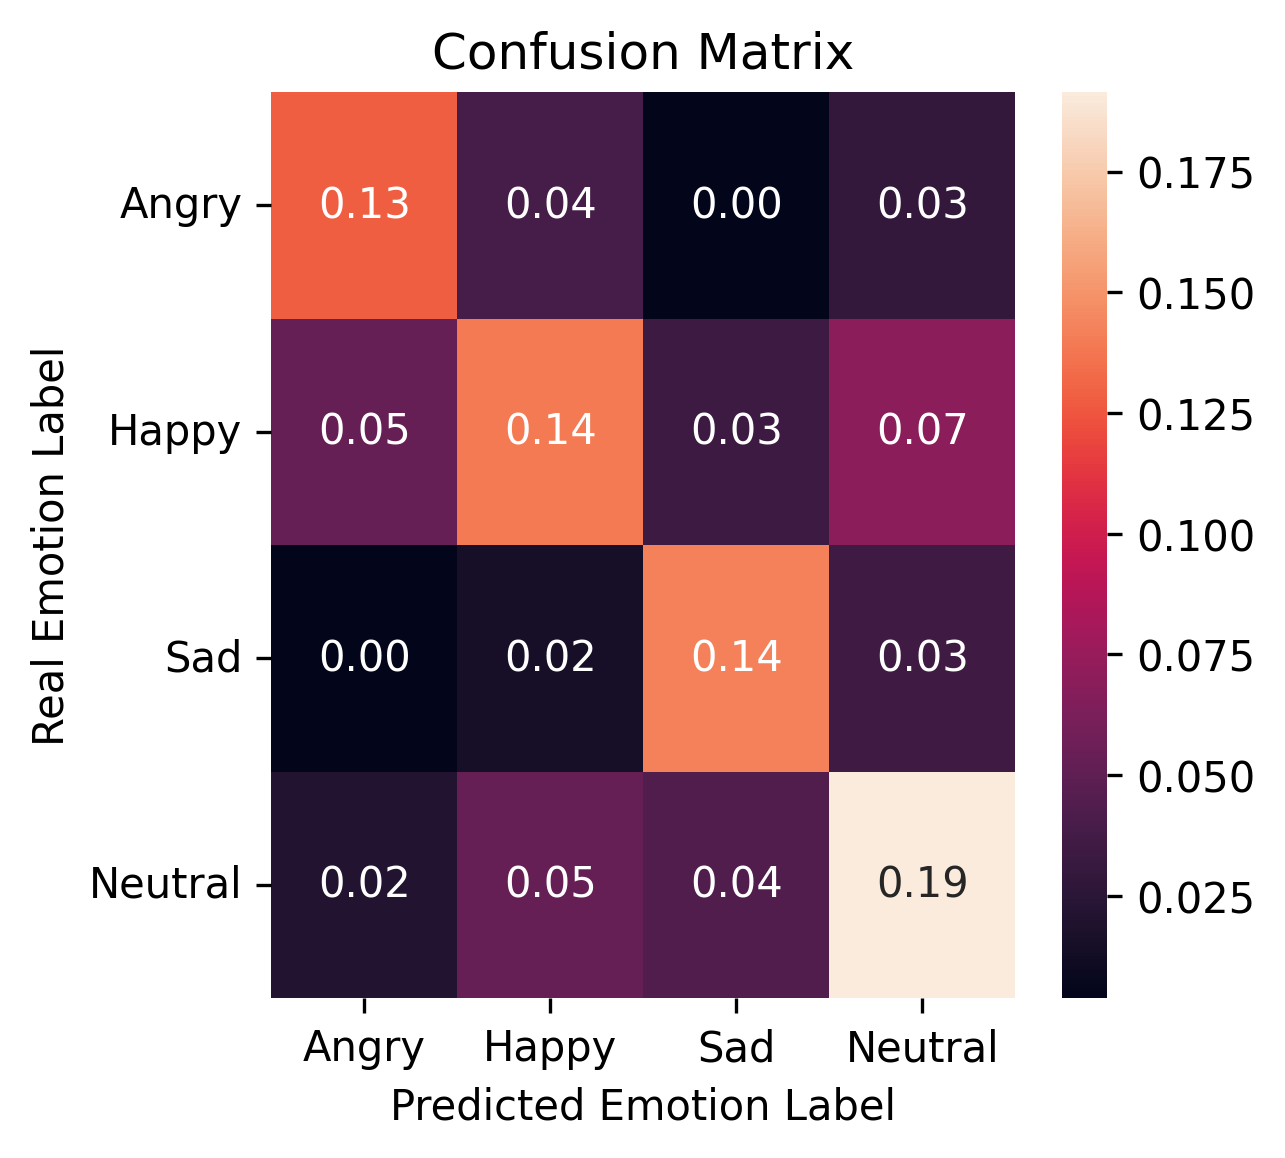

In [11]:
results = categorical_cross_validation_smote(get_new_model, "Angry, Happy, Sad, Neutral", results)

Testing other strategies

In [16]:
dim_results = categorical_cross_validation_dimensional(get_new_model_regressor)

Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
[0.7001841377364514, 0.8590473702120303, 0.18164644697377985]
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
[0.4138066975131645, 0.521537363310951, 0.520407662200725]
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
[0.5336170398591462, 0.6573677947838926, 0.36203272636633144]


In [18]:
print(tabulate(dim_results, headers=["Regression Labels", "MAE", "RMSE", "R2"], tablefmt='latex_booktabs'))

tabulate(dim_results, headers=["Regression Labels", "MAE", "RMSE", "R2"], tablefmt='html')

\begin{tabular}{lrrr}
\toprule
 Regression Labels   &      MAE &     RMSE &       R2 \\
\midrule
 Valence             & 0.700184 & 0.859047 & 0.181646 \\
 Activation          & 0.413807 & 0.521537 & 0.520408 \\
 Dominance           & 0.533617 & 0.657368 & 0.362033 \\
\bottomrule
\end{tabular}


'<table>\n<thead>\n<tr><th>Regression Labels  </th><th style="text-align: right;">     MAE</th><th style="text-align: right;">    RMSE</th><th style="text-align: right;">      R2</th></tr>\n</thead>\n<tbody>\n<tr><td>Valence            </td><td style="text-align: right;">0.700184</td><td style="text-align: right;">0.859047</td><td style="text-align: right;">0.181646</td></tr>\n<tr><td>Activation         </td><td style="text-align: right;">0.413807</td><td style="text-align: right;">0.521537</td><td style="text-align: right;">0.520408</td></tr>\n<tr><td>Dominance          </td><td style="text-align: right;">0.533617</td><td style="text-align: right;">0.657368</td><td style="text-align: right;">0.362033</td></tr>\n</tbody>\n</table>'


Metric             Value
-----------------  -----------
Accuracy           59.93+-1.01
F1 score macro     60.63
Precision          61.11
Recall             60.51
Matthews corrcoef  0.46


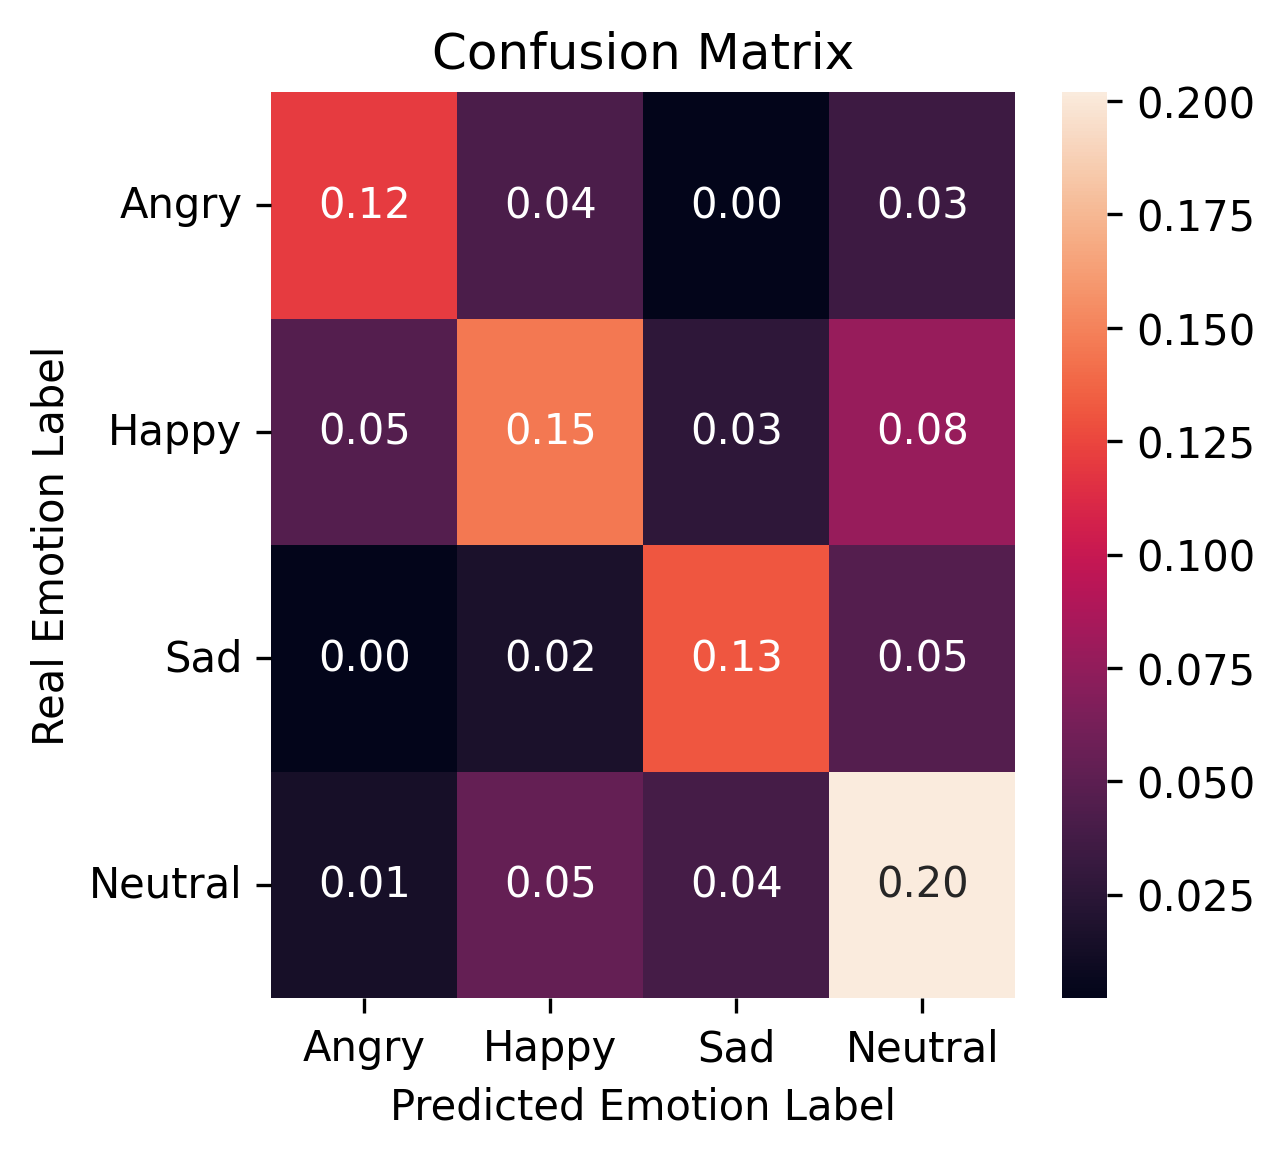

In [36]:
# using the juries VAD classification doesn't really help with the categorical classification
# so the annotations might not be very good
results = categorical_cross_validation(get_new_model, "Angry, Happy, Sad, Neutral", results)
results = categorical_cross_validation2(get_new_model_regressor, centroids, "Angry, Happy, Sad, Neutral", results)
results = categorical_cross_validation3(get_new_model, centroids, "Angry, Happy, Sad, Neutral", results)
results = categorical_cross_validation4(get_new_model_regressor, centroids, "Angry, Happy, Sad, Neutral", results)
results = categorical_cross_validation5(get_new_model, get_new_model_regressor, centroids, "Angry, Happy, Sad, Neutral", results)
results = categorical_cross_validation6(get_new_model, get_new_model_regressor, centroids, "Angry, Happy, Sad, Neutral", results)
results = categorical_cross_validation7(get_new_model, get_new_model_regressor, centroids, "Angry, Happy, Sad, Neutral", results, 0.2)
results = categorical_cross_validation8(get_new_model, "Angry, Happy, Sad, Neutral", results)


In [ ]:
results = categorical_cross_validation7(get_new_model, get_new_model_regressor, centroids, "Angry, Happy, Sad, Neutral", results, 1.8)

Discarded Predictions on Fold 1: 558
Discarded Predictions on Fold 2: 578
Discarded Predictions on Fold 3: 548
Discarded Predictions on Fold 4: 527
Discarded Predictions on Fold 5: 531
Accuracy for fold 0: 59.98%
Accuracy for fold 1: 61.48%
Accuracy for fold 2: 60.76%
Accuracy for fold 3: nan%
Accuracy for fold 4: nan%

Metric             Value
-----------------  ----------
Accuracy           60.74+-nan
F1 score macro     40.13+-nan
Precision          44.14+-nan
Recall             42.74+-nan
Matthews corrcoef  0.39+-0.19


C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\User

In [39]:
results = categorical_cross_validation8(get_new_model, "Angry, Happy, Sad, Neutral", results)

ValueError: y should be a 1d array, got an array of shape (4424, 2) instead.

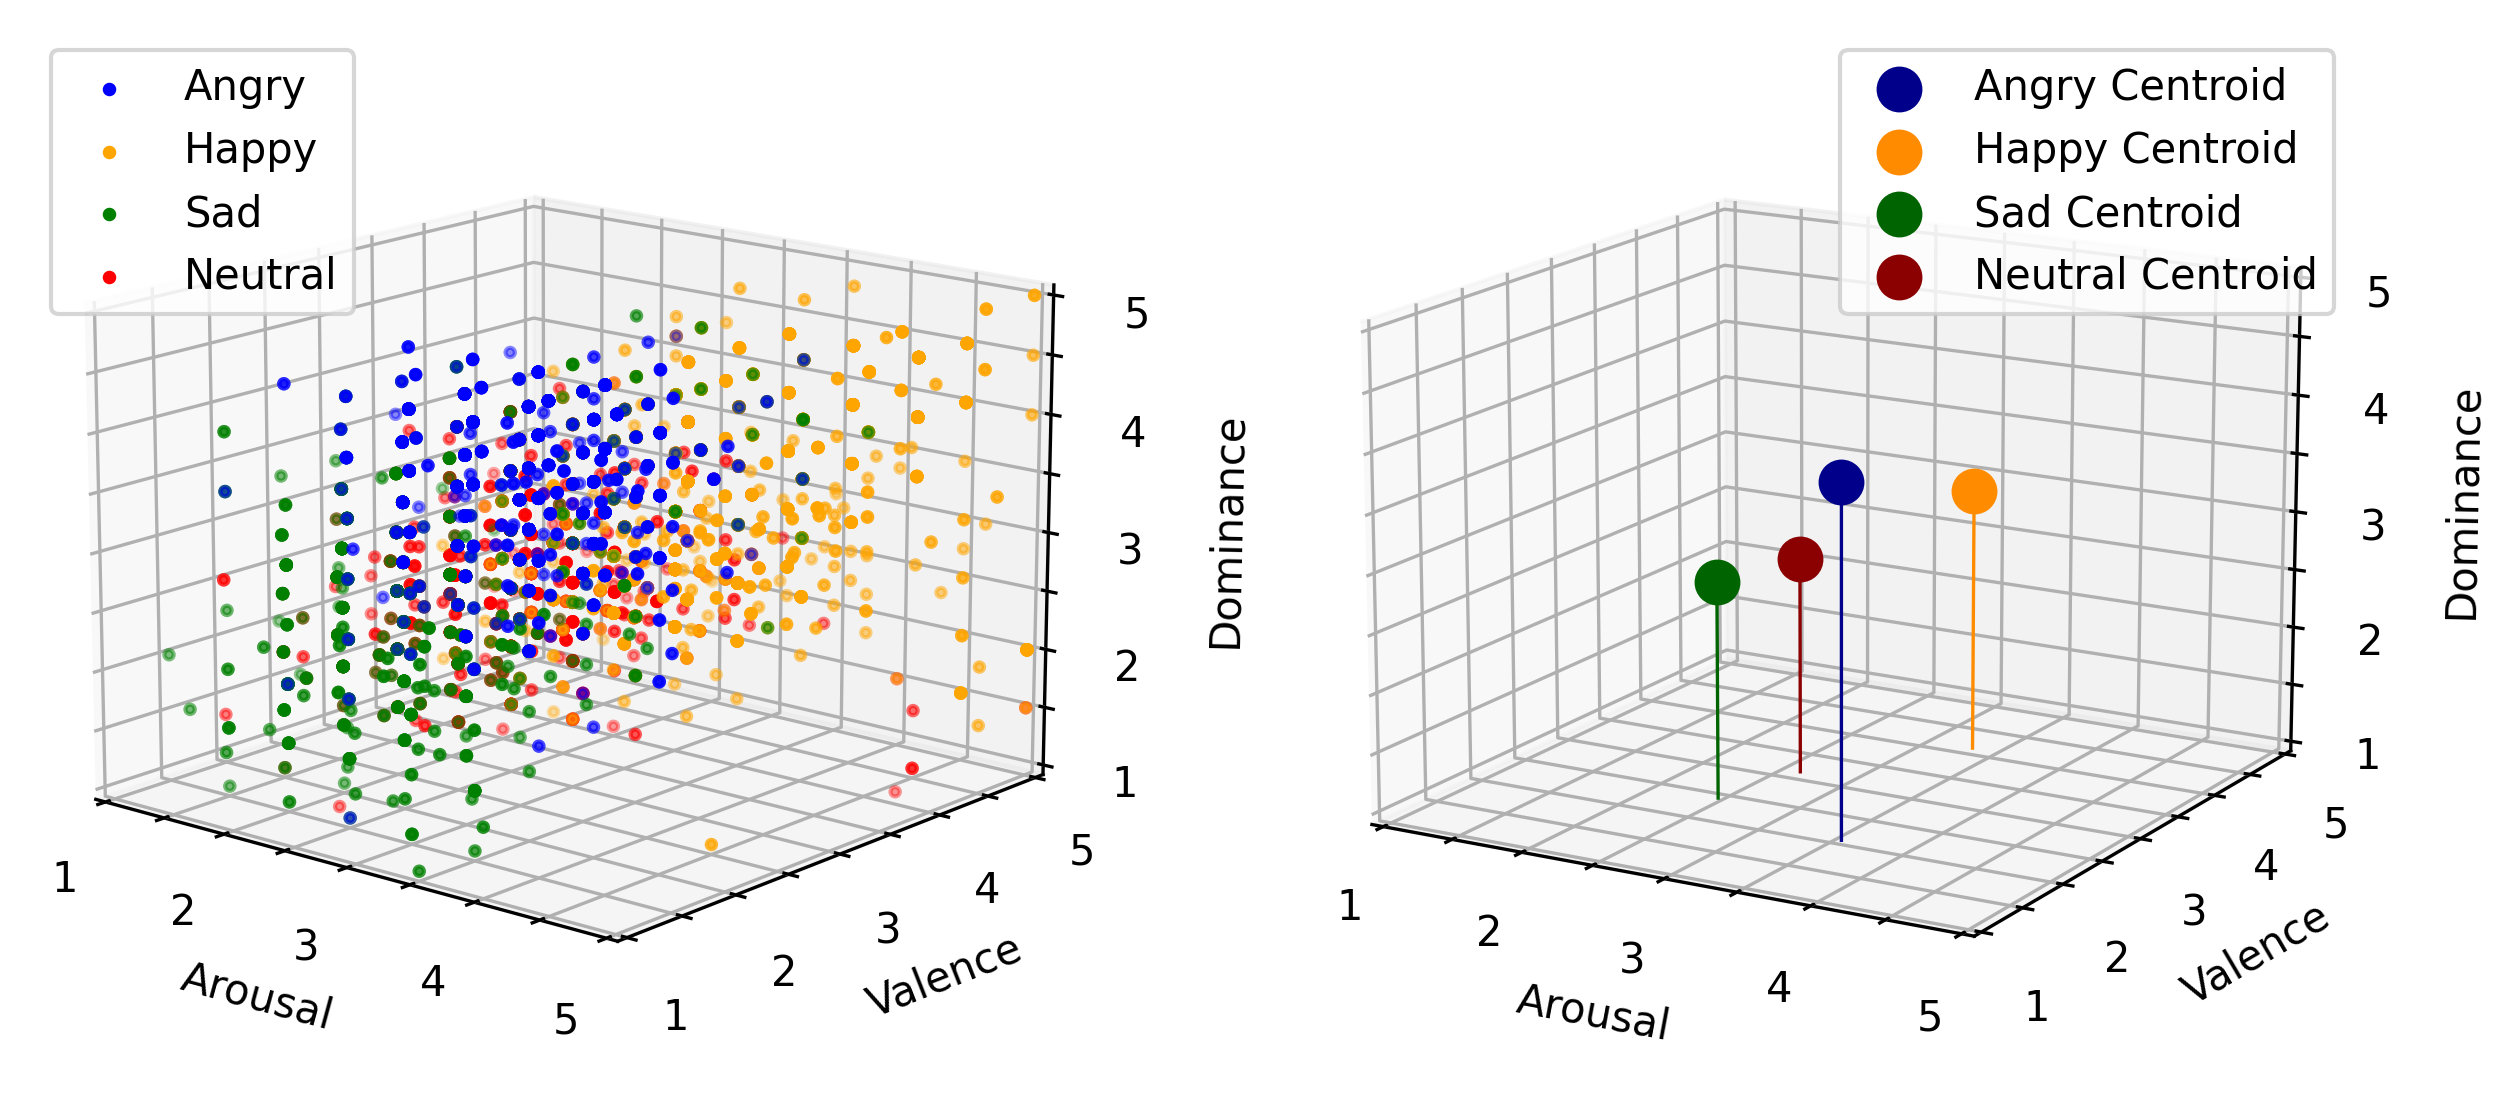

In [15]:
fig = plt.figure(figsize=(10, 5))
spec = fig.add_gridspec(1, 2)
ax = fig.add_subplot(spec[0, 0], projection='3d')
ax.set_xlabel("Arousal")
ax.set_ylabel("Valence")
ax.set_zlabel("Dominance")
ax.set_xticks(np.arange(1, 5.5, 0.5), labels=['1','','2','','3','','4','','5'])
ax.set_yticks(np.arange(1, 5.5, 0.5), labels=['1','','2','','3','','4','','5'])
ax.set_zticks(np.arange(1, 5.5, 0.5), labels=['1','','2','','3','','4','','5'])
ax.set_xlim(1, 5)
ax.set_ylim(1, 5)
ax.set_zlim(1, 5)
for i, emotion in enumerate(['angry', 'happy', 'sad', 'neutral']):
    df_temp = df[df['Emotion'] == emotion]
    x = df_temp["Activation"].values
    y = df_temp["Valence"].values
    z = df_temp["Dominance"].values
    ax.scatter(x,y,z, marker='.', label=emotion.title(), color=colors[i])
    ax.view_init(15, -50)
    plt.legend()


ax = fig.add_subplot(spec[0, 1], projection='3d')
ax.set_xlabel("Arousal")
ax.set_ylabel("Valence")
ax.set_zlabel("Dominance")
ax.set_xticks(np.arange(1, 5.5, 0.5), labels=['1','','2','','3','','4','','5'])
ax.set_yticks(np.arange(1, 5.5, 0.5), labels=['1','','2','','3','','4','','5'])
ax.set_zticks(np.arange(1, 5.5, 0.5), labels=['1','','2','','3','','4','','5'])
ax.set_xlim(1, 5)
ax.set_ylim(1, 5)
ax.set_zlim(1, 5)
ax.xaxis.set_minor_locator(plt.MultipleLocator(1/2))

for i, emotion in enumerate(['angry', 'happy', 'sad', 'neutral']):
    x = centroids[i][1]
    y = centroids[i][0]
    z = centroids[i][2]
    ax.scatter(x, y, z, label=f"{emotion.title()} Centroid", color=f"dark{colors[i]}", s=100)
    ax.plot([x]*2,[y]*2, [1, z], color=f"dark{colors[i]}", linewidth=0.8)
    ax.view_init(15, -60)
    plt.legend()
plt.legend()
plt.show()

<Figure size 1800x1200 with 0 Axes>

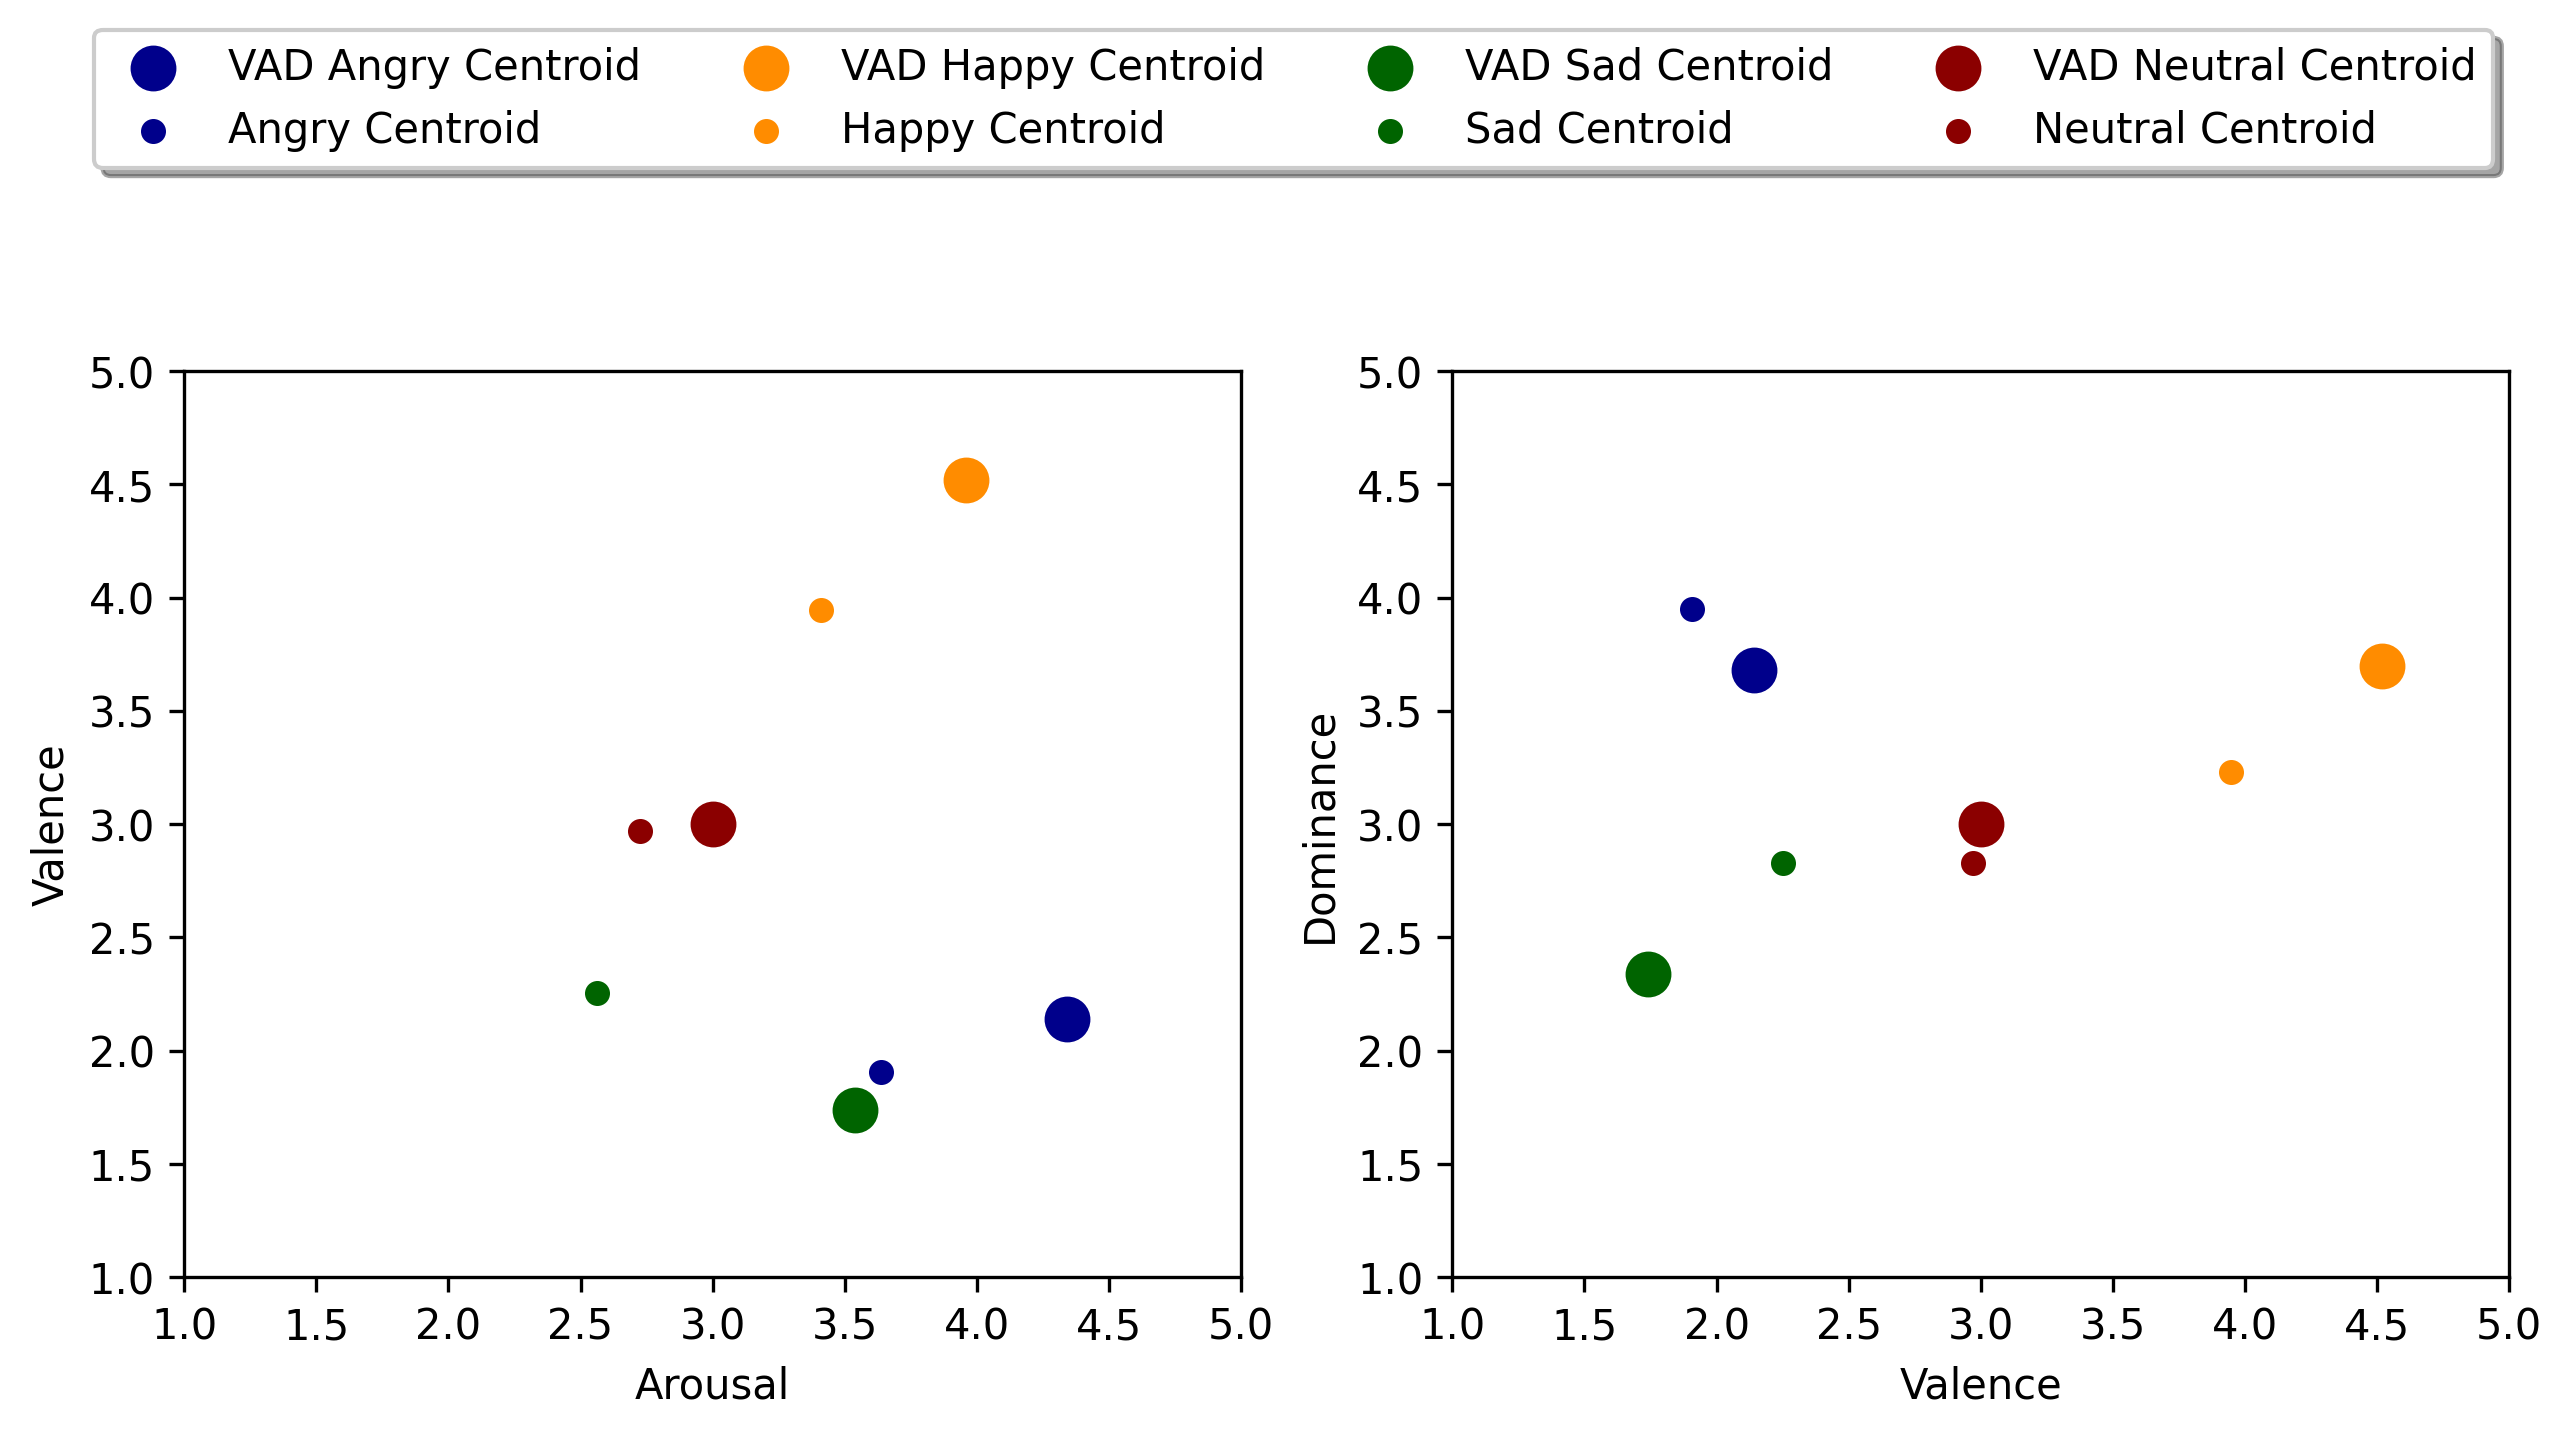

In [16]:
vad_centroids = [[2.14, 4.34, 3.68], [4.52, 3.96, 3.70], [1.74, 3.54, 2.34], [3.00, 3.00, 3.00]]

fig = plt.figure()
fig = plt.figure(figsize=(10, 4))
spec = fig.add_gridspec(1, 2)

ax1 = fig.add_subplot(spec[0, 0])
ax1.set_xlim([1, 5])
ax1.set_ylim([1, 5])
ax1.set_xlabel("Arousal")
ax1.set_ylabel("Valence")
ax2 = fig.add_subplot(spec[0, 1])
ax2.set_xlim([1, 5])
ax2.set_ylim([1, 5])
ax2.set_xlabel("Valence")
ax2.set_ylabel("Dominance")


for i, emotion in enumerate(['angry', 'happy', 'sad', 'neutral']):
    ax1.scatter(vad_centroids[i][1],vad_centroids[i][0], marker='o', label=f"VAD {emotion.title()} Centroid", color=f"dark{colors[i]}", s=100)
    ax2.scatter(vad_centroids[i][0],vad_centroids[i][2], marker='o', label=f"VAD {emotion.title()} Centroid", color=f"dark{colors[i]}", s=100)

    ax1.scatter(centroids[i][1],centroids[i][0], marker='.', label=f"{emotion.title()} Centroid", color=f"dark{colors[i]}", s=100)
    ax2.scatter(centroids[i][0],centroids[i][2], marker='.', label=f"{emotion.title()} Centroid", color=f"dark{colors[i]}", s=100)
ax2.legend(loc='upper center', bbox_to_anchor=(-0.15, 1.4),
          ncol=4, fancybox=True, shadow=True)
plt.show()

In [14]:
# Removinng Emotion Category Conflicts
# Happy: Low arousal or low valence
# Sad: High valence (or high arousal)
# (Neutral: Extremes)
# Angry: Low arousal or high valence

In [15]:
display(HTML('<a href="https://www.researchgate.net/figure/The-VAD-Valence-Arousal-Dominance-model-spanned-across-the-six-basic-emotions_fig1_338118399"><img src="https://www.researchgate.net/publication/338118399/figure/fig1/AS:839259078553600@1577106365010/The-VAD-Valence-Arousal-Dominance-model-spanned-across-the-six-basic-emotions.jpg" alt="The VAD (Valence-Arousal-Dominance) model spanned across the six basic emotions."/></a>'))

Conflicts Removal

In [37]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df[df['Emotion'].isin({'angry', 'neutral', 'sad', 'happy', 'excited'})]
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df = df.set_index('File')
df['Valence'] = df['Valence'].apply(lambda x: x if x <= 5 else 5)

df = df[((df['Activation'] >= 2.5)
        & (df['Valence'] >= 3)
        & (df['Dominance'] >= 2.5)
        ) | (df['Emotion'] != 'happy')]

df = df[((df['Activation'] >= 1.5)
        & (df['Valence'] <= 2.5)
        & (df['Dominance'] <= 3.5)
        ) | (df['Emotion'] != 'sad')]

df = df[((df['Activation'] >= 3)
        & (df['Valence'] <= 4.5)
        ) | (df['Emotion'] != 'angry')]

df = df[((df['Activation'] >= 1) & (df['Activation'] < 4)
        & (df['Valence'] >= 2.5)
        & (df['Dominance'] > 2)
        ) | (df['Emotion'] != 'neutral')]

print(f"Number of Audio Files: {df.shape[0]}")
print(df.groupby(['Emotion']).agg({'Activation': ['mean'], 'Valence': ['mean'], 'Dominance': ['mean']}))
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

Number of Audio Files: 4456
        Activation   Valence Dominance
              mean      mean      mean
Emotion                               
angry     3.782926  1.862526  4.020876
happy     3.486701  4.004331  3.388788
neutral   2.752248  3.029526  2.963858
sad       2.468306  2.056273  2.615567


Emotion
                     count
Emotion Emotion_Id        
angry   0              982
happy   1             1366
neutral 3             1335
sad     2              773

Accuracy of fold 1: 59.75%
Accuracy of fold 2: 63.19%
Accuracy of fold 3: 60.49%
Accuracy of fold 4: 62.07%
Accuracy of fold 5: 64.53%

Metric             Value
-----------------  -----------
Accuracy           62.01+-1.74
F1 score macro     63.0
Precision          63.36
Recall             62.76
Matthews corrcoef  0.48


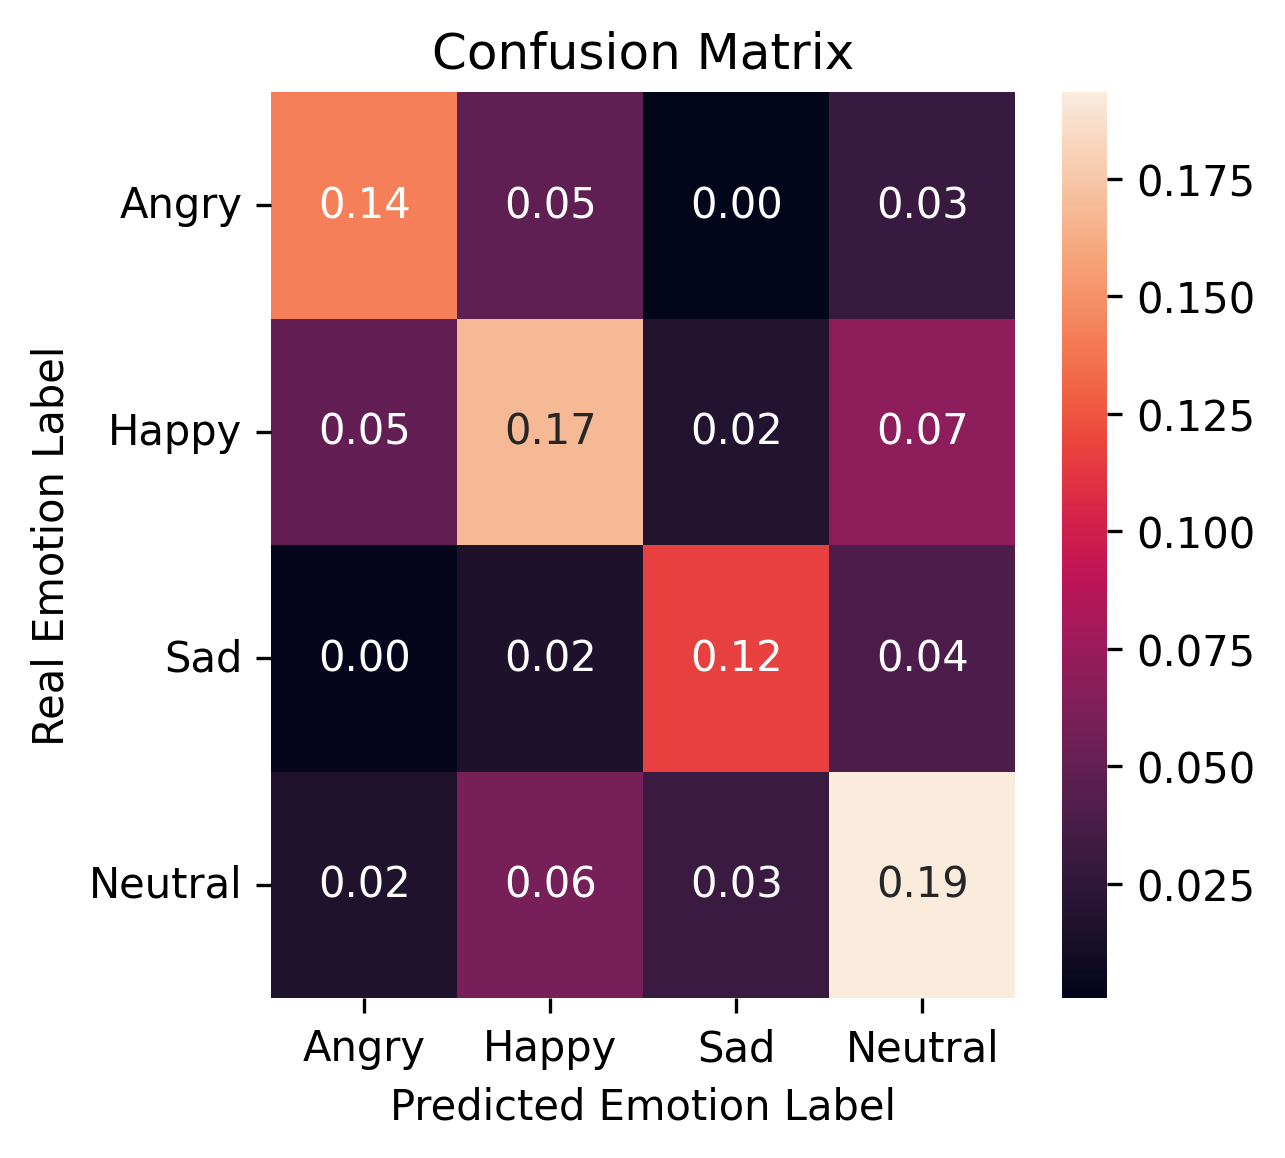

In [38]:
results = categorical_cross_validation(get_new_model, "Angry, Happy, Sad, Neutral", results)

Conflicts Removal With Durations

In [39]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df[df['Emotion'].isin({'angry', 'neutral', 'sad', 'happy', 'excited'})]
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df = df.set_index('File')
df['Valence'] = df['Valence'].apply(lambda x: x if x <= 5 else 5)

df = df[((df['Activation'] >= 2.5)
        & (df['Valence'] >= 3)
        & (df['Dominance'] >= 2.5)
        ) | (df['Emotion'] != 'happy')]

df = df[((df['Activation'] >= 1.5)
        & (df['Valence'] <= 2.5)
        & (df['Dominance'] <= 3.5)
        ) | (df['Emotion'] != 'sad')]

df = df[((df['Activation'] >= 3)
        & (df['Valence'] <= 4.5)
        ) | (df['Emotion'] != 'angry')]

df = df[((df['Activation'] >= 1) & (df['Activation'] < 4)
        & (df['Valence'] >= 2.5)
        & (df['Dominance'] > 2)
        ) | (df['Emotion'] != 'neutral')]

df = df[df["Duration"] >= 2]

print(f"Male Number of Data: {len(df[df['Gender'] == 'Male'])}")
print(f"Female Number of Data: {len(df[df['Gender'] == 'Female'])}")
print(f"Total Number of Audio Files: {df.shape[0]}")
print(df.groupby(['Emotion']).agg({'Activation': ['mean'], 'Valence': ['mean'], 'Dominance': ['mean']}))
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

Male Number of Data: 1756
Female Number of Data: 1591
Total Number of Audio Files: 3347
        Activation   Valence Dominance
              mean      mean      mean
Emotion                               
angry     3.865258  1.832395  4.096009
happy     3.546173  3.993541  3.426157
neutral   2.788662  3.009868  3.016146
sad       2.484163  2.048013  2.649824


Emotion
                     count
Emotion Emotion_Id        
angry   0              710
happy   1             1045
neutral 3              929
sad     2              663

Accuracy of fold 1: 63.58%
Accuracy of fold 2: 63.43%
Accuracy of fold 3: 61.73%
Accuracy of fold 4: 62.63%
Accuracy of fold 5: 63.08%

Metric             Value
-----------------  -----------
Accuracy           62.89+-0.67
F1 score macro     63.76
Precision          63.66
Recall             63.9
Matthews corrcoef  0.5


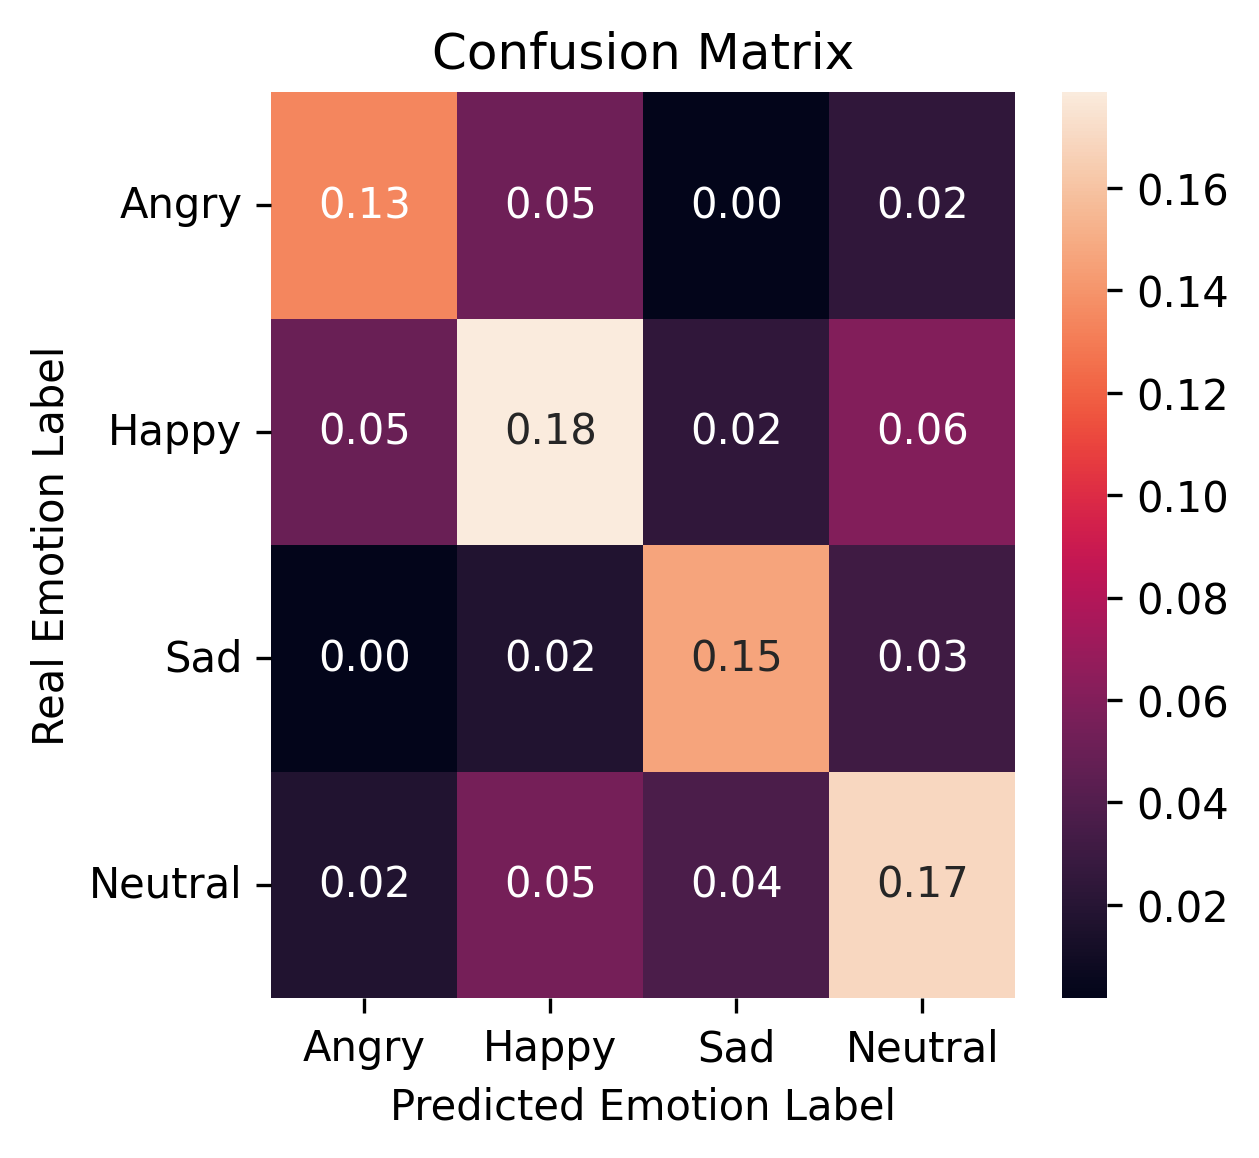

In [40]:
results = categorical_cross_validation(get_new_model, "Angry, Happy, Sad, Neutral", results)

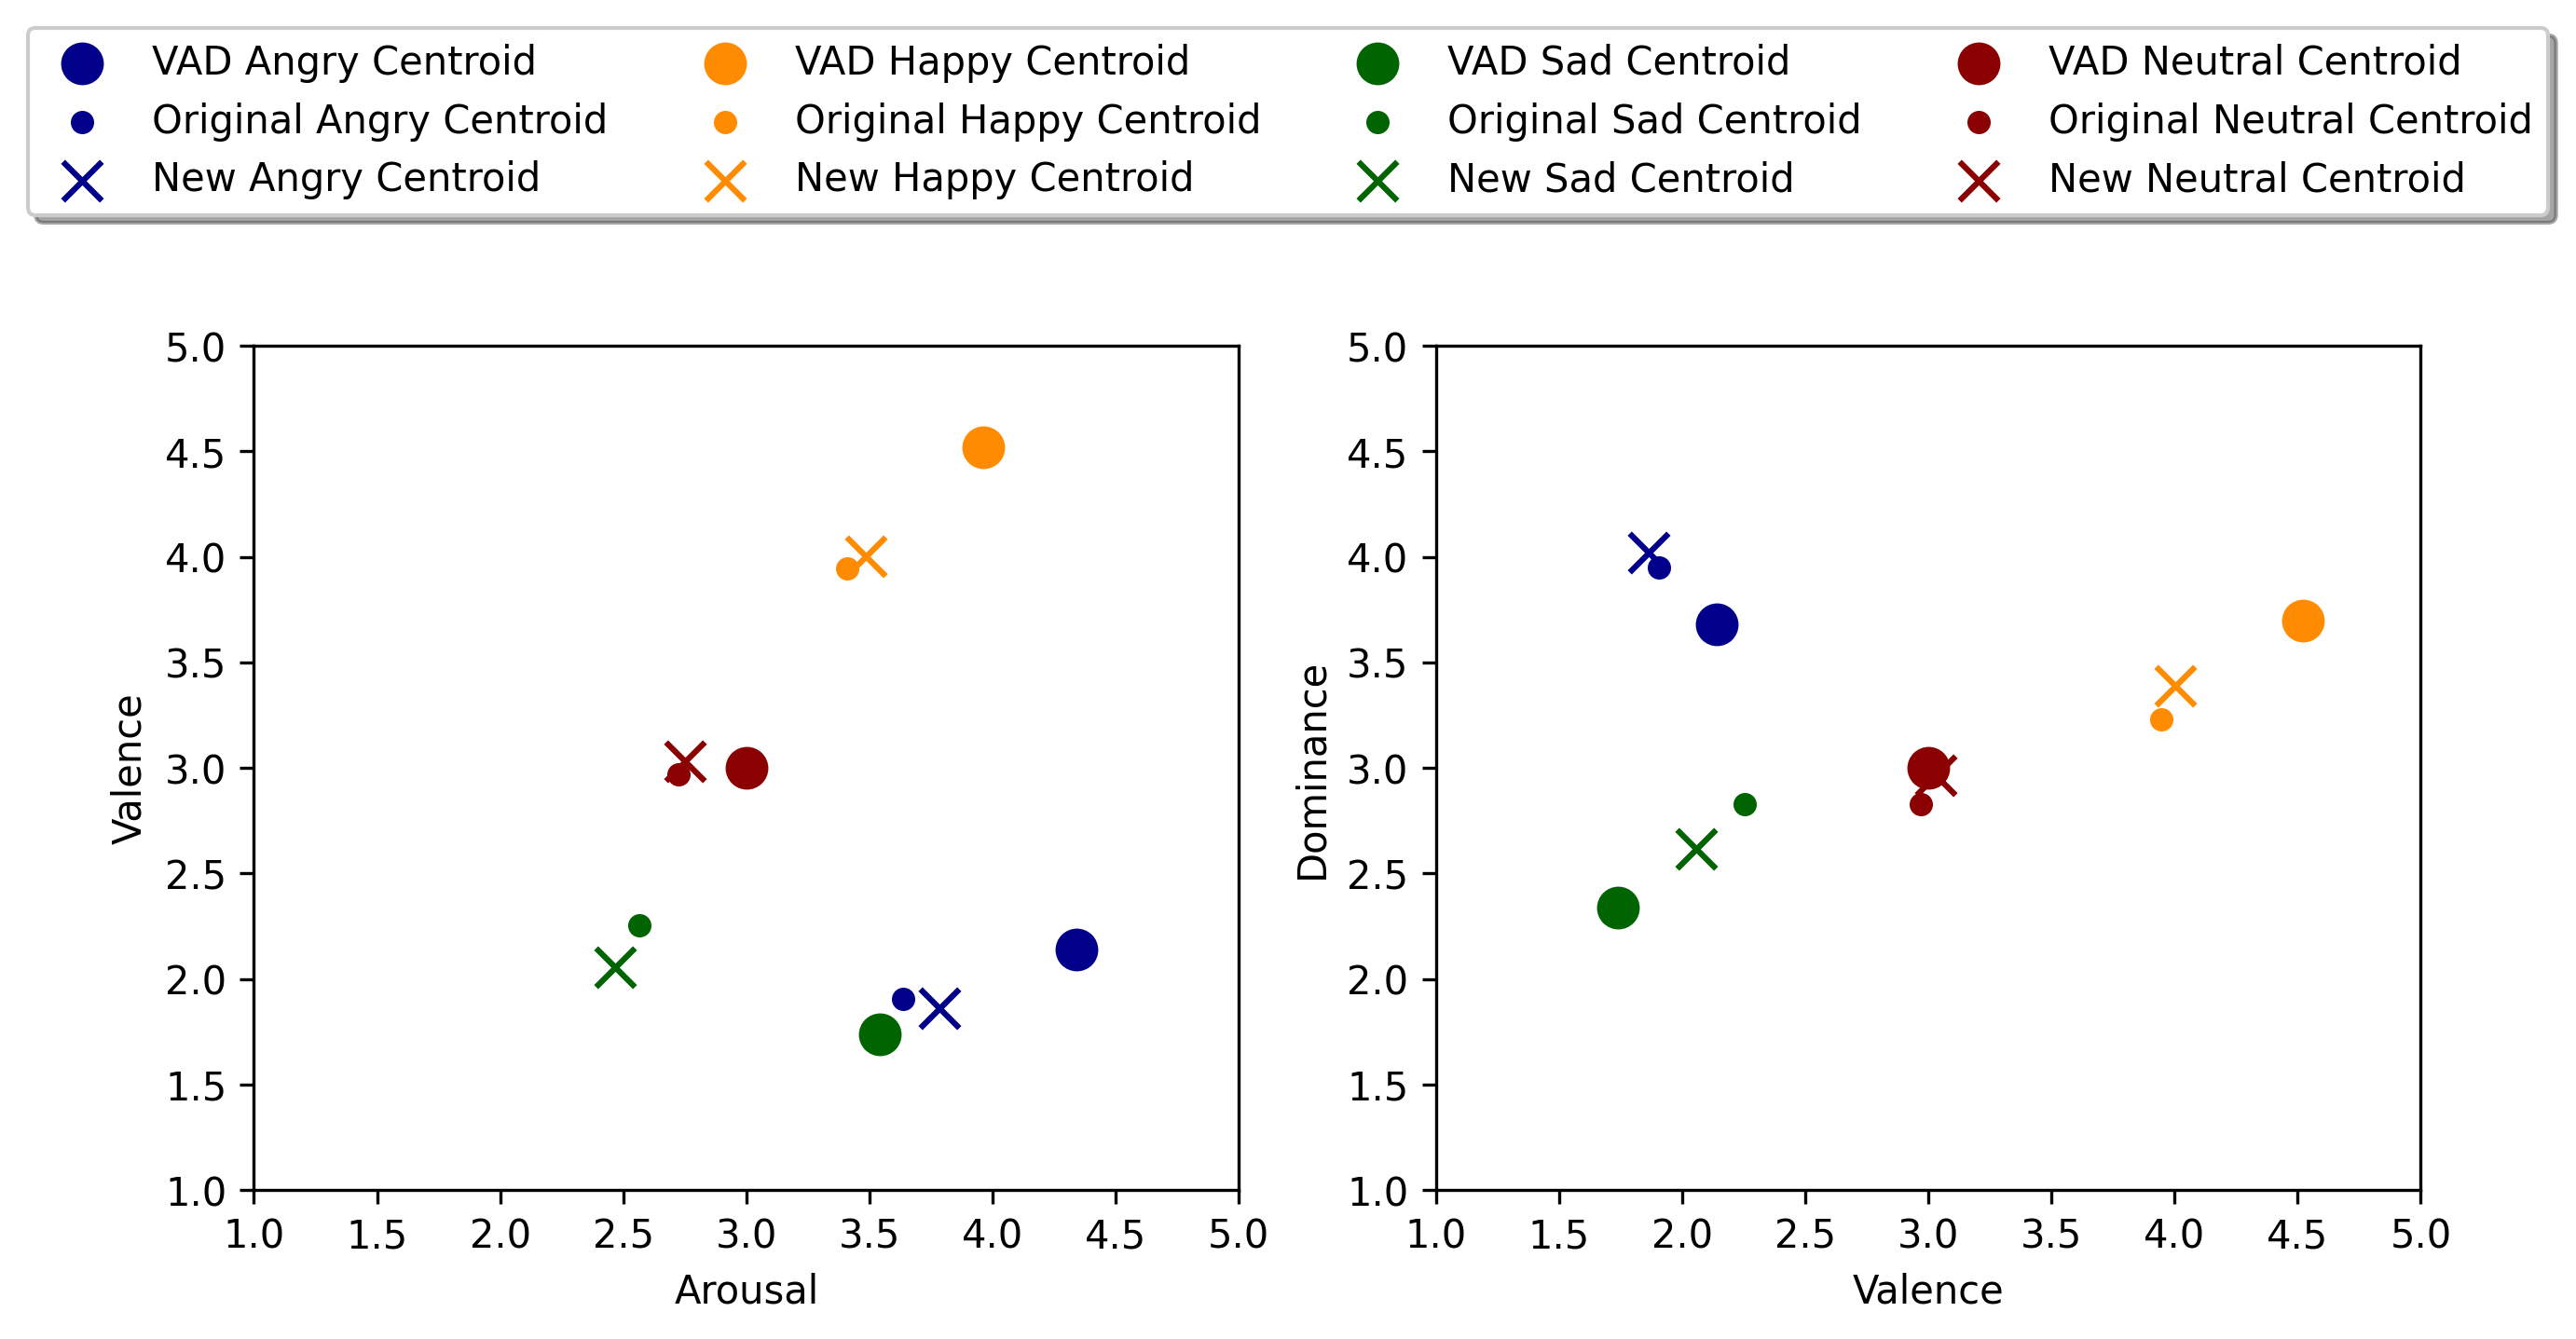

In [27]:
n_centroids = []
for i, emotion in enumerate(['angry', 'happy', 'sad', 'neutral']):
    df_temp = df[df['Emotion'] == emotion]
    n_centroids.append(df_temp.iloc[:,6:9].mean(axis=0).values)

# fig = plt.figure(figsize=(4, 4))
# ax = fig.add_subplot(projection='3d')
# ax.set_xlabel("Arousal")
# ax.set_ylabel("Valence")
# ax.set_zlabel("Dominance")
# ax.set_xticks(np.arange(1, 5.5, 0.5), labels=['1','','2','','3','','4','','5'])
# ax.set_yticks(np.arange(1, 5.5, 0.5), labels=['1','','2','','3','','4','','5'])
# ax.set_zticks(np.arange(1, 5.5, 0.5), labels=['1','','2','','3','','4','','5'])
# ax.set_xlim(1, 5)
# ax.set_ylim(1, 5)
# ax.set_zlim(1, 5)
# for i, emotion in enumerate(['angry', 'happy', 'sad', 'neutral']):
#     ax.scatter(centroids[i][1],centroids[i][0],centroids[i][2], marker='X', label=f"Previous {emotion.title()} Centroid", color=f"dark{colors[i]}", s=100)
#     ax.plot([centroids[i][1]]*2,[centroids[i][0]]*2, [1, centroids[i][2]], color=f"dark{colors[i]}", linewidth=0.8)
#     ax.scatter(n_centroids[i][1],n_centroids[i][0],n_centroids[i][2], label=f"{emotion.title()} Centroid", color=f"dark{colors[i]}", s=100)
#     ax.plot([n_centroids[i][1]]*2,[n_centroids[i][0]]*2, [1, n_centroids[i][2]], color=f"dark{colors[i]}", linewidth=0.8)

# ax.view_init(15, -50)
# plt.legend(loc='upper left', bbox_to_anchor=(1.2, 0.75),
#         ncol=1, fancybox=True, shadow=True)
# plt.show()

fig = plt.figure(figsize=(10, 4))
spec = fig.add_gridspec(1, 2)

ax1 = fig.add_subplot(spec[0, 0])
ax1.set_xlim([1, 5])
ax1.set_ylim([1, 5])
ax1.set_xlabel("Arousal")
ax1.set_ylabel("Valence")
ax2 = fig.add_subplot(spec[0, 1])
ax2.set_xlim([1, 5])
ax2.set_ylim([1, 5])
ax2.set_xlabel("Valence")
ax2.set_ylabel("Dominance")

for i, emotion in enumerate(['angry', 'happy', 'sad', 'neutral']):
    ax1.scatter(vad_centroids[i][1],vad_centroids[i][0], marker='o', label=f"VAD {emotion.title()} Centroid", color=f"dark{colors[i]}", s=100)
    ax2.scatter(vad_centroids[i][0],vad_centroids[i][2], marker='o', label=f"VAD {emotion.title()} Centroid", color=f"dark{colors[i]}", s=100)
    ax1.scatter(centroids[i][1],centroids[i][0], marker='.', label=f"Original {emotion.title()} Centroid", color=f"dark{colors[i]}", s=100)
    ax2.scatter(centroids[i][0],centroids[i][2], marker='.', label=f"Original {emotion.title()} Centroid", color=f"dark{colors[i]}", s=100)
    ax1.scatter(n_centroids[i][1],n_centroids[i][0], marker='x', label=f"New {emotion.title()} Centroid", color=f"dark{colors[i]}", s=100)
    ax2.scatter(n_centroids[i][0],n_centroids[i][2], marker='x', label=f"New {emotion.title()} Centroid", color=f"dark{colors[i]}", s=100)
ax2.legend(loc='upper center', bbox_to_anchor=(-0.15, 1.4),
          ncol=4, fancybox=True, shadow=True)
plt.show()

In [28]:
%config InteractiveShell.ast_node_interactivity = 'all'

Angry, Happy, Sad, Neutral

Number of Audio Files: 5531


Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
happy   1             1636
sad     2             1084
neutral 3             1708

Accuracy of fold 1: 59.71%
Accuracy of fold 2: 60.94%
Accuracy of fold 3: 63.11%
Accuracy of fold 4: 60.58%
Accuracy of fold 5: 59.13%

Metric             Value
-----------------  -----------
Accuracy           60.69+-1.37
F1 score macro     61.32
Precision          61.66
Recall             61.19
Matthews corrcoef  0.47


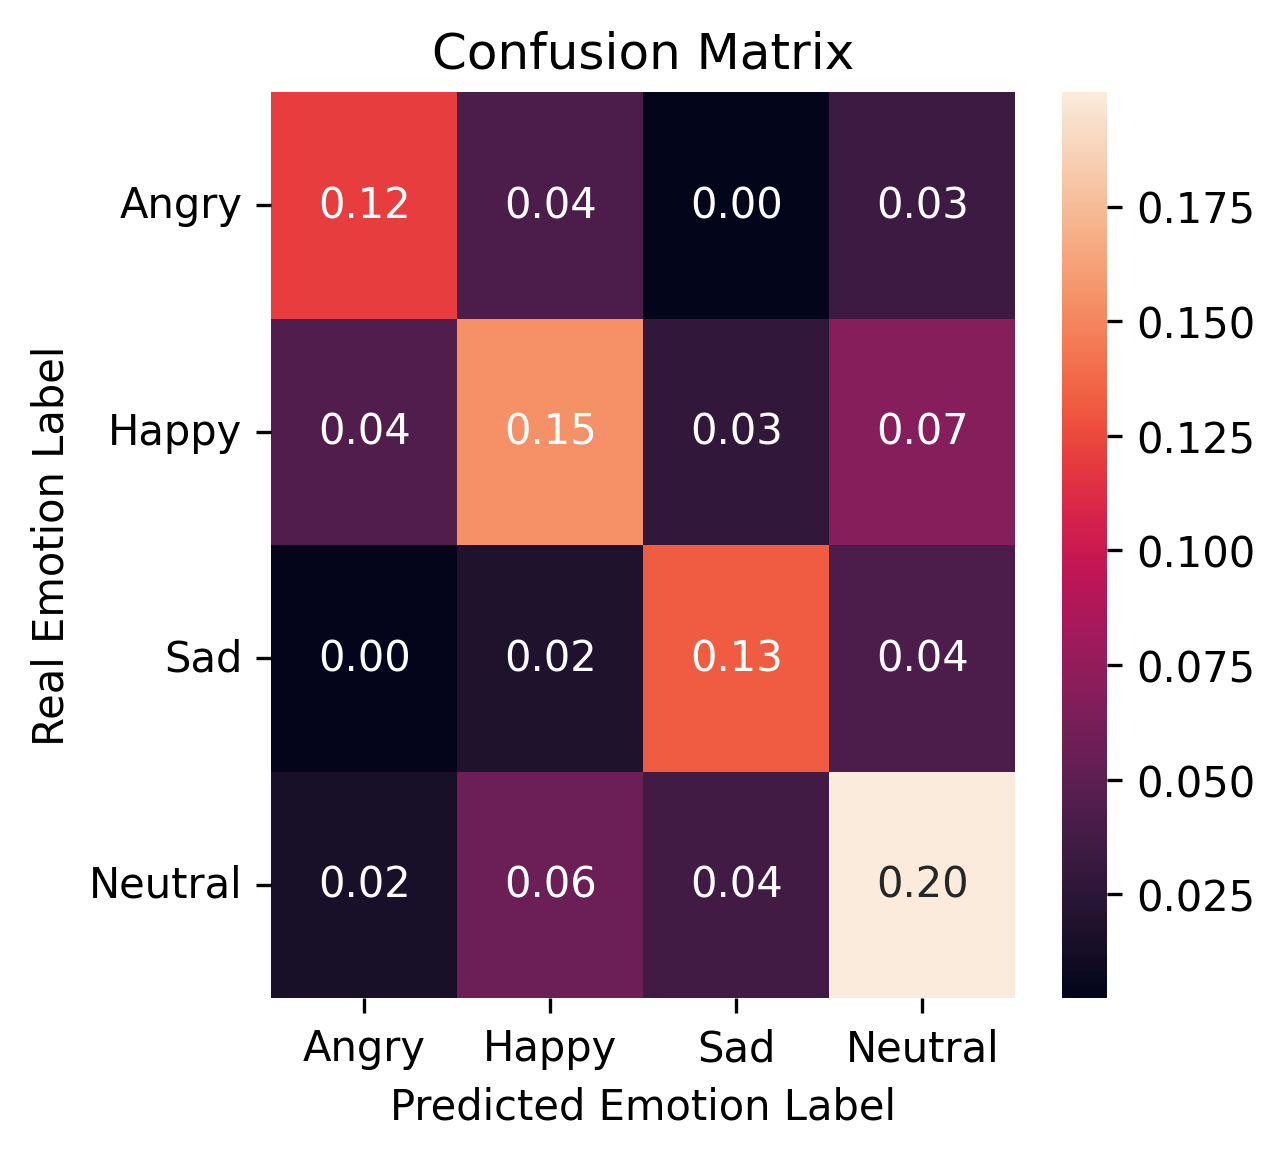

In [41]:
results = []
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'sad', 'happy', 'excited'})]
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
def get_new_model():
    return XGBClassifier(random_state=1, colsample_bytree=0.8, colsample_bylevel=0.8, subsample=0.9,
        n_estimators=512, max_depth=8, learning_rate=0.1, n_jobs=-1)
print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}).sort_values("Emotion_Id")

results = categorical_cross_validation(get_new_model, "Angry, Happy, Sad, Neutral", results)

Angry+Sad, Neutral+Happy

Number of Audio Files: 5531


Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
happy   1             1636
neutral 1             1708
sad     0             1084

Accuracy of fold 1: 73.53%
Accuracy of fold 2: 73.42%
Accuracy of fold 3: 73.15%
Accuracy of fold 4: 75.32%
Accuracy of fold 5: 73.69%

Metric             Value
-----------------  -----------
Accuracy           73.82+-0.77
F1 score macro     71.7
Precision          72.9
Recall             71.21
Matthews corrcoef  0.44


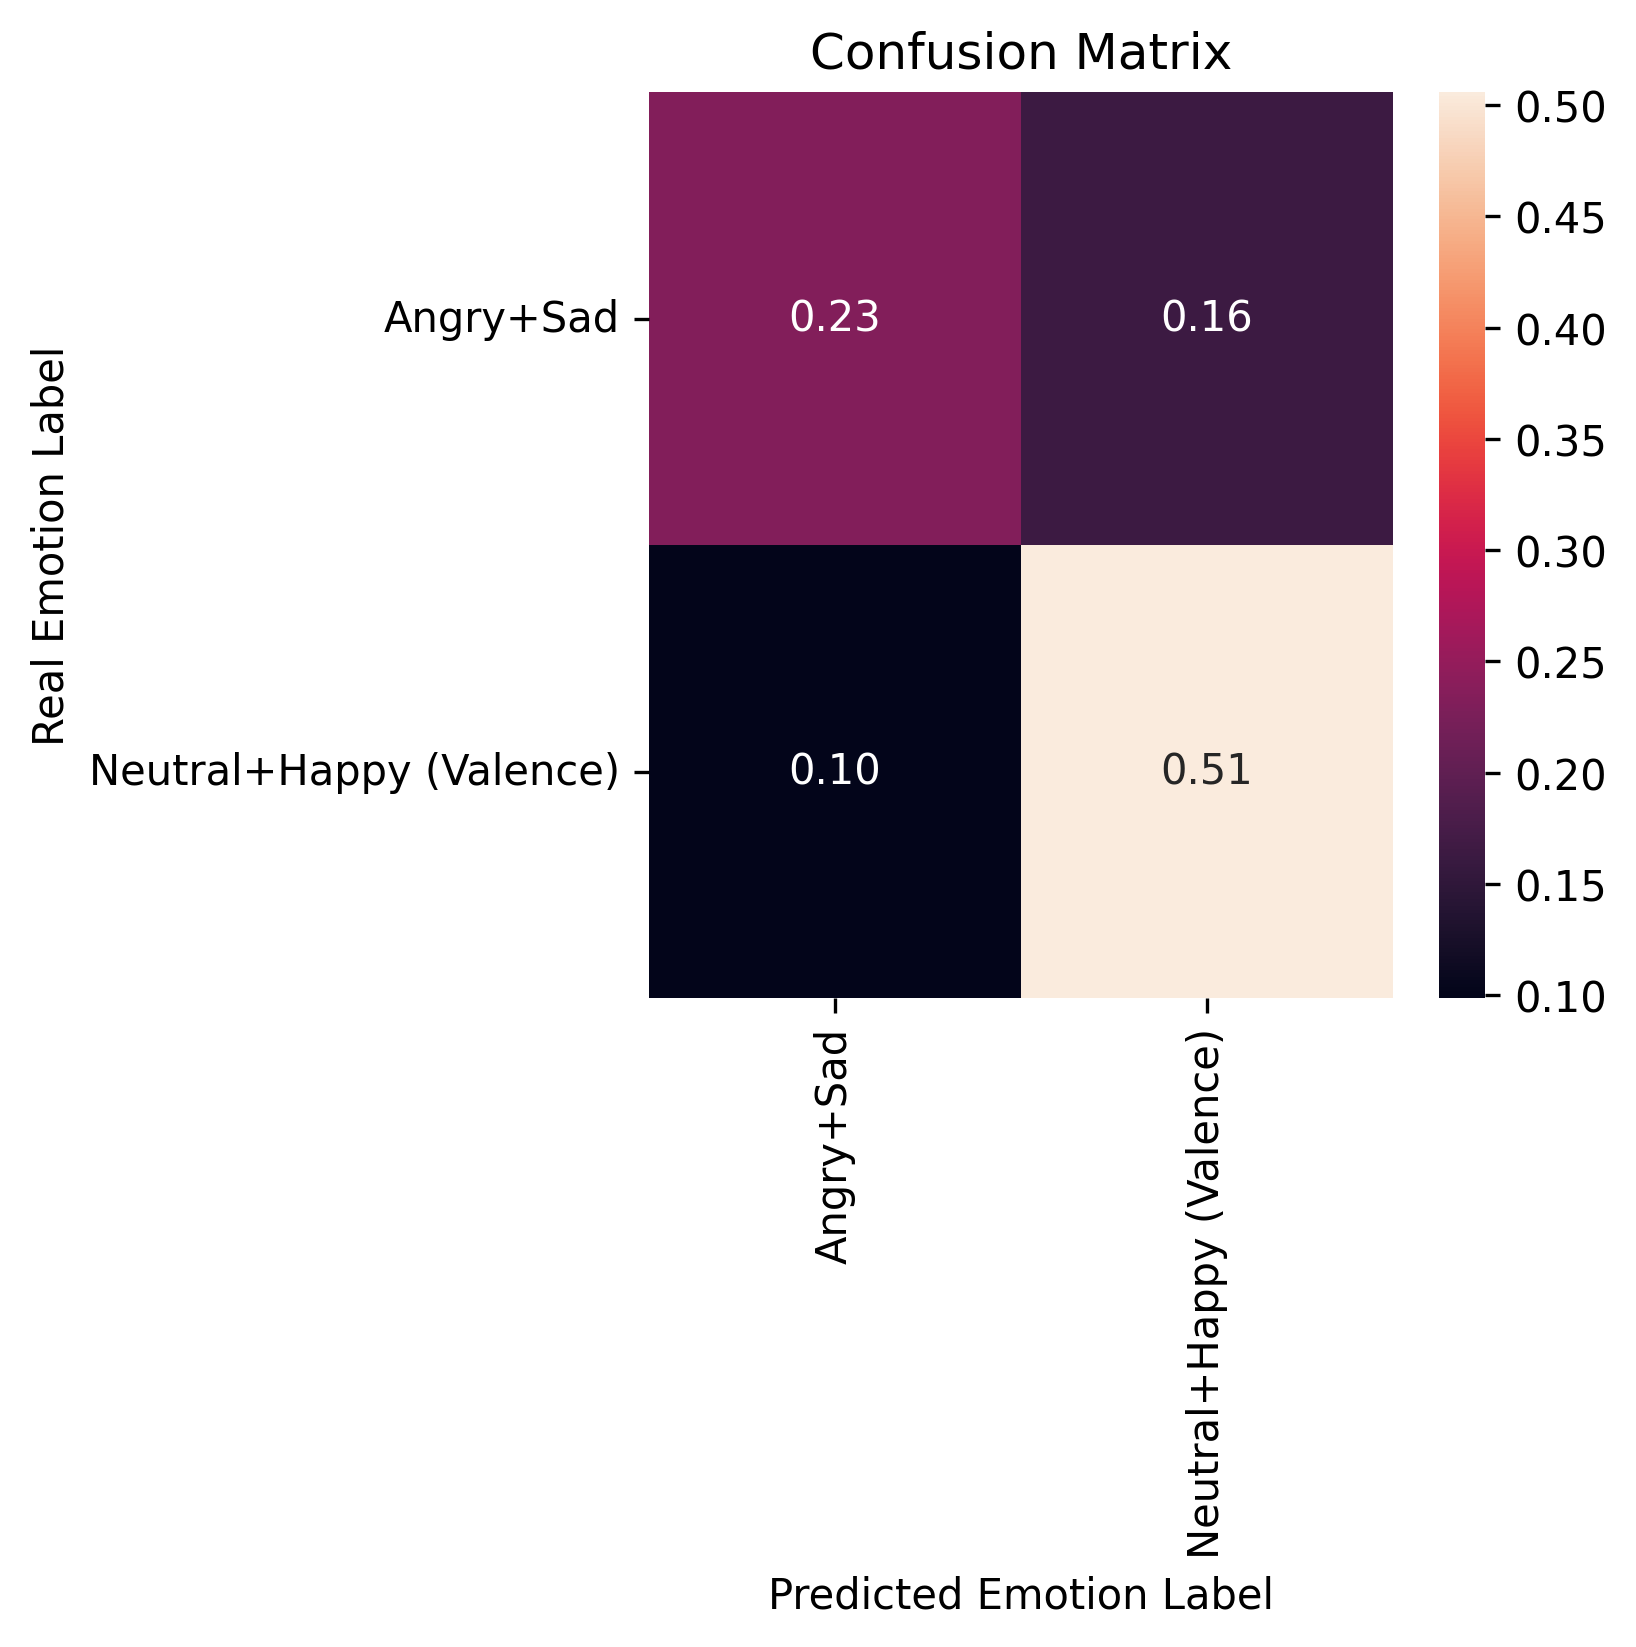

In [42]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'
df.loc[df['Emotion_Id'] == 2, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

results = categorical_cross_validation(get_new_model, "Angry+Sad, Neutral+Happy (Valence)", results)

Angry, Happy, Sad

Number of Audio Files: 3823


Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
happy   1             1636
sad     2             1084

Accuracy of fold 1: 71.9%
Accuracy of fold 2: 71.37%
Accuracy of fold 3: 68.89%
Accuracy of fold 4: 69.63%
Accuracy of fold 5: 73.17%

Metric             Value
-----------------  -----------
Accuracy           70.99+-1.55
F1 score macro     71.37
Precision          71.38
Recall             71.42
Matthews corrcoef  0.56


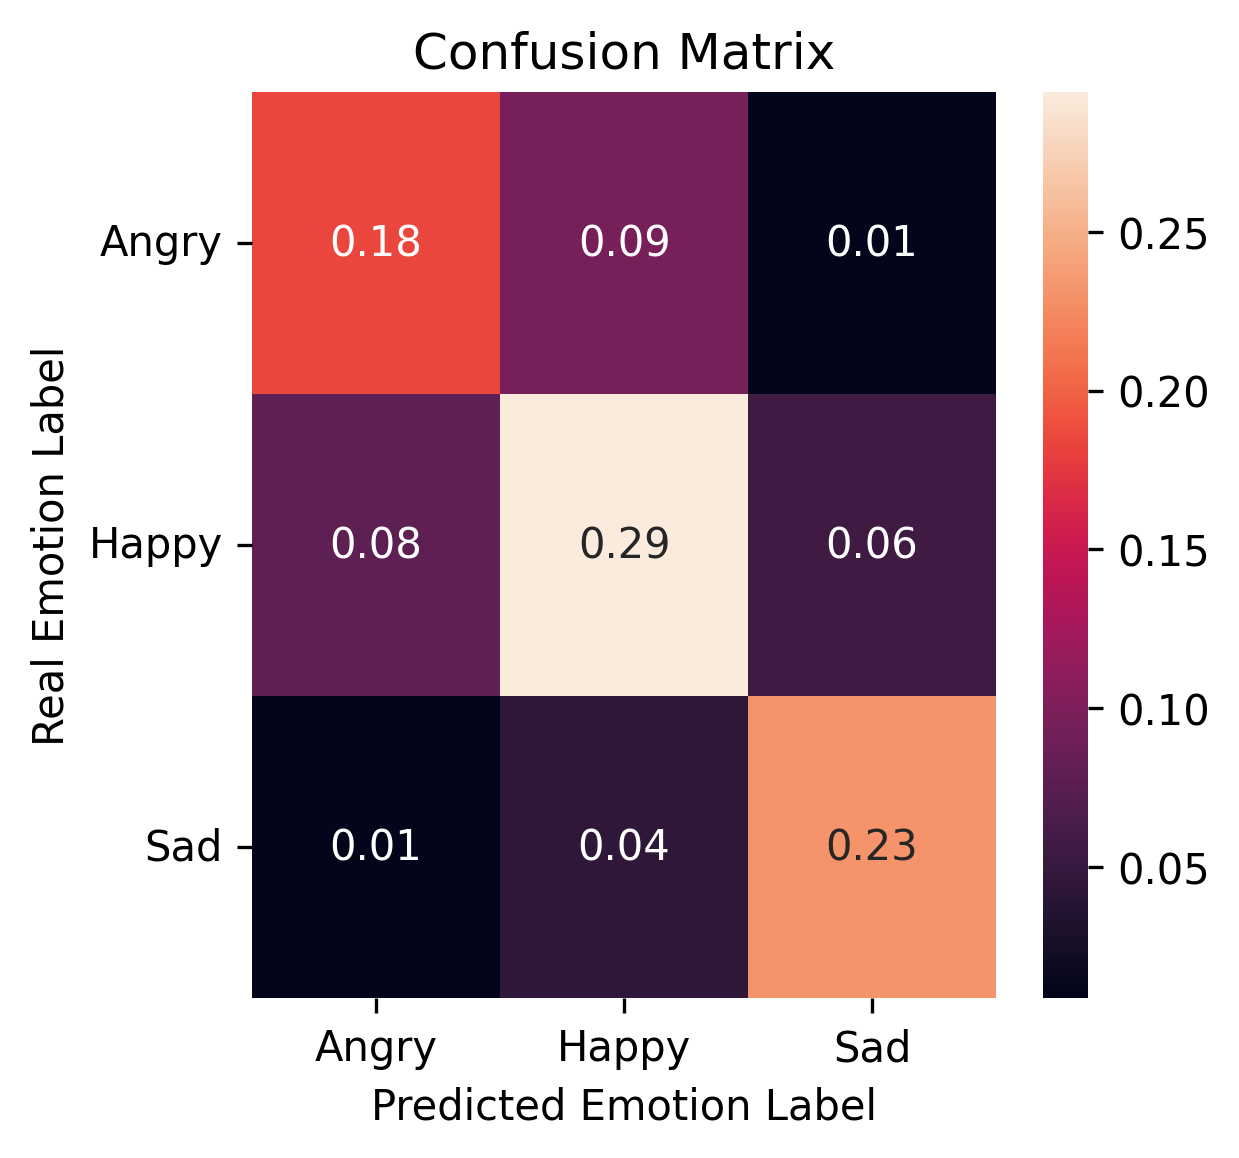

In [43]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)

df = df.set_index('File')
df = df[df['Emotion'].isin({'angry',  'happy', 'excited', 'sad'})]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

results = categorical_cross_validation(get_new_model, "Angry, Happy, Sad", results)

Angry, Happy, Neutral

Number of Audio Files: 4447


Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
happy   1             1636
neutral 2             1708

Accuracy of fold 1: 65.28%
Accuracy of fold 2: 63.82%
Accuracy of fold 3: 65.92%
Accuracy of fold 4: 63.55%
Accuracy of fold 5: 62.88%

Metric             Value
-----------------  -----------
Accuracy           64.29+-1.13
F1 score macro     63.81
Precision          64.41
Recall             63.6
Matthews corrcoef  0.45


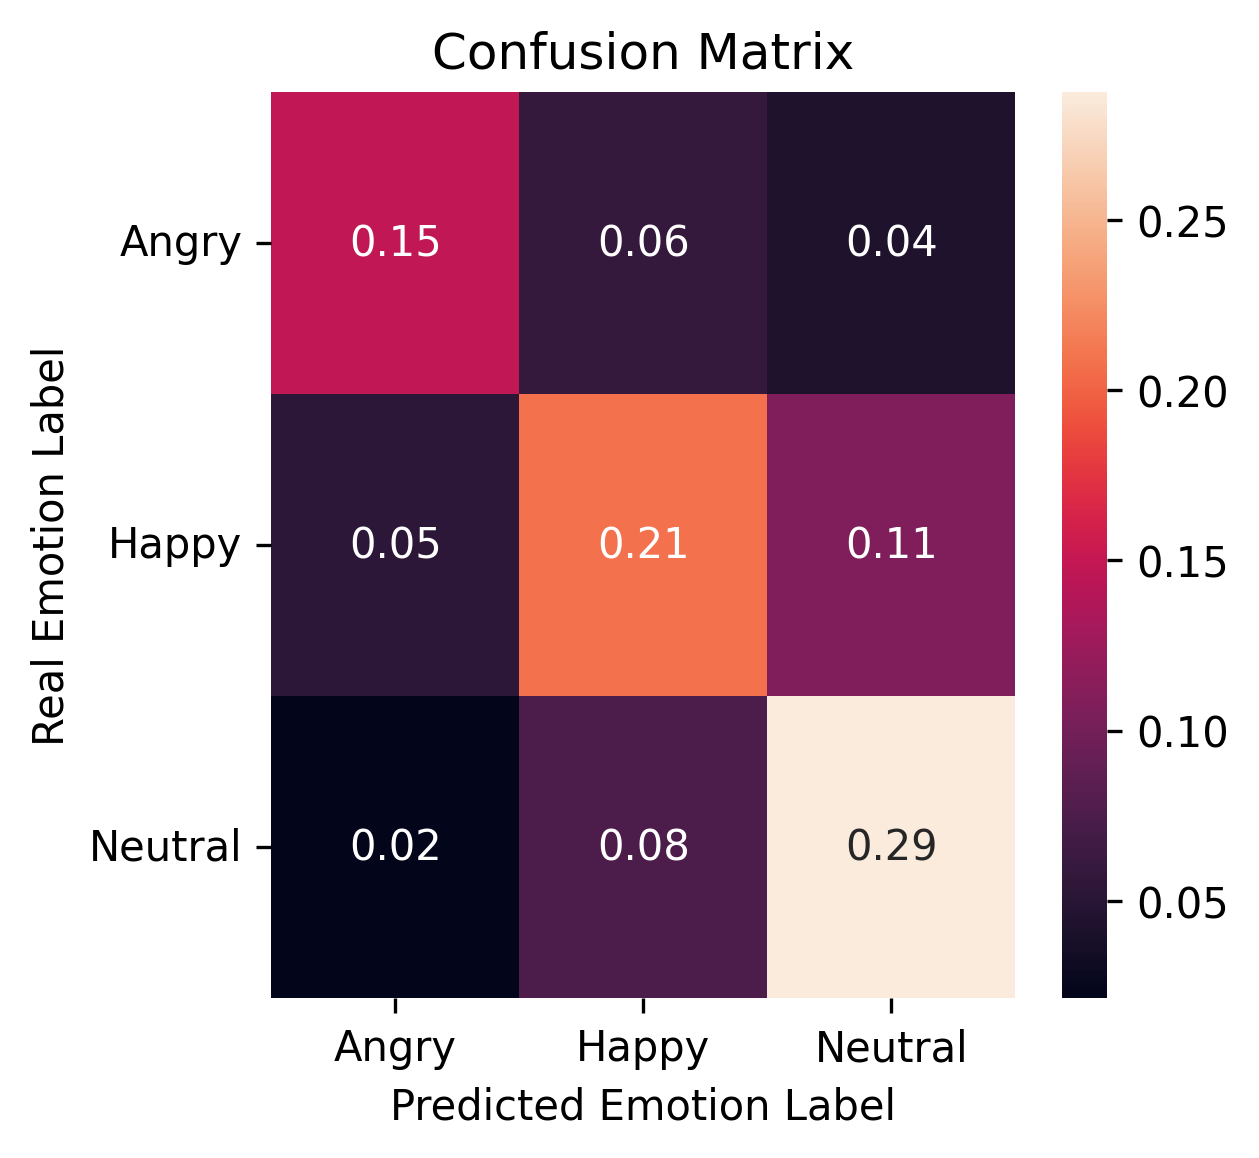

In [44]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)

df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 2
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

results = categorical_cross_validation(get_new_model, "Angry, Happy, Neutral", results)

Sad, Happy, Neutral

Number of Audio Files: 4428


Emotion
                     count
Emotion Emotion_Id        
happy   1             1636
neutral 2             1708
sad     0             1084

Accuracy of fold 1: 66.82%
Accuracy of fold 2: 68.74%
Accuracy of fold 3: 64.79%
Accuracy of fold 4: 64.97%
Accuracy of fold 5: 63.39%

Metric             Value
-----------------  -----------
Accuracy           65.74+-1.85
F1 score macro     65.85
Precision          65.94
Recall             65.86
Matthews corrcoef  0.48


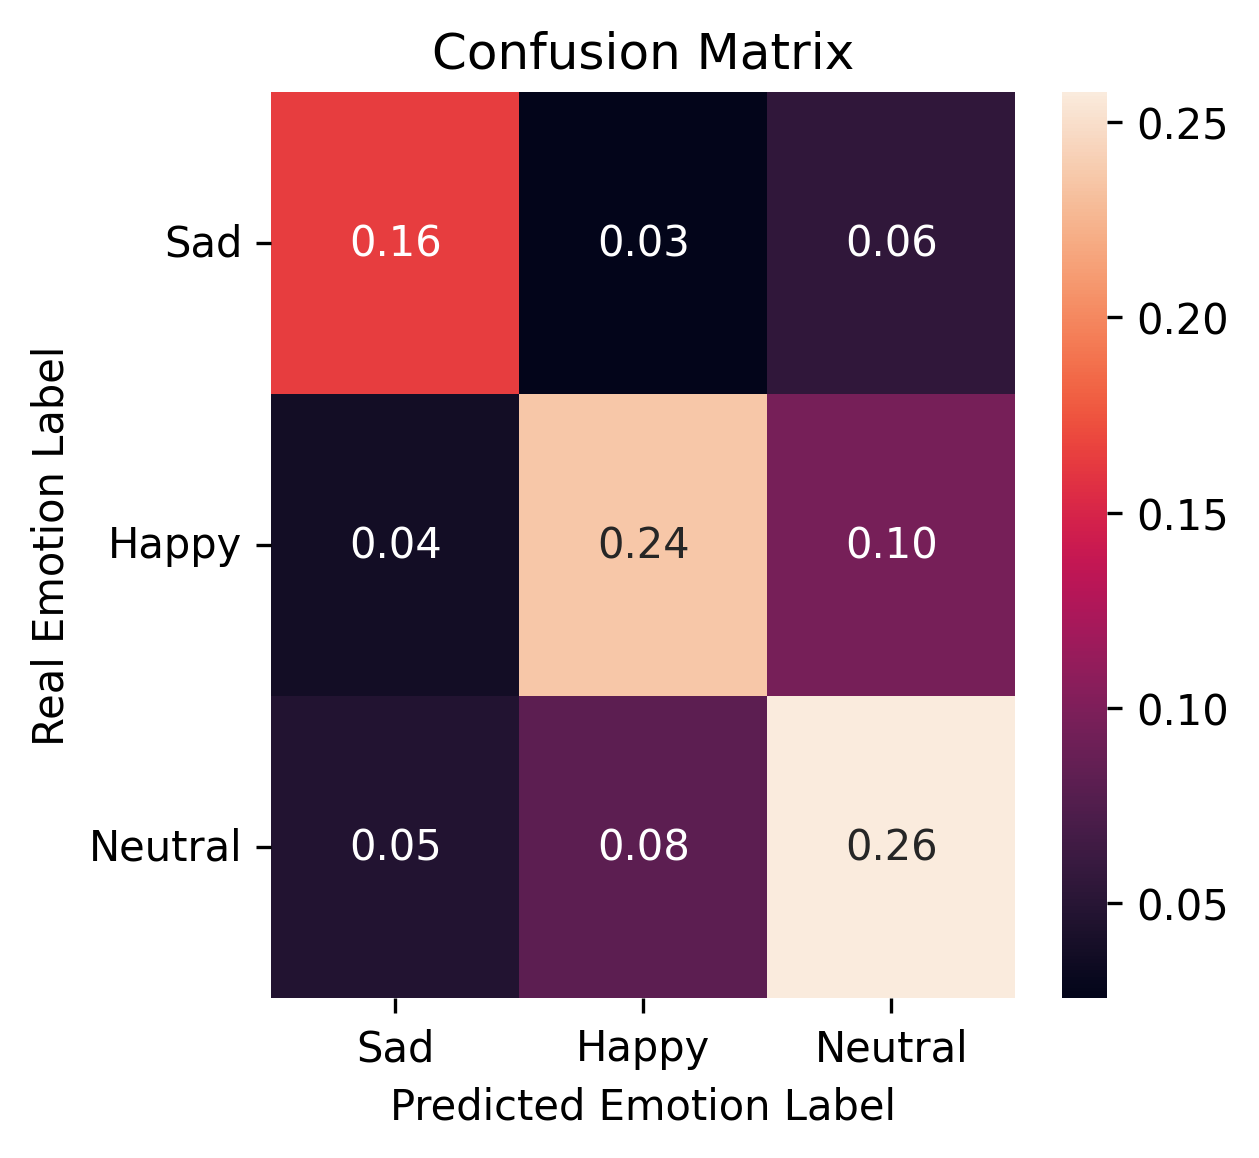

In [45]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)

df = df.set_index('File')
df = df[df['Emotion'].isin({'sad', 'neutral', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 2, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 2
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

results = categorical_cross_validation(get_new_model, "Sad, Happy, Neutral", results)

Angry, Sad, Neutral

Number of Audio Files: 3895


Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
neutral 1             1708
sad     2             1084

Accuracy of fold 1: 73.68%
Accuracy of fold 2: 74.33%
Accuracy of fold 3: 76.25%
Accuracy of fold 4: 75.87%
Accuracy of fold 5: 75.74%

Metric             Value
-----------------  -----------
Accuracy           75.17+-0.99
F1 score macro     75.3
Precision          76.21
Recall             74.62
Matthews corrcoef  0.62


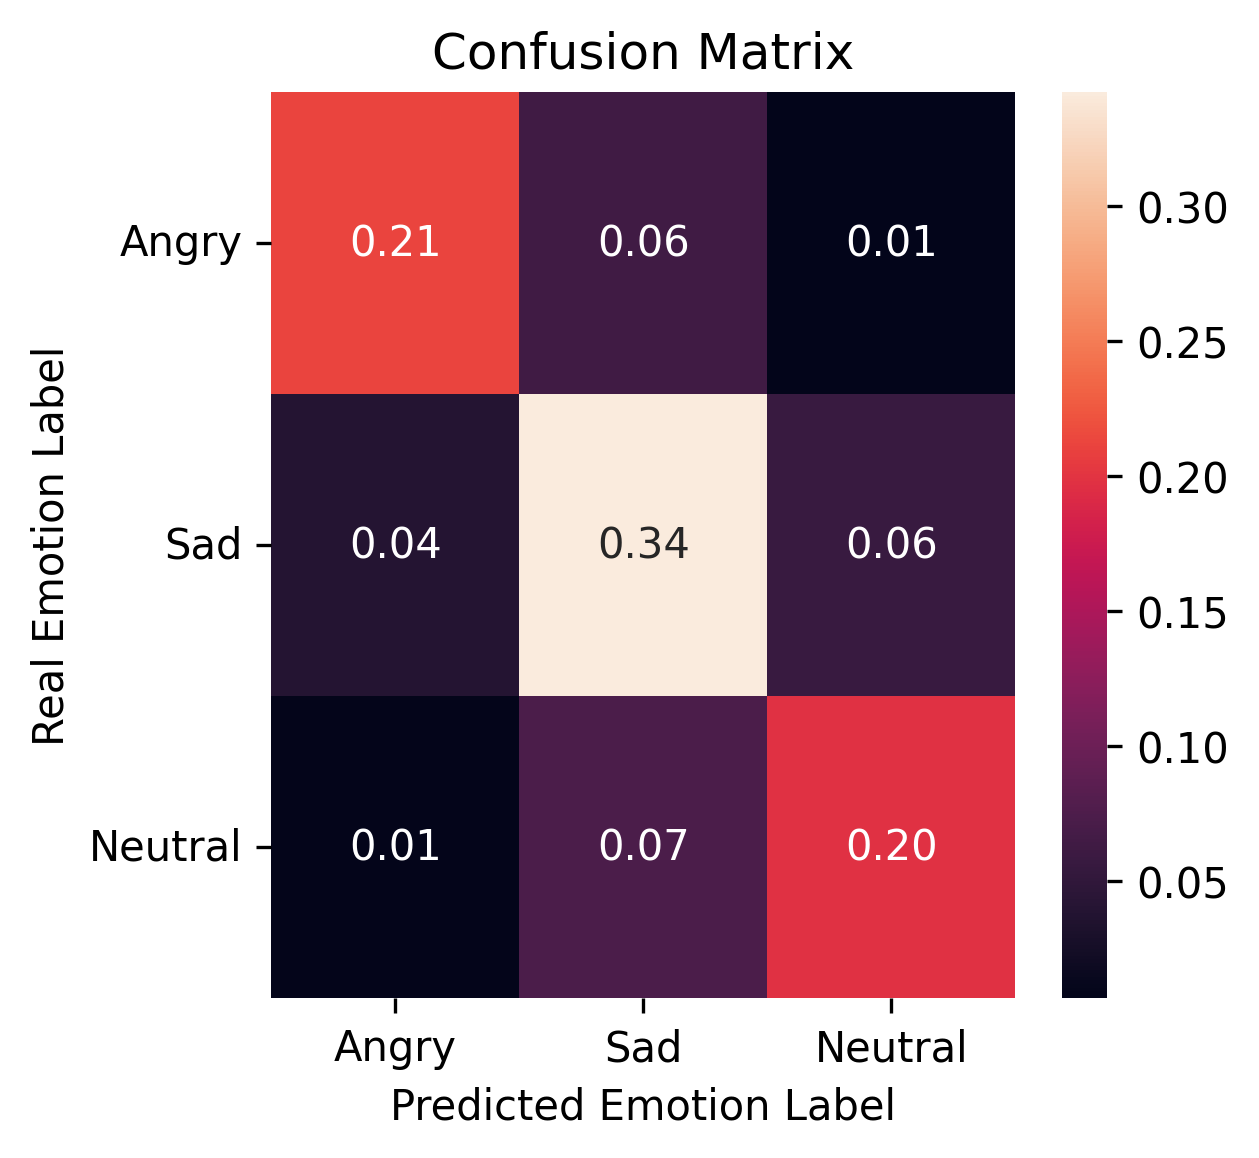

In [46]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)

df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'sad'})]
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

results = categorical_cross_validation(get_new_model, "Angry, Sad, Neutral", results)

Sad+Neutral, Happy+Angry (Arousal)

Number of Audio Files: 5531


Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
happy   0             1636
neutral 1             1708
sad     1             1084

Accuracy of fold 1: 77.78%
Accuracy of fold 2: 78.21%
Accuracy of fold 3: 76.76%
Accuracy of fold 4: 75.41%
Accuracy of fold 5: 78.03%

Metric             Value
-----------------  -----------
Accuracy           77.24+-1.04
F1 score macro     77.21
Precision          77.31
Recall             77.21
Matthews corrcoef  0.55


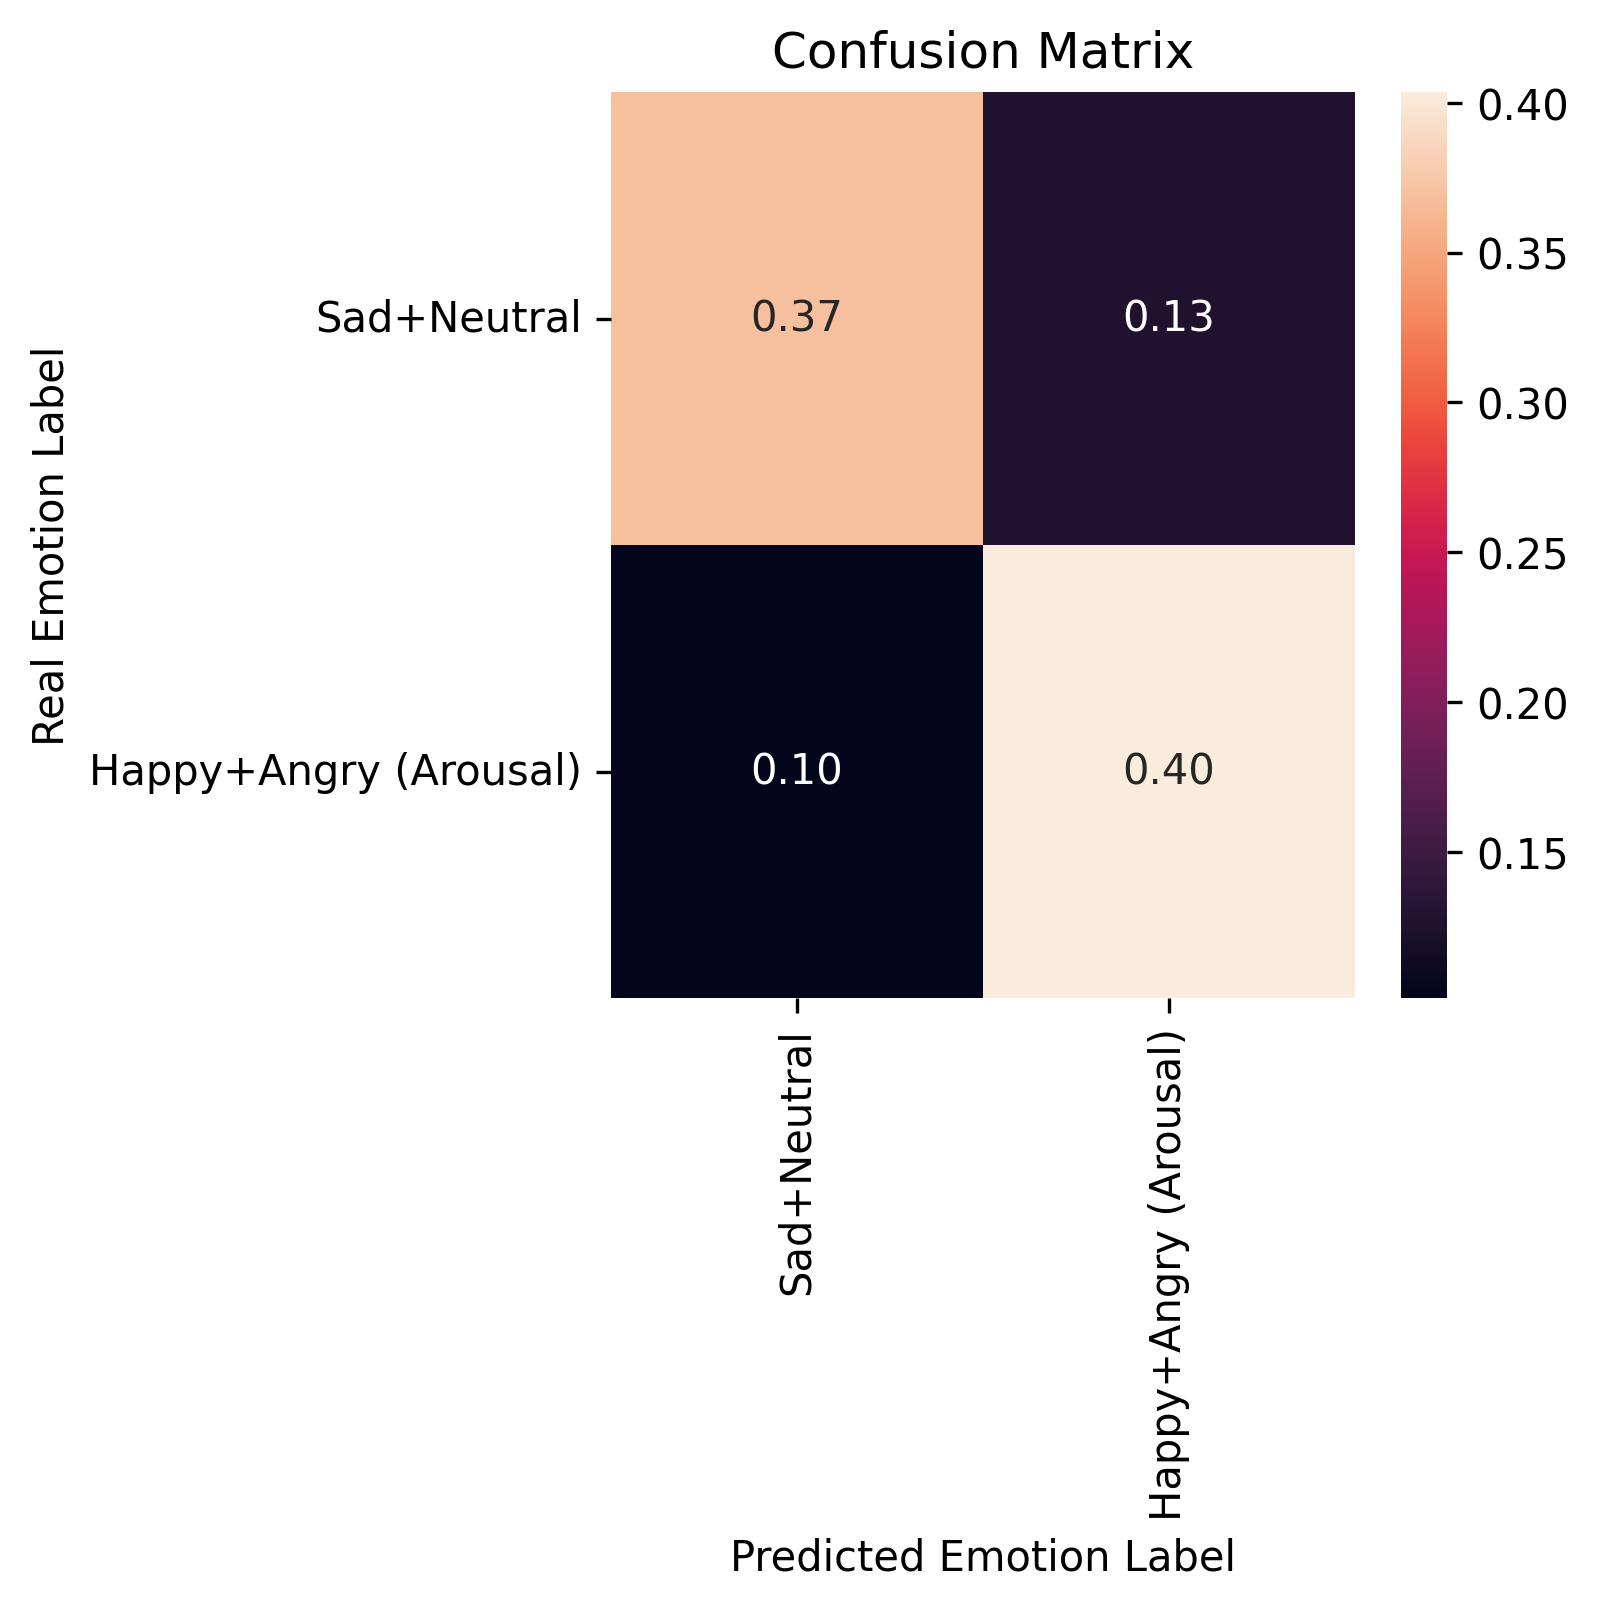

In [47]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)

df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'sad', 'happy', 'excited', 'neutral'})]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 1, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 2, 'Emotion_Id'] = 1
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 1
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

results = categorical_cross_validation(get_new_model, "Sad+Neutral, Happy+Angry (Arousal)", results)

Angry, Sad

Number of Audio Files: 2187


Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
sad     1             1084

Accuracy of fold 1: 92.47%
Accuracy of fold 2: 94.29%
Accuracy of fold 3: 91.08%
Accuracy of fold 4: 90.62%
Accuracy of fold 5: 91.53%

Metric             Value
-----------------  ---------
Accuracy           92.0+-1.3
F1 score macro     92.0
Precision          92.0
Recall             92.0
Matthews corrcoef  0.84


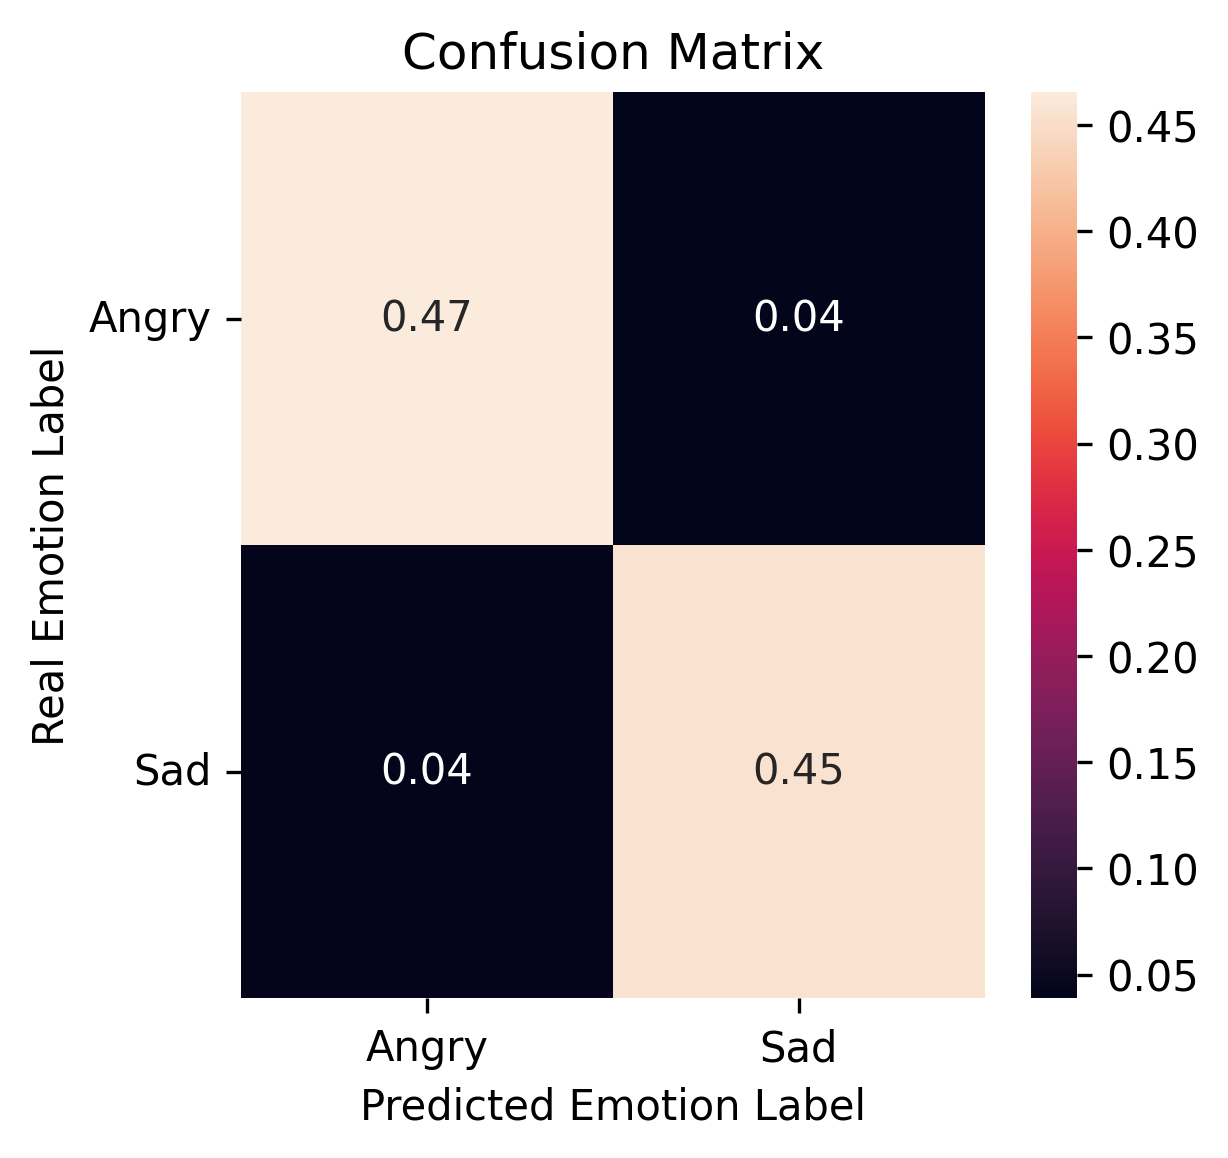

In [48]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)

df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'sad'})]
df.loc[df['Emotion_Id'] == 2, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

results = categorical_cross_validation(get_new_model, "Angry, Sad", results)

Angry, Neutral

Number of Audio Files: 2811


Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
neutral 1             1708

Accuracy of fold 1: 85.44%
Accuracy of fold 2: 82.74%
Accuracy of fold 3: 83.27%
Accuracy of fold 4: 85.77%
Accuracy of fold 5: 85.41%

Metric             Value
-----------------  -----------
Accuracy           84.53+-1.26
F1 score macro     83.49
Precision          84.25
Recall             82.98
Matthews corrcoef  0.67


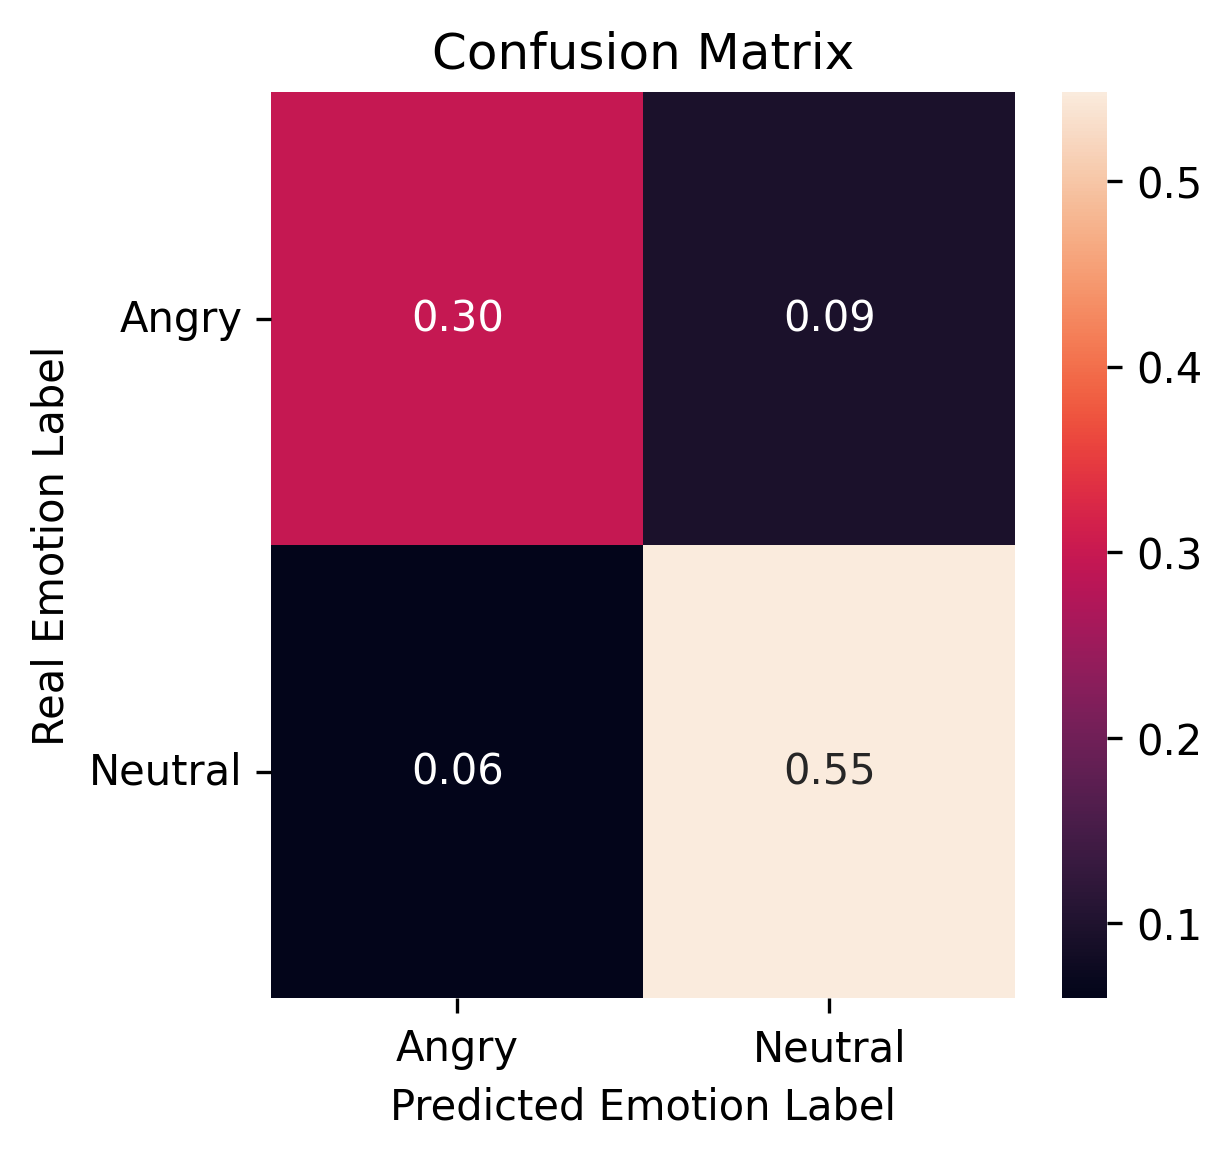

In [49]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)

df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral'})]
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

results = categorical_cross_validation(get_new_model, "Angry, Neutral", results)

Angry, Happy

Number of Audio Files: 2739


Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
happy   1             1636

Accuracy of fold 1: 75.55%
Accuracy of fold 2: 77.01%
Accuracy of fold 3: 74.27%
Accuracy of fold 4: 75.0%
Accuracy of fold 5: 76.05%

Metric             Value
-----------------  -----------
Accuracy           75.58+-0.93
F1 score macro     74.15
Precision          74.78
Recall             73.79
Matthews corrcoef  0.49


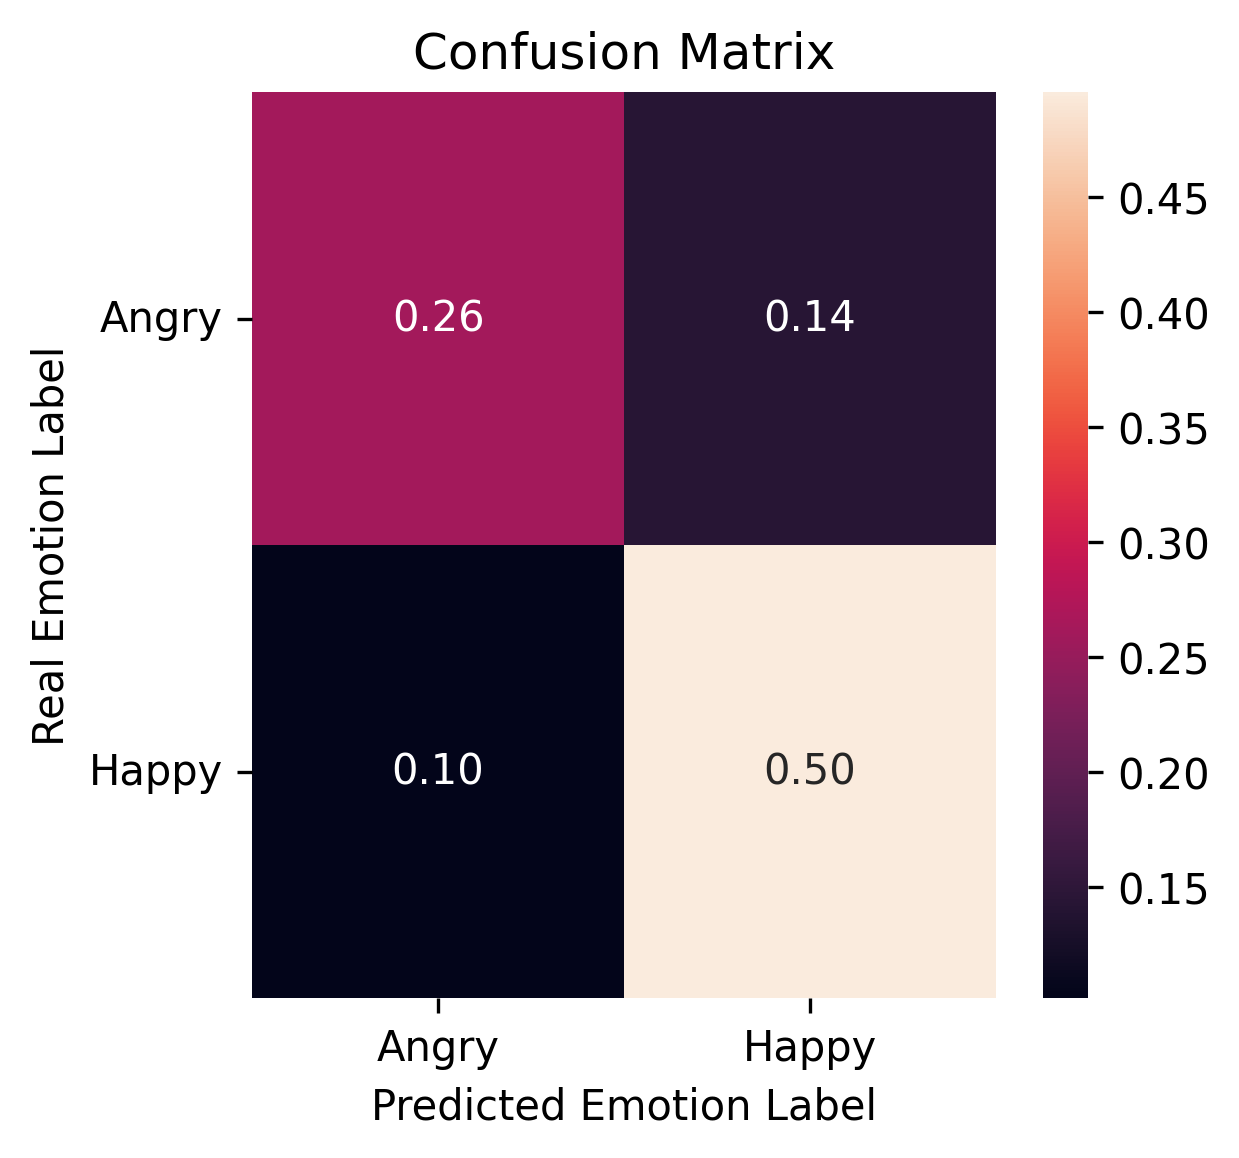

In [50]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)

df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

results = categorical_cross_validation(get_new_model, "Angry, Happy", results)

Sad, Neutral

Number of Audio Files: 2792


Emotion
                     count
Emotion Emotion_Id        
neutral 1             1708
sad     0             1084

Accuracy of fold 1: 80.86%
Accuracy of fold 2: 83.18%
Accuracy of fold 3: 81.0%
Accuracy of fold 4: 80.11%
Accuracy of fold 5: 79.93%

Metric             Value
-----------------  -----------
Accuracy           81.02+-1.16
F1 score macro     79.7
Precision          80.29
Recall             79.29
Matthews corrcoef  0.6


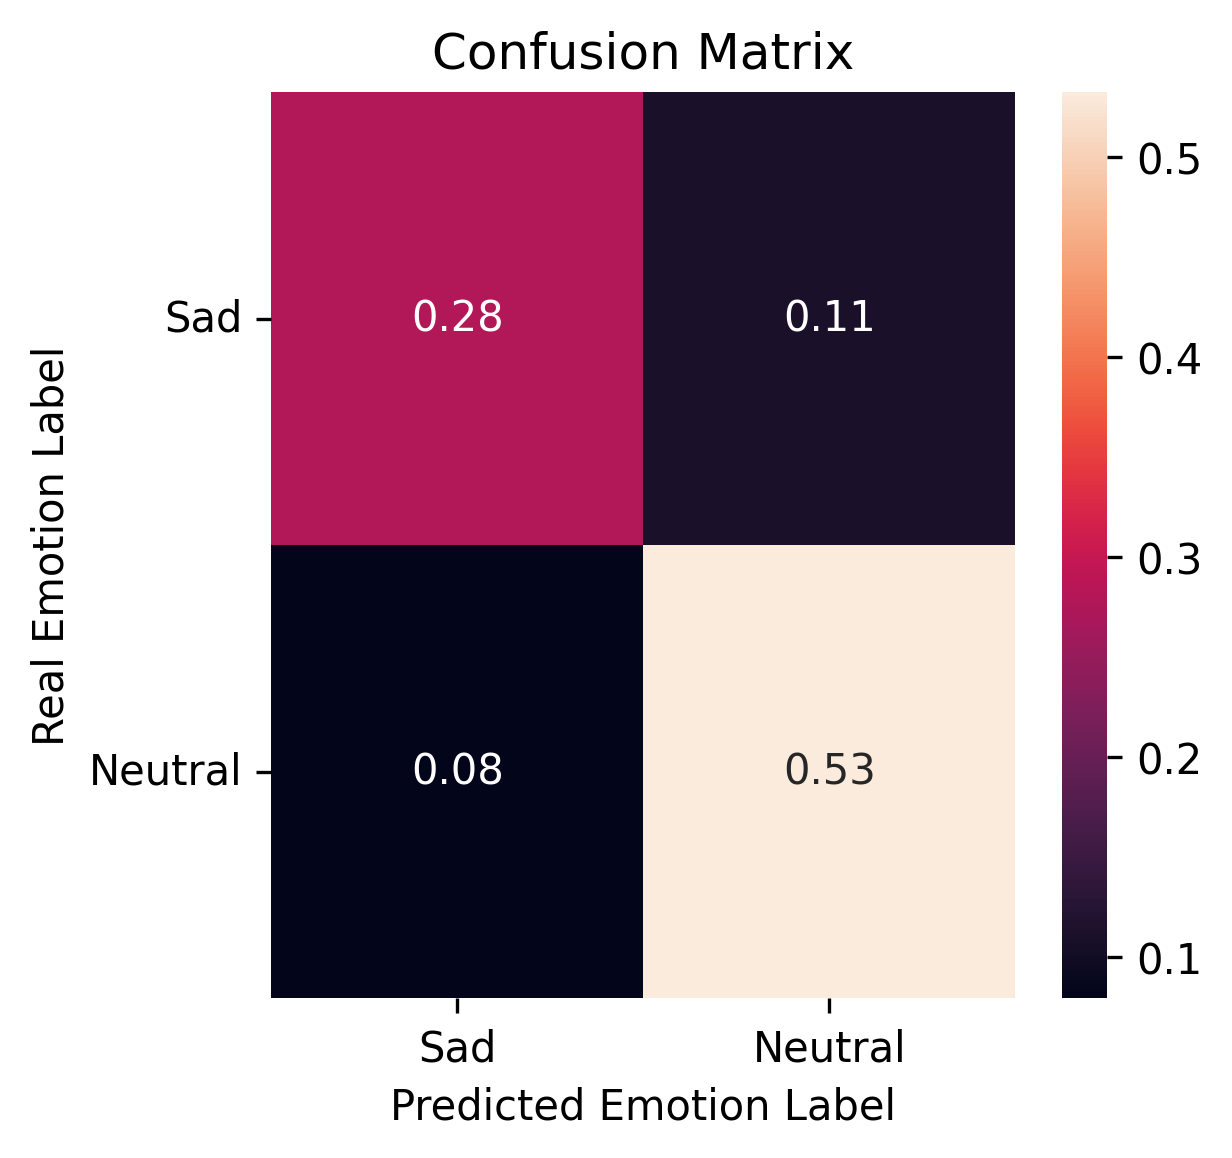

In [51]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)

df = df.set_index('File')
df = df[df['Emotion'].isin({'sad', 'neutral'})]
df.loc[df['Emotion_Id'] == 2, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})


results = categorical_cross_validation(get_new_model, "Sad, Neutral", results)

Sad, Happy

Number of Audio Files: 2720


Emotion
                     count
Emotion Emotion_Id        
happy   1             1636
sad     0             1084

Accuracy of fold 1: 83.46%
Accuracy of fold 2: 85.11%
Accuracy of fold 3: 84.38%
Accuracy of fold 4: 82.72%
Accuracy of fold 5: 83.27%

Metric             Value
-----------------  -----------
Accuracy           83.79+-0.85
F1 score macro     83.1
Precision          83.08
Recall             83.11
Matthews corrcoef  0.66


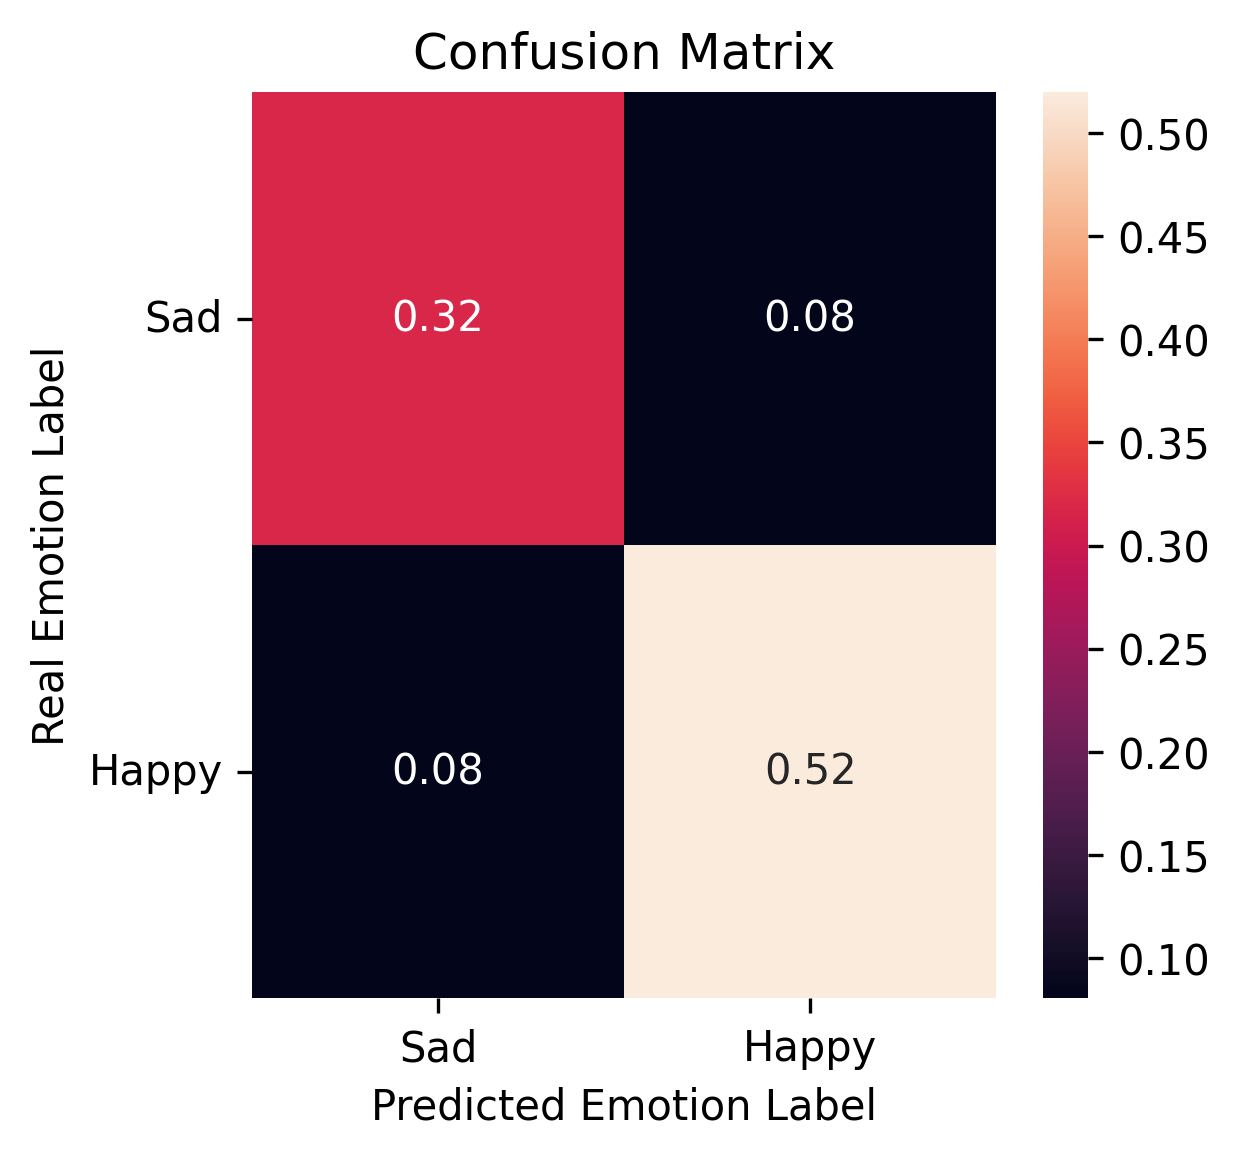

In [52]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)

df = df.set_index('File')
df = df[df['Emotion'].isin({'sad', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 2, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

results = categorical_cross_validation(get_new_model, "Sad, Happy", results)

Neutral, Happy

Number of Audio Files: 3344


Emotion
                     count
Emotion Emotion_Id        
happy   1             1636
neutral 0             1708

Accuracy of fold 1: 73.84%
Accuracy of fold 2: 75.04%
Accuracy of fold 3: 72.65%
Accuracy of fold 4: 72.35%
Accuracy of fold 5: 72.31%

Metric             Value
-----------------  -----------
Accuracy           73.24+-1.06
F1 score macro     73.15
Precision          73.34
Recall             73.15
Matthews corrcoef  0.46


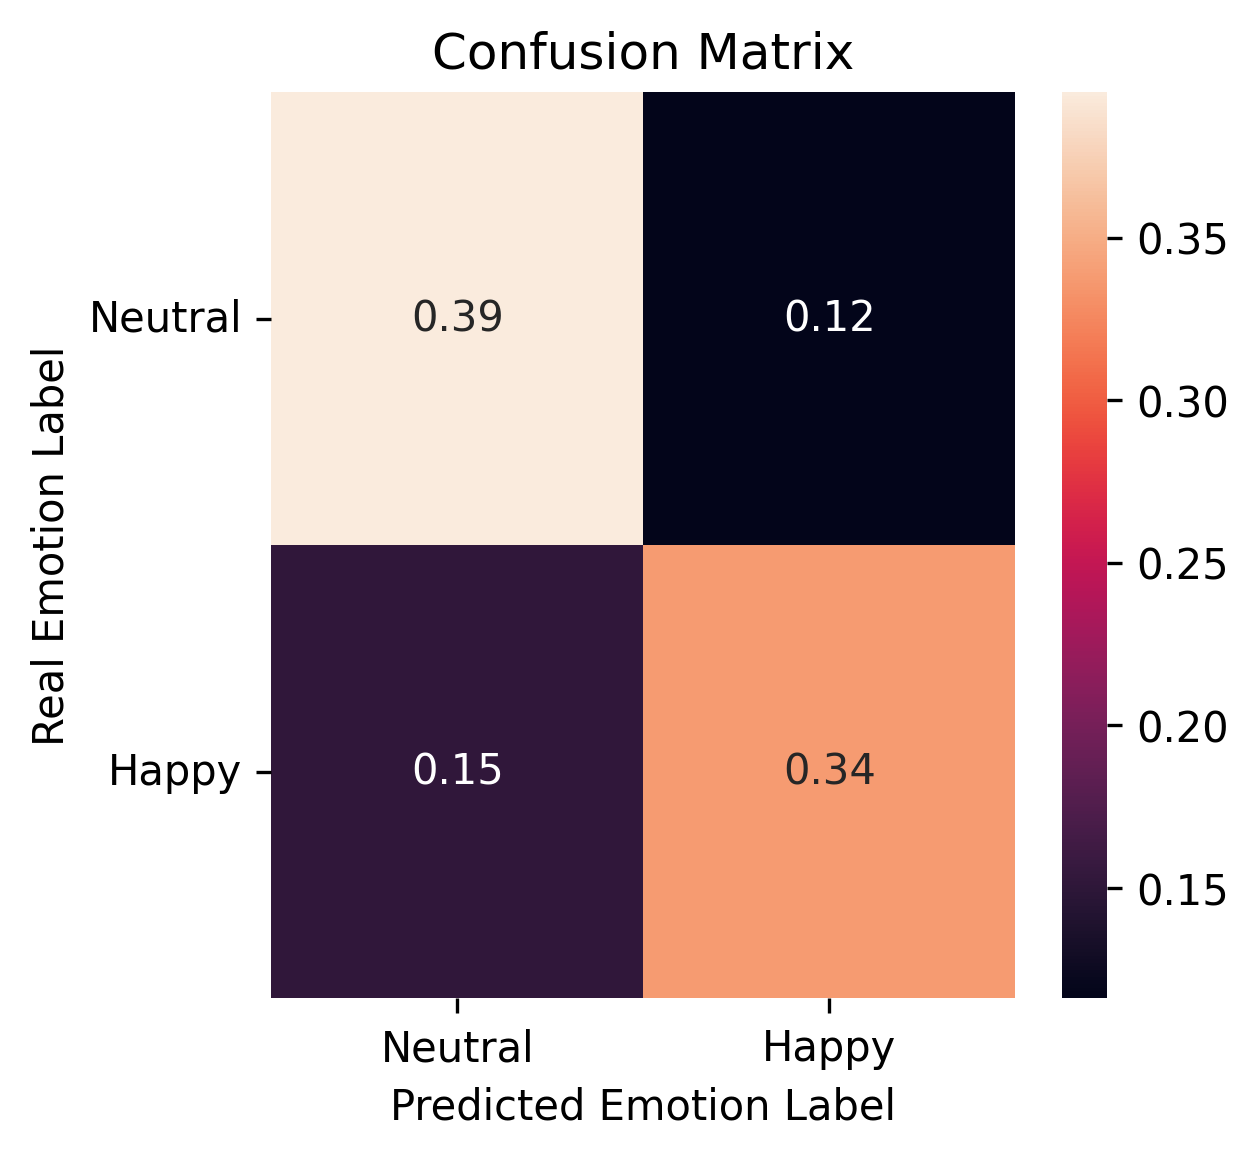

In [53]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)

df = df.set_index('File')
df = df[df['Emotion'].isin({'neutral', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

results = categorical_cross_validation(get_new_model, "Neutral, Happy", results)

In [54]:
display(HTML('<a href="https://www.researchgate.net/figure/Russel-circumplex-model-of-emotion-16-The-vertical-axis-represents-the-activation_fig1_328836839"><img src="https://www.researchgate.net/profile/Rab-Nawaz-12/publication/328836839/figure/fig1/AS:702472028971012@1544493791715/Russel-circumplex-model-of-emotion-16-The-vertical-axis-represents-the-activation.ppm" alt="Russel circumplex model of emotion [16]. The vertical axis represents the activation level (Arousal) and Horizontal axis represents the pleasure level (Valence) II."/></a>'))

Arousal plane - Happy+Angry, Neutral, Sad

Number of Audio Files: 5531


Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
happy   0             1636
neutral 1             1708
sad     2             1084

Accuracy of fold 1: 69.65%
Accuracy of fold 2: 69.08%
Accuracy of fold 3: 71.52%
Accuracy of fold 4: 68.08%
Accuracy of fold 5: 68.26%

Metric             Value
-----------------  -----------
Accuracy           69.32+-1.24
F1 score macro     67.29
Precision          67.44
Recall             67.2
Matthews corrcoef  0.5


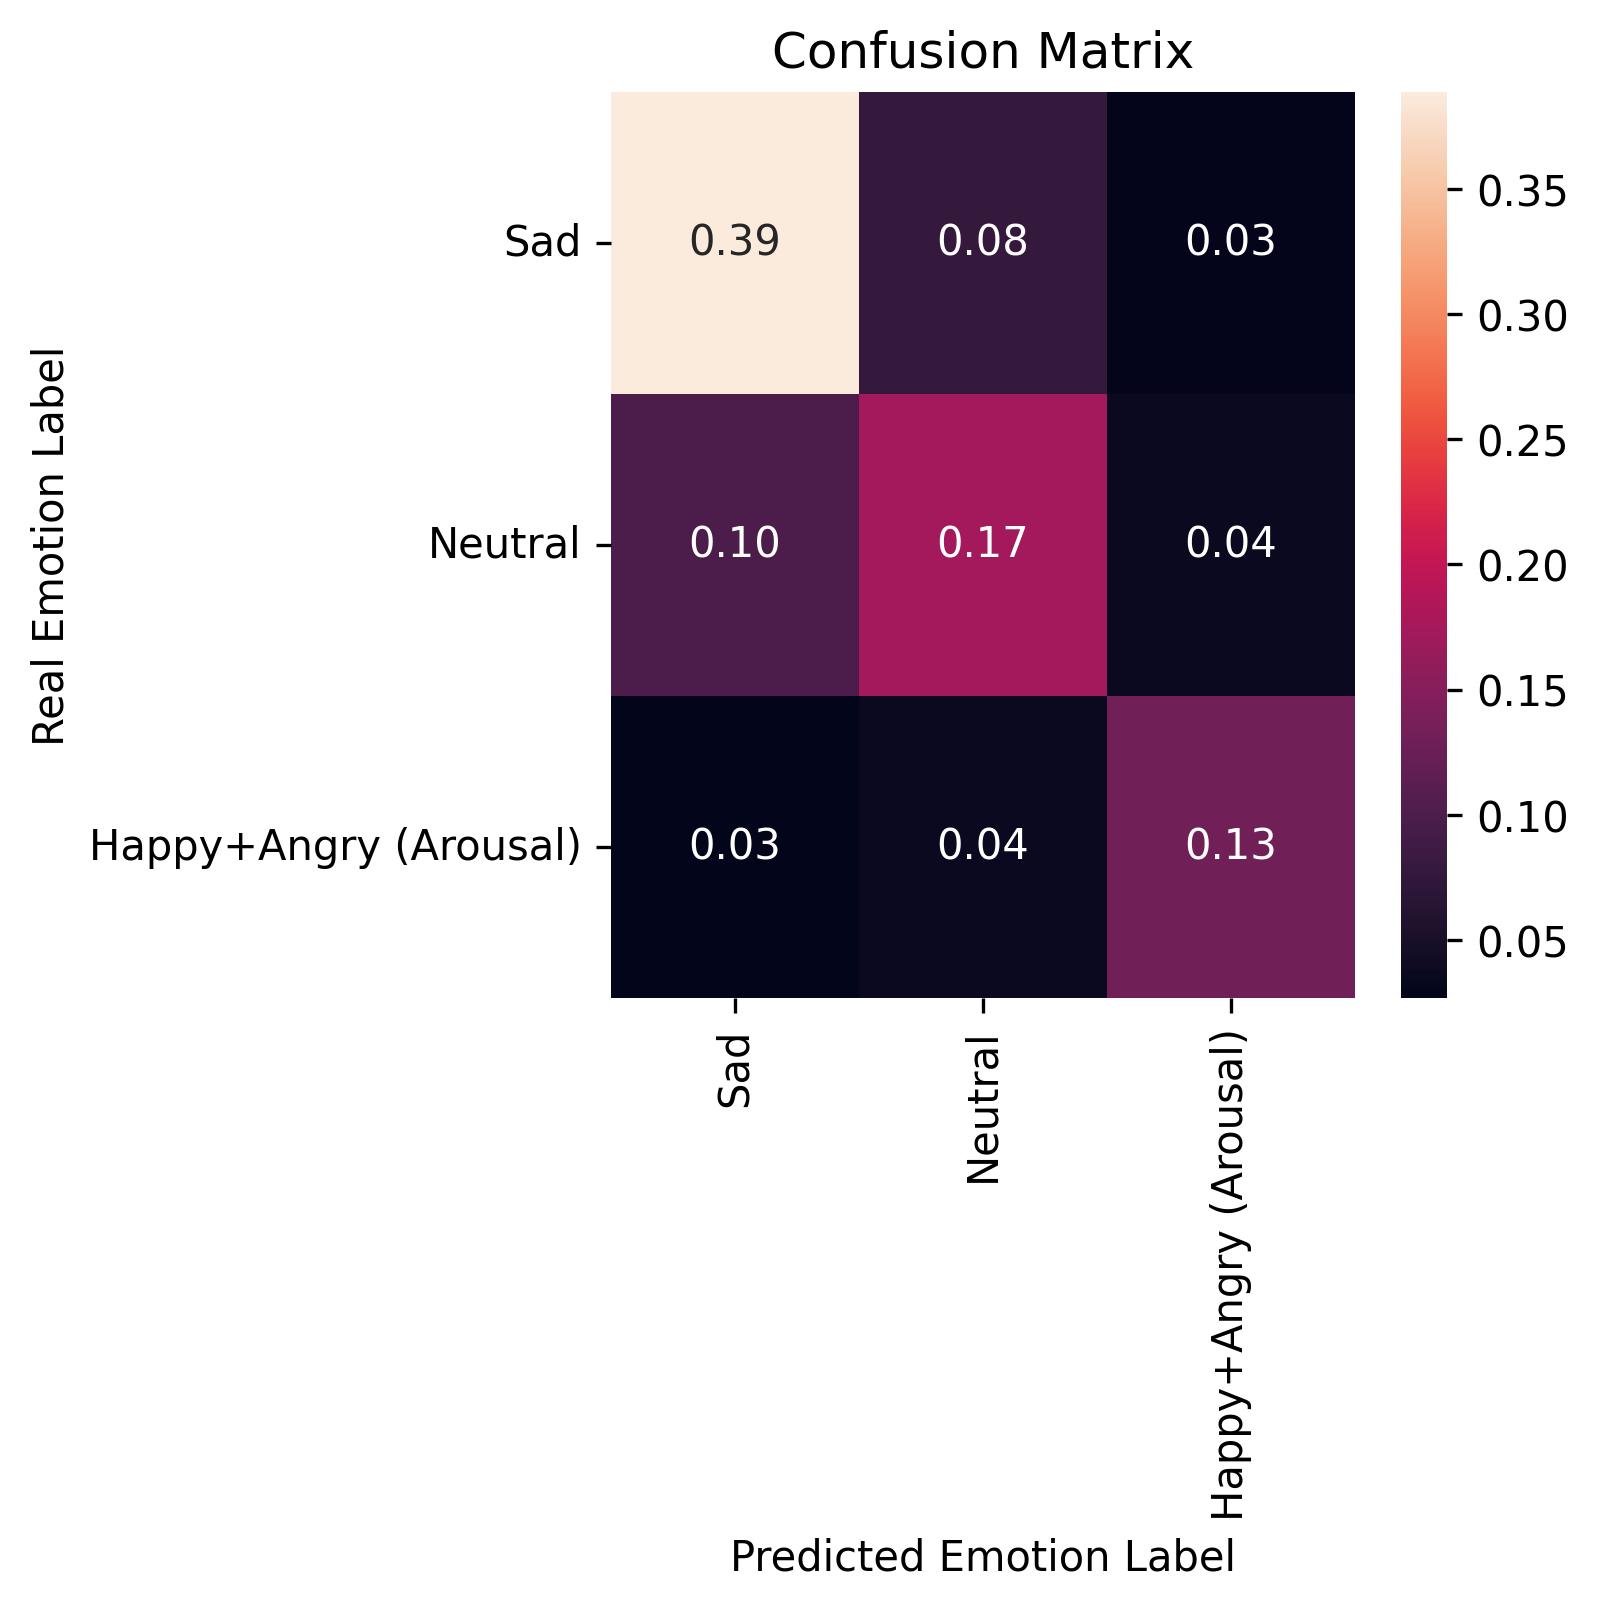

In [55]:
# Research article to corroborate this result: 10.21437/ICSLP.2002-557
df = pd.read_csv(EXTRACTED_FEATURES_FILE)

df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'sad', 'neutral', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 1, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 1
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

results = categorical_cross_validation(get_new_model, "Sad, Neutral, Happy+Angry (Arousal)", results)

Valence Plane - Happy, Neutral, Sad+Angry

Number of Audio Files: 5531


Emotion
                     count
Emotion Emotion_Id        
angry   2             1103
happy   0             1636
neutral 1             1708
sad     2             1084

Accuracy of fold 1: 59.98%
Accuracy of fold 2: 62.93%
Accuracy of fold 3: 60.31%
Accuracy of fold 4: 61.12%
Accuracy of fold 5: 58.86%

Metric             Value
-----------------  -----------
Accuracy           60.64+-1.36
F1 score macro     59.72
Precision          60.03
Recall             59.73
Matthews corrcoef  0.4


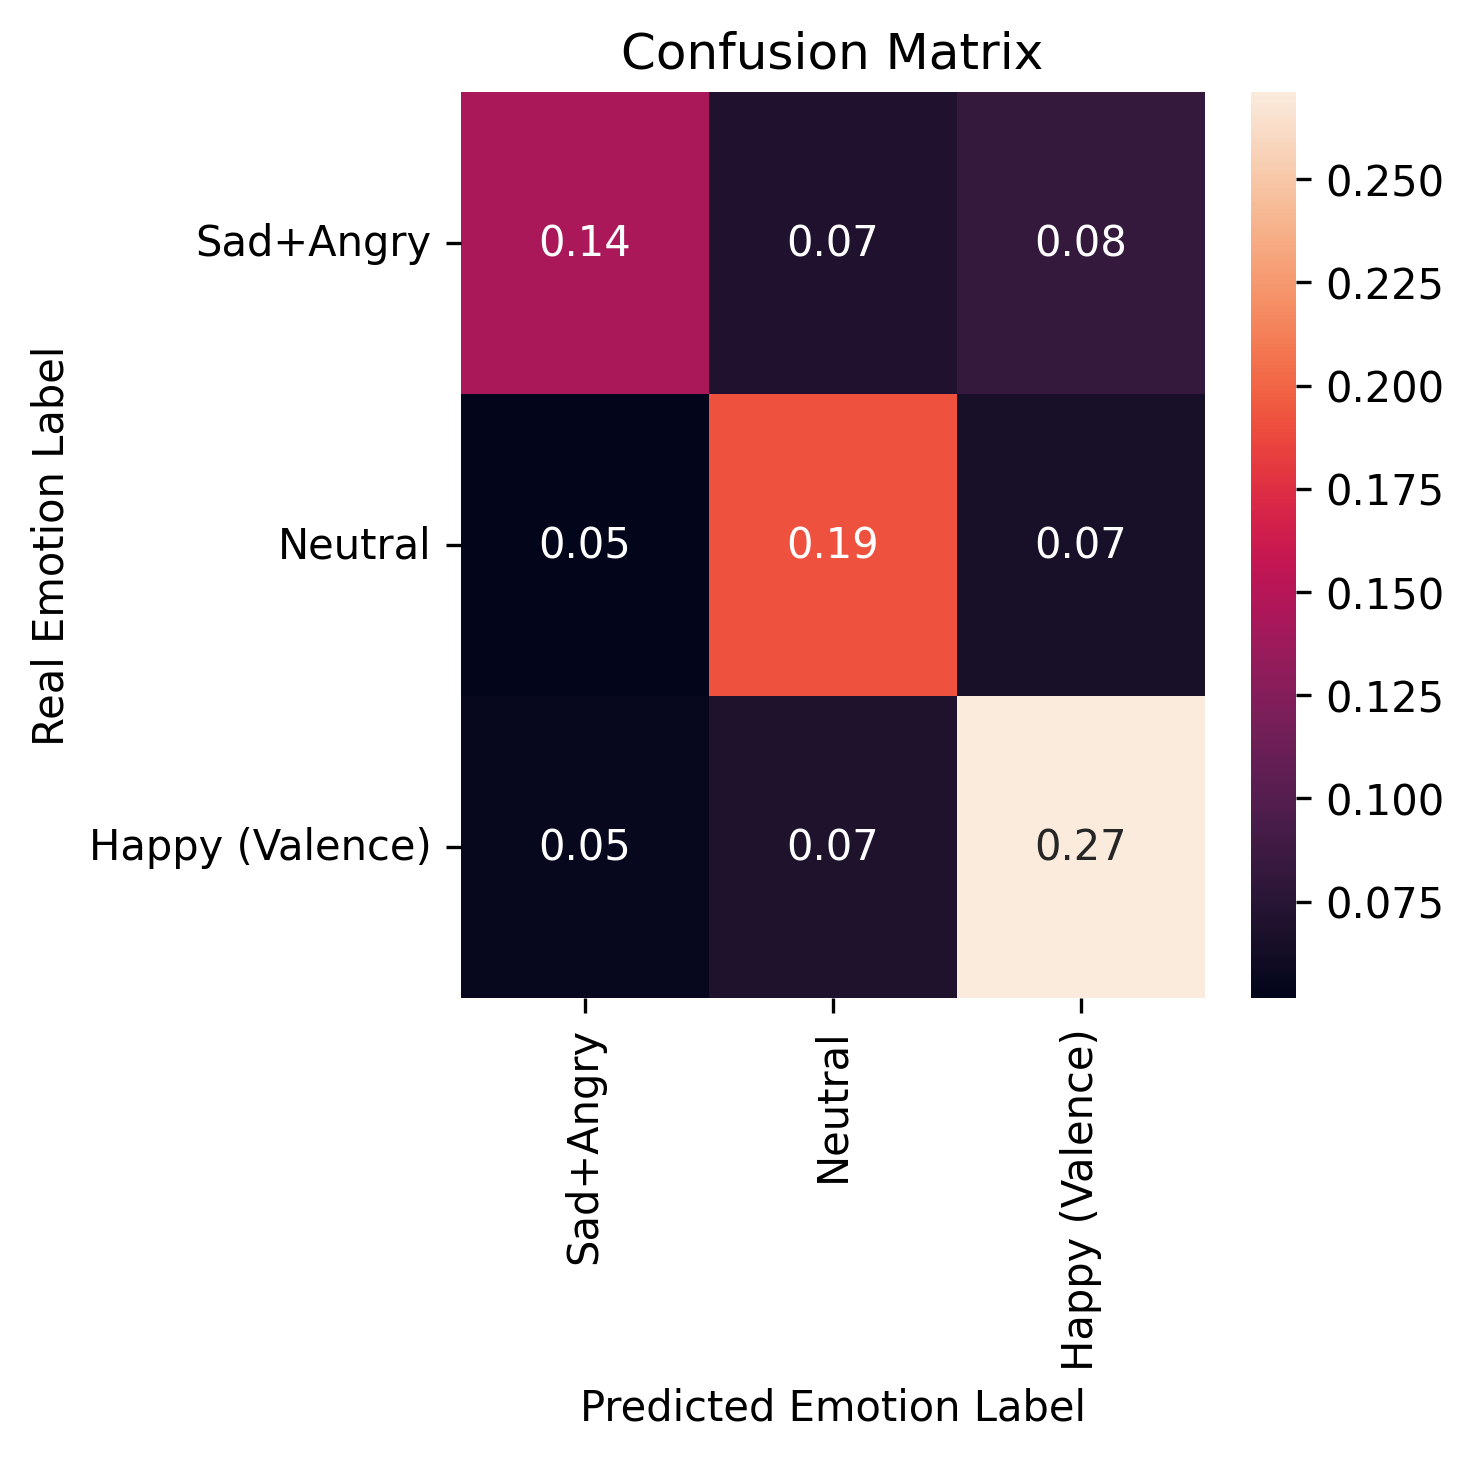

In [56]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)

df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'sad', 'neutral', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 0, 'Emotion_Id'] = 2
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 1, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 1
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

results = categorical_cross_validation(get_new_model, "Sad+Angry, Neutral, Happy (Valence)", results)

Results

In [57]:
tabulate(results,
            headers=["Classification Labels", "Total Data", "Accuracy", "Macro F1",
                    "Precision", "Recall", "MCC."], tablefmt='html'
        )

print(tabulate(results,
            headers=["Classification Labels", "Total Data", "Accuracy", "Macro F1",
                    "Precision", "Recall", "MCC."], tablefmt='latex_booktabs'
        ))


'<table>\n<thead>\n<tr><th>Classification Labels              </th><th style="text-align: right;">  Total Data</th><th>Accuracy   </th><th style="text-align: right;">  Macro F1</th><th style="text-align: right;">  Precision</th><th style="text-align: right;">  Recall</th><th style="text-align: right;">  MCC.</th></tr>\n</thead>\n<tbody>\n<tr><td>Angry, Happy, Sad, Neutral         </td><td style="text-align: right;">        5531</td><td>60.69+-1.37</td><td style="text-align: right;">     61.32</td><td style="text-align: right;">      61.66</td><td style="text-align: right;">   61.19</td><td style="text-align: right;">  0.47</td></tr>\n<tr><td>Angry+Sad, Neutral+Happy (Valence) </td><td style="text-align: right;">        5531</td><td>73.82+-0.77</td><td style="text-align: right;">     71.7 </td><td style="text-align: right;">      72.9 </td><td style="text-align: right;">   71.21</td><td style="text-align: right;">  0.44</td></tr>\n<tr><td>Angry, Happy, Sad                  </td><td style="text-align: right;">        3823</td><td>70.99+-1.55</td><td style="text-align: right;">     71.37</td><td style="text-align: right;">      71.38</td><td style="text-align: right;">   71.42</td><td style="text-align: right;">  0.56</td></tr>\n<tr><td>Angry, Happy, Neutral              </td><td style="text-align: right;">        4447</td><td>64.29+-1.13</td><td style="text-align: right;">     63.81</td><td style="text-align: right;">      64.41</td><td style="text-align: right;">   63.6 </td><td style="text-align: right;">  0.45</td></tr>\n<tr><td>Sad, Happy, Neutral                </td><td style="text-align: right;">        4428</td><td>65.74+-1.85</td><td style="text-align: right;">     65.85</td><td style="text-align: right;">      65.94</td><td style="text-align: right;">   65.86</td><td style="text-align: right;">  0.48</td></tr>\n<tr><td>Angry, Sad, Neutral                </td><td style="text-align: right;">        3895</td><td>75.17+-0.99</td><td style="text-align: right;">     75.3 </td><td style="text-align: right;">      76.21</td><td style="text-align: right;">   74.62</td><td style="text-align: right;">  0.62</td></tr>\n<tr><td>Sad+Neutral, Happy+Angry (Arousal) </td><td style="text-align: right;">        5531</td><td>77.24+-1.04</td><td style="text-align: right;">     77.21</td><td style="text-align: right;">      77.31</td><td style="text-align: right;">   77.21</td><td style="text-align: right;">  0.55</td></tr>\n<tr><td>Angry, Sad                         </td><td style="text-align: right;">        2187</td><td>92.0+-1.3  </td><td style="text-align: right;">     92   </td><td style="text-align: right;">      92   </td><td style="text-align: right;">   92   </td><td style="text-align: right;">  0.84</td></tr>\n<tr><td>Angry, Neutral                     </td><td style="text-align: right;">        2811</td><td>84.53+-1.26</td><td style="text-align: right;">     83.49</td><td style="text-align: right;">      84.25</td><td style="text-align: right;">   82.98</td><td style="text-align: right;">  0.67</td></tr>\n<tr><td>Angry, Happy                       </td><td style="text-align: right;">        2739</td><td>75.58+-0.93</td><td style="text-align: right;">     74.15</td><td style="text-align: right;">      74.78</td><td style="text-align: right;">   73.79</td><td style="text-align: right;">  0.49</td></tr>\n<tr><td>Sad, Neutral                       </td><td style="text-align: right;">        2792</td><td>81.02+-1.16</td><td style="text-align: right;">     79.7 </td><td style="text-align: right;">      80.29</td><td style="text-align: right;">   79.29</td><td style="text-align: right;">  0.6 </td></tr>\n<tr><td>Sad, Happy                         </td><td style="text-align: right;">        2720</td><td>83.79+-0.85</td><td style="text-align: right;">     83.1 </td><td style="text-align: right;">      83.08</td><td style="text-align: right;">   83.11</td><td style="text-align: right;">  0.66</td></tr>\n<tr><td>Neutral, Happy              

\begin{tabular}{lrlrrrr}
\toprule
 Classification Labels               &   Total Data & Accuracy    &   Macro F1 &   Precision &   Recall &   MCC. \\
\midrule
 Angry, Happy, Sad, Neutral          &         5531 & 60.69+-1.37 &      61.32 &       61.66 &    61.19 &   0.47 \\
 Angry+Sad, Neutral+Happy (Valence)  &         5531 & 73.82+-0.77 &      71.7  &       72.9  &    71.21 &   0.44 \\
 Angry, Happy, Sad                   &         3823 & 70.99+-1.55 &      71.37 &       71.38 &    71.42 &   0.56 \\
 Angry, Happy, Neutral               &         4447 & 64.29+-1.13 &      63.81 &       64.41 &    63.6  &   0.45 \\
 Sad, Happy, Neutral                 &         4428 & 65.74+-1.85 &      65.85 &       65.94 &    65.86 &   0.48 \\
 Angry, Sad, Neutral                 &         3895 & 75.17+-0.99 &      75.3  &       76.21 &    74.62 &   0.62 \\
 Sad+Neutral, Happy+Angry (Arousal)  &         5531 & 77.24+-1.04 &      77.21 &       77.31 &    77.21 &   0.55 \\
 Angry, Sad                  

# Neutral Data Analysis

## Duration

In [58]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)

df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'
df.groupby(['Emotion']).agg({'Duration': ['describe']})

Duration                                                           \
        describe                                                            
           count      mean       std    min       25%       50%       75%   
Emotion                                                                     
angry     1103.0  3.783044  2.932327  0.320  1.816844  2.894000  4.864000   
happy     1636.0  4.166262  3.101846  0.352  2.009016  3.248000  5.504000   
neutral   1708.0  3.500057  2.534368  0.256  1.724500  2.748750  4.512000   
sad       1084.0  5.088354  3.799961  0.576  2.425453  3.891969  6.392453   

                    
                    
               max  
Emotion             
angry    25.920000  
happy    33.184000  
neutral  19.937938  
sad      31.456000

<AxesSubplot:ylabel='Frequency'>

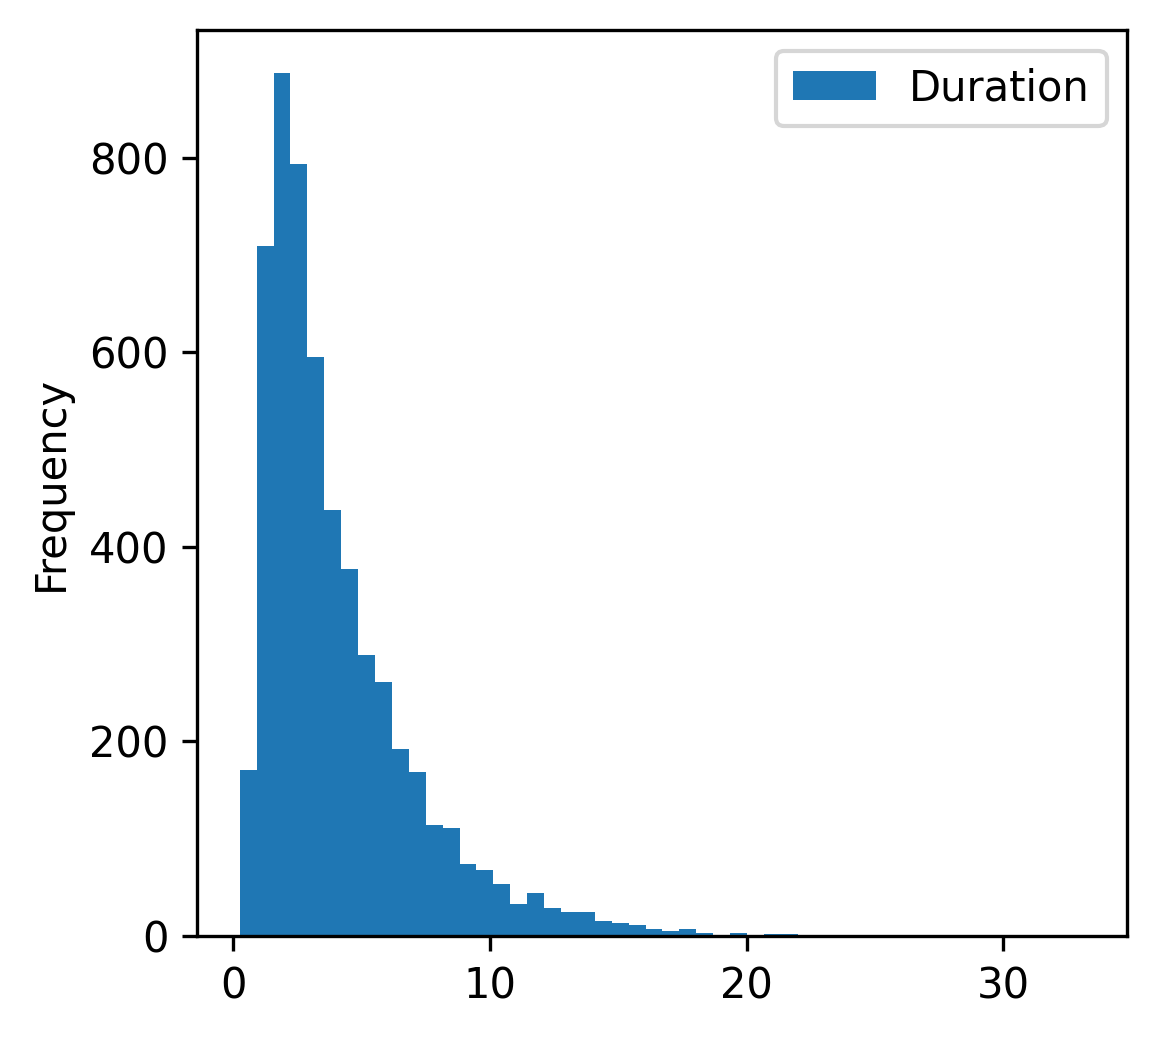

In [59]:
df["Duration"].plot(kind = 'hist', bins=50, legend=True, orientation='vertical',figsize=(4, 4))

In [60]:
print(df.agg({'Duration': ['describe']}).to_latex())

\begin{tabular}{lr}
\toprule
{} &     Duration \\
{} &     describe \\
\midrule
count &  5531.000000 \\
mean  &     4.064830 \\
std   &     3.113111 \\
min   &     0.256000 \\
25\%   &     1.952000 \\
50\%   &     3.109938 \\
75\%   &     5.248000 \\
max   &    33.184000 \\
\bottomrule
\end{tabular}



C:\Users\Chico\AppData\Local\Temp\ipykernel_10136\1166118545.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.agg({'Duration': ['describe']}).to_latex())


In [61]:
print(df.groupby(['Emotion']).agg({'Duration': ['describe']}).to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} & \multicolumn{8}{l}{Duration} \\
{} & \multicolumn{8}{l}{describe} \\
{} &    count &      mean &       std &    min &       25\% &       50\% &       75\% &        max \\
Emotion &          &           &           &        &           &           &           &            \\
\midrule
angry   &   1103.0 &  3.783044 &  2.932327 &  0.320 &  1.816844 &  2.894000 &  4.864000 &  25.920000 \\
happy   &   1636.0 &  4.166262 &  3.101846 &  0.352 &  2.009016 &  3.248000 &  5.504000 &  33.184000 \\
neutral &   1708.0 &  3.500057 &  2.534368 &  0.256 &  1.724500 &  2.748750 &  4.512000 &  19.937938 \\
sad     &   1084.0 &  5.088354 &  3.799961 &  0.576 &  2.425453 &  3.891969 &  6.392453 &  31.456000 \\
\bottomrule
\end{tabular}



C:\Users\Chico\AppData\Local\Temp\ipykernel_10136\4021711002.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.groupby(['Emotion']).agg({'Duration': ['describe']}).to_latex())


In [62]:
df = df[(df['Emotion_Id'] != 3) | (df["Duration"] > 1.7)]
df.groupby(['Emotion']).agg({'Duration': ['describe']})

Duration                                                              \
        describe                                                               
           count      mean       std       min       25%       50%       75%   
Emotion                                                                        
angry     1103.0  3.783044  2.932327  0.320000  1.816844  2.894000  4.864000   
happy     1636.0  4.166262  3.101846  0.352000  2.009016  3.248000  5.504000   
neutral   1288.0  4.228268  2.516601  1.707125  2.464000  3.379938  5.250141   
sad       1084.0  5.088354  3.799961  0.576000  2.425453  3.891969  6.392453   

                    
                    
               max  
Emotion             
angry    25.920000  
happy    33.184000  
neutral  19.937938  
sad      31.456000

Neutral Data with more than 1.7 seconds of audio

Number of Audio Files: 5111


Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
happy   1             1636
neutral 3             1288
sad     2             1084

Accuracy of fold 1: 62.07%
Accuracy of fold 2: 59.78%
Accuracy of fold 3: 61.64%
Accuracy of fold 4: 59.98%
Accuracy of fold 5: 59.3%

Metric             Value
-----------------  -----------
Accuracy           60.56+-1.09
F1 score macro     61.12
Precision          61.19
Recall             61.13
Matthews corrcoef  0.47


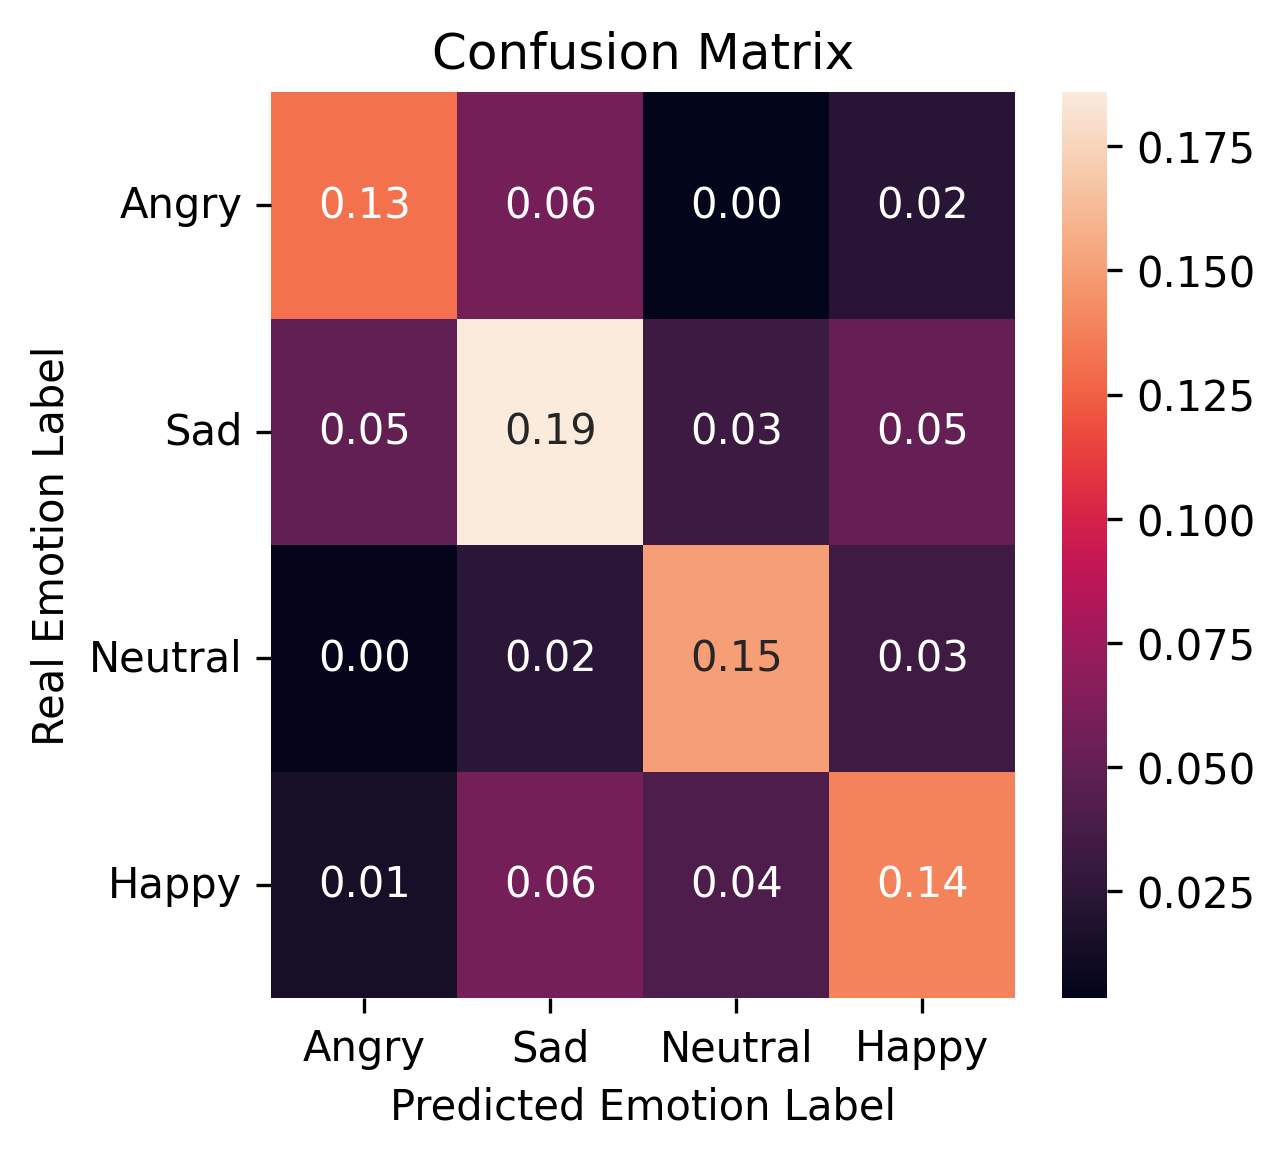

In [63]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)

df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df = df[(df['Emotion_Id'] != 3) | (df["Duration"] > 1.7)]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

results = categorical_cross_validation(get_new_model, "Angry, Sad, Neutral, Happy", results)

Neutral Data with more than 1 seconds of audio

Number of Audio Files: 5458


Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
happy   1             1636
neutral 3             1635
sad     2             1084

Accuracy of fold 1: 60.35%
Accuracy of fold 2: 60.71%
Accuracy of fold 3: 61.36%
Accuracy of fold 4: 60.86%
Accuracy of fold 5: 57.47%

Metric             Value
-----------------  -----------
Accuracy           60.15+-1.38
F1 score macro     60.81
Precision          61.08
Recall             60.77
Matthews corrcoef  0.46


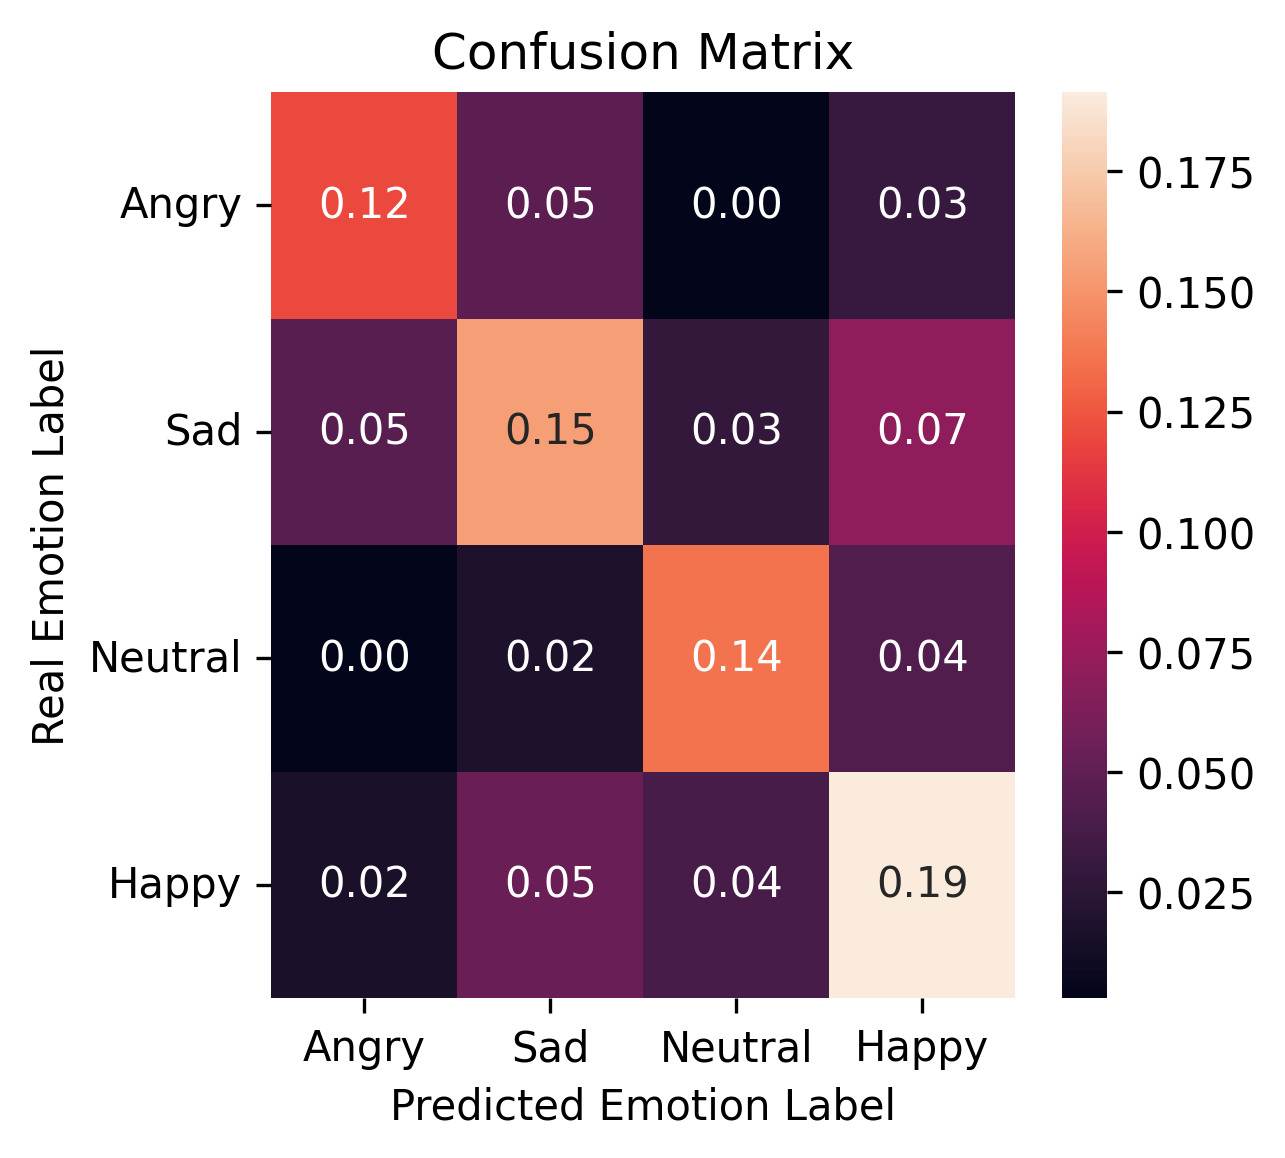

In [64]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)

df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df = df[(df['Emotion_Id'] != 3) | (df["Duration"] > 1)]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

results = categorical_cross_validation(get_new_model, "Angry, Sad, Neutral, Happy", results)

Data between 1.7 and 7 seconds of audio

Number of Audio Files: 3708


Emotion
                     count
Emotion Emotion_Id        
angry   0              723
happy   1             1105
neutral 3             1135
sad     2              745

Accuracy of fold 1: 57.01%
Accuracy of fold 2: 59.84%
Accuracy of fold 3: 56.47%
Accuracy of fold 4: 58.7%
Accuracy of fold 5: 56.68%

Metric             Value
-----------------  -----------
Accuracy           57.74+-1.31
F1 score macro     58.56
Precision          59.05
Recall             58.27
Matthews corrcoef  0.43


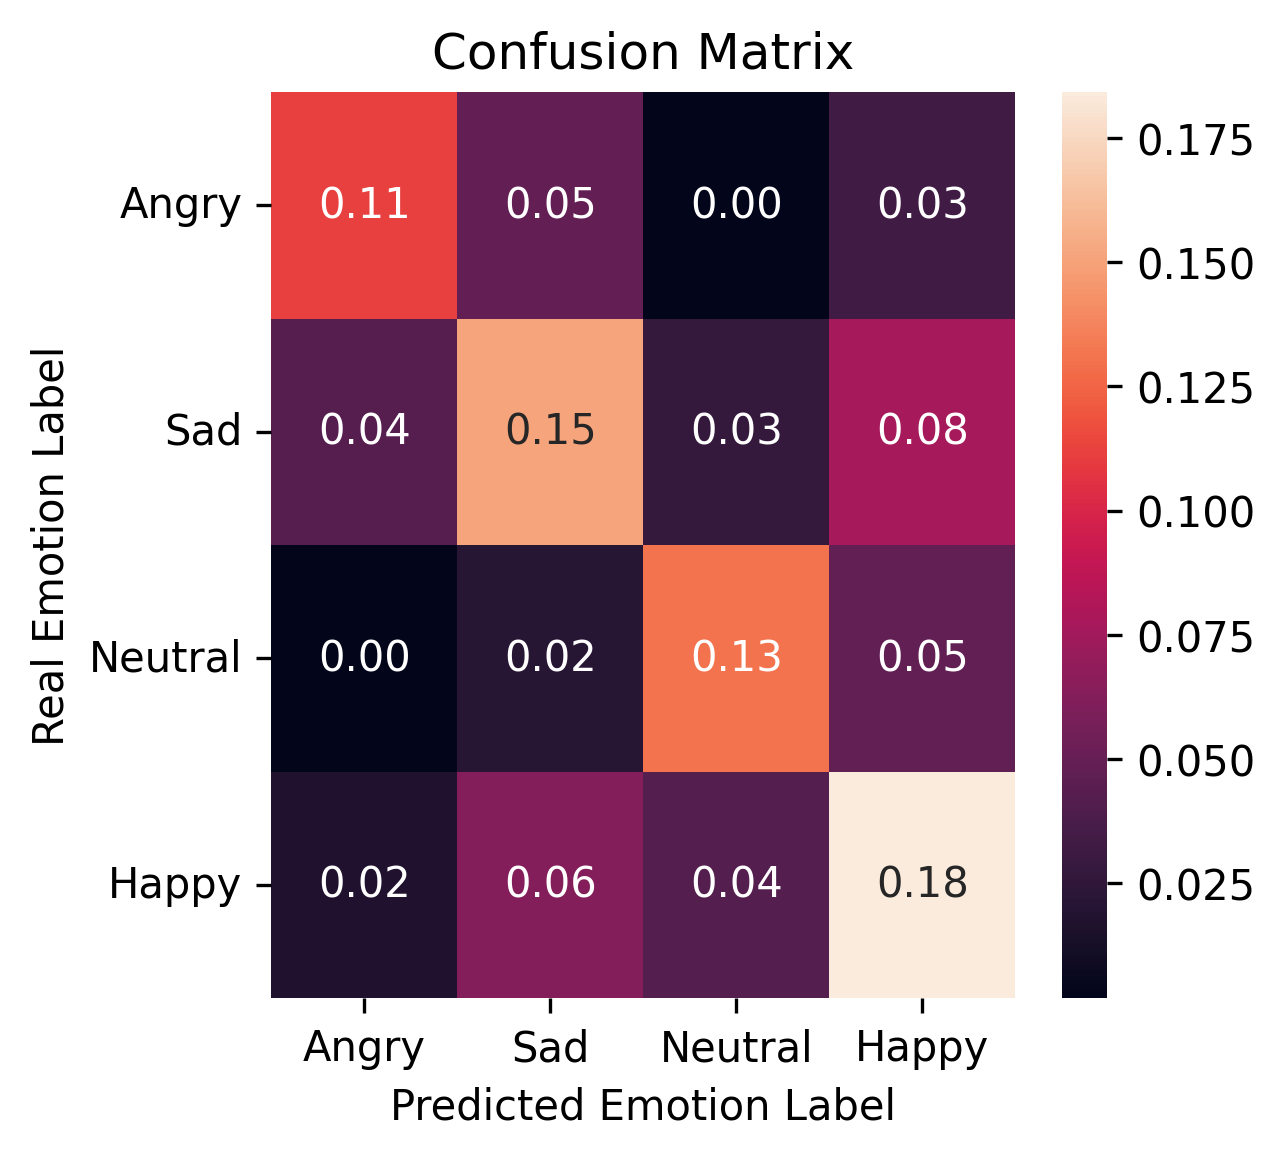

In [65]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)

df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df = df[(df["Duration"] < 7) & (df["Duration"] > 1.7)]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

results = categorical_cross_validation(get_new_model, "Angry, Sad, Neutral, Happy", results)

Data between 1.7 and 8 seconds of audio

Number of Audio Files: 3911


Emotion
                     count
Emotion Emotion_Id        
angry   0              754
happy   1             1186
neutral 3             1179
sad     2              792

Accuracy of fold 1: 57.09%
Accuracy of fold 2: 59.21%
Accuracy of fold 3: 56.91%
Accuracy of fold 4: 62.28%
Accuracy of fold 5: 58.82%

Metric             Value
-----------------  -----------
Accuracy           58.86+-1.94
F1 score macro     59.58
Precision          59.91
Recall             59.42
Matthews corrcoef  0.44


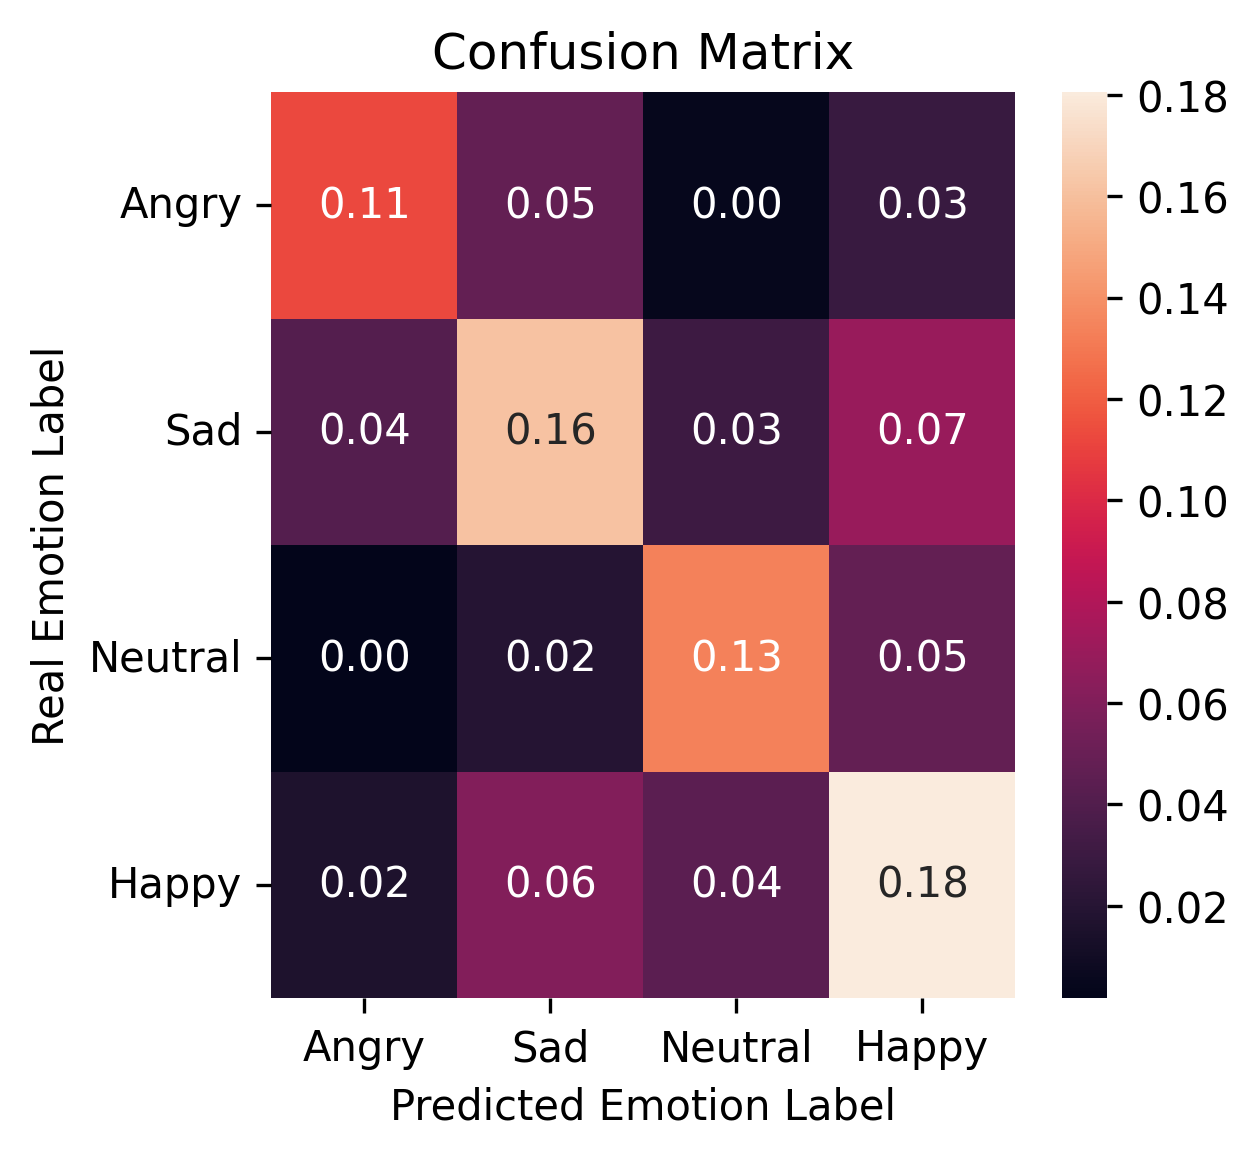

In [66]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)

df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df = df[(df["Duration"] < 8) & (df["Duration"] > 1.7)]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

results = categorical_cross_validation(get_new_model, "Angry, Sad, Neutral, Happy", results)

# Logistic Regression

In [67]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)

df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'sad', 'neutral', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 1, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 1
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

model = LogisticRegression(n_jobs=-1, random_state=0)
model.fit(df.iloc[:,9:], df.iloc[:,5:6].values.ravel())
arousal_probabilities = model.predict_proba(df.iloc[:,9:])

final_df = df.copy(deep=True)
final_df["Low Arousal"] = [x[2] for x in arousal_probabilities]
final_df["Medium Arousal"] = [x[1] for x in arousal_probabilities]
final_df["High Arousal"] = [x[0] for x in arousal_probabilities]
final_df.groupby(['Emotion']).agg({'Low Arousal': ['describe']})
final_df.groupby(['Emotion']).agg({'Medium Arousal': ['describe']})
final_df.groupby(['Emotion']).agg({'High Arousal': ['describe']})

Number of Audio Files: 5531


Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
happy   0             1636
neutral 1             1708
sad     2             1084

LogisticRegression(n_jobs=-1, random_state=0)

Low Arousal                                                        \
           describe                                                         
              count      mean       std           min       25%       50%   
Emotion                                                                     
angry        1103.0  0.047437  0.074044  9.588771e-12  0.007417  0.023298   
happy        1636.0  0.140382  0.164798  1.099688e-12  0.030136  0.079066   
neutral      1708.0  0.196037  0.189552  6.488293e-06  0.048499  0.129338   
sad          1084.0  0.430229  0.227006  1.039062e-03  0.239174  0.439171   

                             
                             
              75%       max  
Emotion                      
angry    0.058024  0.682652  
happy    0.185151  0.922103  
neutral  0.303838  0.908005  
sad      0.618099  0.944218

Medium Arousal                                                        \
              describe                                                         
                 count      mean       std           min       25%       50%   
Emotion                                                                        
angry           1103.0  0.247219  0.112922  3.000227e-15  0.177229  0.265237   
happy           1636.0  0.311357  0.093047  3.817658e-15  0.267902  0.330568   
neutral         1708.0  0.337730  0.072845  8.134200e-06  0.295761  0.350508   
sad             1084.0  0.306667  0.083511  4.293946e-02  0.249845  0.318923   

                             
                             
              75%       max  
Emotion                      
angry    0.334274  0.492883  
happy    0.376928  0.497617  
neutral  0.388454  0.537114  
sad      0.372287  0.536754

High Arousal                                                    \
            describe                                                     
               count      mean       std       min       25%       50%   
Emotion                                                                  
angry         1103.0  0.705343  0.161871  0.102902  0.605024  0.706997   
happy         1636.0  0.548261  0.197197  0.018069  0.429170  0.559503   
neutral       1708.0  0.466233  0.196148  0.020699  0.318202  0.483657   
sad           1084.0  0.263103  0.170420  0.012842  0.124271  0.224671   

                             
                             
              75%       max  
Emotion                      
angry    0.811344  1.000000  
happy    0.680291  1.000000  
neutral  0.613284  0.999985  
sad      0.363300  0.881863

In [68]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)

df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'sad', 'neutral', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 2, 'Emotion_Id'] = 2
df.loc[df['Emotion_Id'] == 0, 'Emotion_Id'] = 2
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 1, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

model = LogisticRegression(n_jobs=-1, random_state=0)
model.fit(df.iloc[:,9:], df.iloc[:,5:6].values.ravel())
valence_probabilities = model.predict_proba(df.iloc[:,9:])

final_df = df.copy(deep=True)
final_df["Low Valence"] = [x[2] for x in valence_probabilities]
final_df["Medium Valence"] = [x[1] for x in valence_probabilities]
final_df["High Valence"] = [x[0] for x in valence_probabilities]
final_df.groupby(['Emotion']).agg({'Low Valence': ['describe']})
final_df.groupby(['Emotion']).agg({'Medium Valence': ['describe']})
final_df.groupby(['Emotion']).agg({'High Valence': ['describe']})

Number of Audio Files: 5531


Emotion
                     count
Emotion Emotion_Id        
angry   2             1103
happy   0             1636
neutral 1             1708
sad     2             1084

LogisticRegression(n_jobs=-1, random_state=0)

Low Valence                                                    \
           describe                                                     
              count      mean       std       min       25%       50%   
Emotion                                                                 
angry        1103.0  0.399455  0.091331  0.104098  0.345719  0.396577   
happy        1636.0  0.386092  0.073494  0.118897  0.340259  0.385724   
neutral      1708.0  0.395211  0.069648  0.137243  0.354010  0.397331   
sad          1084.0  0.436327  0.050551  0.181173  0.403632  0.441301   

                             
                             
              75%       max  
Emotion                      
angry    0.446530  0.810406  
happy    0.430782  0.772509  
neutral  0.443810  0.619013  
sad      0.474213  0.575973

Medium Valence                                                        \
              describe                                                         
                 count      mean       std           min       25%       50%   
Emotion                                                                        
angry           1103.0  0.260659  0.100211  1.674492e-22  0.229630  0.283357   
happy           1636.0  0.299853  0.070605  6.938867e-22  0.274456  0.308257   
neutral         1708.0  0.322194  0.049260  4.227541e-08  0.291025  0.320230   
sad             1084.0  0.317382  0.036408  1.905766e-01  0.295008  0.317592   

                             
                             
              75%       max  
Emotion                      
angry    0.325284  0.498999  
happy    0.338893  0.516846  
neutral  0.351040  0.534509  
sad      0.340664  0.452294

High Valence                                                    \
            describe                                                     
               count      mean       std       min       25%       50%   
Emotion                                                                  
angry         1103.0  0.339885  0.085083  0.116119  0.280057  0.326425   
happy         1636.0  0.314055  0.071145  0.165626  0.262806  0.304402   
neutral       1708.0  0.282594  0.062728  0.158704  0.237916  0.273712   
sad           1084.0  0.246291  0.050866  0.158338  0.209571  0.235815   

                             
                             
              75%       max  
Emotion                      
angry    0.377800  0.764483  
happy    0.349711  0.657740  
neutral  0.317056  0.532065  
sad      0.272073  0.527424

In [69]:
final_df.groupby(['Emotion']).agg({'Low Valence': ['describe']})
final_df.groupby(['Emotion']).agg({'Medium Valence': ['describe']})
final_df.groupby(['Emotion']).agg({'High Valence': ['describe']})

Low Valence                                                    \
           describe                                                     
              count      mean       std       min       25%       50%   
Emotion                                                                 
angry        1103.0  0.399455  0.091331  0.104098  0.345719  0.396577   
happy        1636.0  0.386092  0.073494  0.118897  0.340259  0.385724   
neutral      1708.0  0.395211  0.069648  0.137243  0.354010  0.397331   
sad          1084.0  0.436327  0.050551  0.181173  0.403632  0.441301   

                             
                             
              75%       max  
Emotion                      
angry    0.446530  0.810406  
happy    0.430782  0.772509  
neutral  0.443810  0.619013  
sad      0.474213  0.575973

Medium Valence                                                        \
              describe                                                         
                 count      mean       std           min       25%       50%   
Emotion                                                                        
angry           1103.0  0.260659  0.100211  1.674492e-22  0.229630  0.283357   
happy           1636.0  0.299853  0.070605  6.938867e-22  0.274456  0.308257   
neutral         1708.0  0.322194  0.049260  4.227541e-08  0.291025  0.320230   
sad             1084.0  0.317382  0.036408  1.905766e-01  0.295008  0.317592   

                             
                             
              75%       max  
Emotion                      
angry    0.325284  0.498999  
happy    0.338893  0.516846  
neutral  0.351040  0.534509  
sad      0.340664  0.452294

High Valence                                                    \
            describe                                                     
               count      mean       std       min       25%       50%   
Emotion                                                                  
angry         1103.0  0.339885  0.085083  0.116119  0.280057  0.326425   
happy         1636.0  0.314055  0.071145  0.165626  0.262806  0.304402   
neutral       1708.0  0.282594  0.062728  0.158704  0.237916  0.273712   
sad           1084.0  0.246291  0.050866  0.158338  0.209571  0.235815   

                             
                             
              75%       max  
Emotion                      
angry    0.377800  0.764483  
happy    0.349711  0.657740  
neutral  0.317056  0.532065  
sad      0.272073  0.527424

In [70]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.set_index('File')
df['Valence'] = df['Valence'].apply(lambda x: x if x <= 5 else 5)
print(df.groupby(['Emotion']).agg({'Activation': ['describe']}))
print(df.groupby(['Emotion']).agg({'Valence': ['describe']}))
print(df.groupby(['Emotion']).agg({'Dominance': ['describe']}))

        Activation                                                
          describe                                                
             count      mean       std  min  25%     50%  75%  max
Emotion                                                           
angry       1103.0  3.635539  0.670917  1.5  3.0  3.5000  4.0  5.0
happy       1636.0  3.411115  0.648457  1.5  3.0  3.5000  4.0  5.0
neutral     1708.0  2.725752  0.546526  1.0  2.5  2.6667  3.0  5.0
sad         1084.0  2.563499  0.622903  1.0  2.0  2.5000  3.0  4.5
         Valence                                             
        describe                                             
           count      mean       std  min  25%  50%  75%  max
Emotion                                                      
angry     1103.0  1.905712  0.524000  1.0  1.5  2.0  2.0  4.0
happy     1636.0  3.946414  0.570153  1.5  3.5  4.0  4.5  5.0
neutral   1708.0  2.971361  0.510258  1.5  2.5  3.0  3.0  5.0
sad       1084.0  2.253075  0.

In [71]:
print(df.groupby(['Emotion']).agg({'Activation': ['mean'], 'Valence': ['mean'], 'Dominance': ['mean']}).to_latex())

\begin{tabular}{lrrr}
\toprule
{} & Activation &   Valence & Dominance \\
{} &       mean &      mean &      mean \\
Emotion &            &           &           \\
\midrule
angry   &   3.635539 &  1.905712 &  3.949834 \\
happy   &   3.411115 &  3.946414 &  3.228453 \\
neutral &   2.725752 &  2.971361 &  2.830553 \\
sad     &   2.563499 &  2.253075 &  2.827952 \\
\bottomrule
\end{tabular}



C:\Users\Chico\AppData\Local\Temp\ipykernel_10136\997214648.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.groupby(['Emotion']).agg({'Activation': ['mean'], 'Valence': ['mean'], 'Dominance': ['mean']}).to_latex())


# Regression to Discrete

In [72]:
def regression_cross_validation(get_new_model, used_labels, results, cv=5):
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)

    X = df.iloc[:, 5:]
    y = df.iloc[:, 4:5]
    all_y_pred = []
    all_y_labels = []
    folds_size = []

    fold_no = 1
    for train, test in kfold.split(X, y):
        valence_model = get_new_model()
        activation_model = get_new_model()
        dominance_model = get_new_model()
        classifier = RandomForest(n_estimators=512, n_jobs=-1, random_state=0)
        
        X_train, X_test = X.iloc[train, 3:].values, X.iloc[test, 3:].values
        X_train_class = X.iloc[train, 0:3]

        y_train_valence = X.iloc[train, 0:1]
        y_train_activation = X.iloc[train, 1:2]
        y_train_dominance = X.iloc[train, 2:3]

        y_train, y_test = y.iloc[train], y.iloc[test]

        folds_size.append(len(y_test))

        valence_model.fit(X_train, y_train_valence.values.ravel())
        activation_model.fit(X_train, y_train_activation.values.ravel())
        dominance_model.fit(X_train, y_train_dominance.values.ravel())

        # should I use a classifier trained before or here
        classifier.fit(X_train_class.values, y_train.values.ravel())

        class_input = np.stack(
            (valence_model.predict(X_test),
             activation_model.predict(X_test),
             dominance_model.predict(X_test)), axis=1)
        y_pred = classifier.predict(class_input)
        all_y_pred.extend(y_pred)
        y_test = np.reshape(y_test.values, y_pred.shape)
        all_y_labels.extend(y_test)

        fold_no = fold_no + 1

    results.append([used_labels, get_metrics(
        all_y_labels, all_y_pred, folds_size, used_labels.split(", ")), len(df)])

    return results


Number of Audio Files: 5531


Emotion
                     count
Emotion Emotion_Id        
angry   0             1103
happy   1             1636
neutral 3             1708
sad     2             1084

Accuracy of fold 1: 42.19%
Accuracy of fold 2: 42.13%
Accuracy of fold 3: 43.76%
Accuracy of fold 4: 41.77%
Accuracy of fold 5: 38.43%

Metric             Value
-----------------  -----------
Accuracy           41.66+-1.75
F1 score macro     40.37
Precision          59.59
Recall             46.3
Matthews corrcoef  0.3


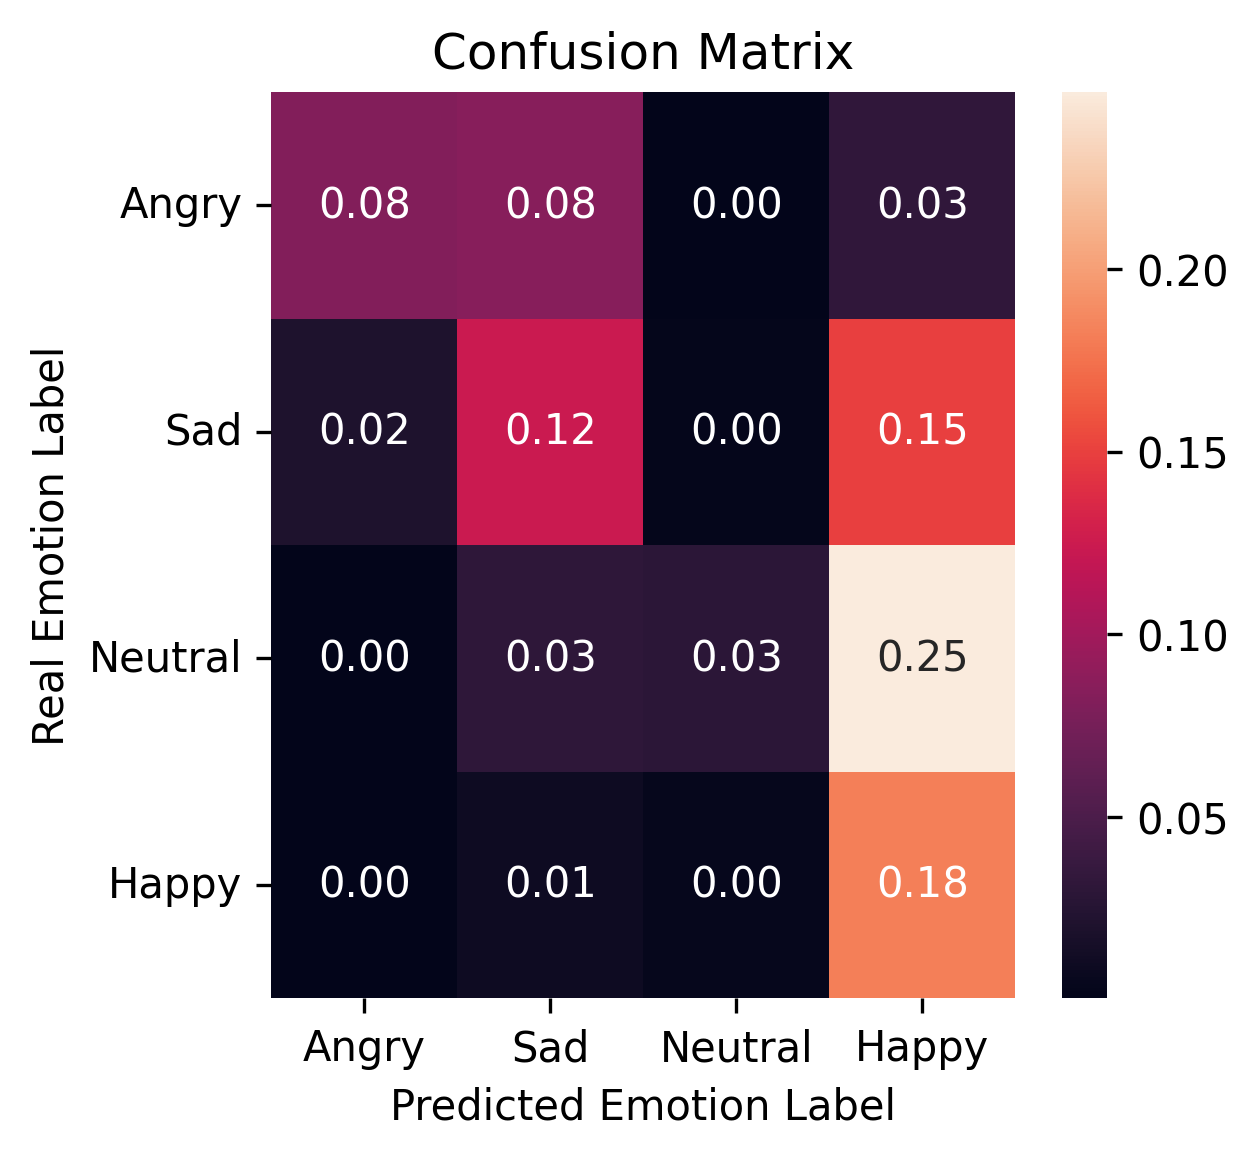

In [73]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)

df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

results = regression_cross_validation(get_new_model_regressor, "Angry, Sad, Neutral, Happy", results)